In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob
import pathlib
import pydicom
from tqdm import tqdm
import shutil
import cv2
from sklearn import ensemble
from sklearn import model_selection, metrics

%matplotlib inline

### load dataframe

In [167]:
train_df = pd.read_csv("../input/train-rle.csv")

In [168]:
train_df.head()

ImageId  \
0  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   

                                       EncodedPixels  
0                                                 -1  
1                                                 -1  
2   175349 7 1013 12 1009 17 1005 19 1003 20 1002...  
3   407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...  
4   252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...

In [169]:
train_df.columns

Index(['ImageId', ' EncodedPixels'], dtype='object')

In [170]:
print(f"num of pos datapoints: {len(train_df[train_df[' EncodedPixels'] != ' -1'])}, total datapoints: {len(train_df)}")

num of pos datapoints: 3286, total datapoints: 11582


- highly imbalanced dataset, we will use AUC as validation metric

### lets check some images and corresponding masks from training dataset

In [171]:
# these functions are provided by Kaggle in order to convert run length encoding to mask and vice versa

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor: 
                if currentColor >= 127:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    
    mask= np.zeros(width* height)
    if rle == ' -1' or rle == '-1':
        return mask.reshape(width,height)
    array = np.asarray([int(x) for x in rle.split()])
    
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [172]:
train_df.iloc[0,0]

'1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090'

In [173]:
train_files = glob.glob("../input/siim-original/dicom-images-train/*/*/*.dcm")
test_files = glob.glob("../input/siim-original/dicom-images-test/*/*/*.dcm")

In [174]:
print(f"DataPoints in train set :{len(train_files)}, Datapoints in test set :{len(test_files)}")

DataPoints in train set :10712, Datapoints in test set :1377


In [175]:
type(train_files)

list

In [176]:
str(pathlib.Path(train_files[0]))

'..\\input\\siim-original\\dicom-images-train\\1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026\\1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025\\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm'

In [177]:
os.path.exists(str(pathlib.Path(train_files[0])))

True

### `NOTE`: ImageId in the dataframe is the image name, you have to add .dcm extension while reading the image

### Lets randomly display some images from the dataset along with its mask if it exists

mask found in image no: 0
mask found in image no: 1
mask found in image no: 7


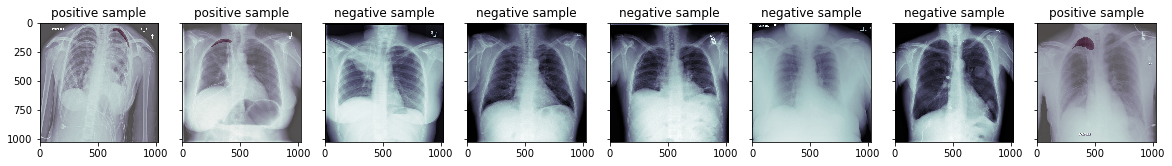

In [183]:
num_images  = 8
fig, ax = plt.subplots(1, num_images, sharey=True, figsize=(20,20))
index = np.random.choice(len(train_files), num_images)
for enum, ind in enumerate(index):
    record = pydicom.dcmread(str(train_files[ind]))
    img = record.pixel_array
    ax[enum].imshow(img, cmap=plt.cm.bone)
    # get the mask for the current image from dataframe
    img_rle = train_df.loc[train_df["ImageId"] == str(train_files[ind]).split("\\")[-1][:-4], " EncodedPixels"].values[0]
    
    if img_rle != ' -1':
        mask = rle2mask(img_rle, 1024, 1024).T
        ax[enum].imshow(mask, alpha = 0.3, cmap="Reds")
        print(f"mask found in image no: {enum}")
        ax[enum].set_title("positive sample")
    else:
        ax[enum].set_title("negative sample")

### Lets build Random Forest classifier

- lets add image pixel values
- we will resize to small size so that training is faster

In [170]:
data = []
target = []
for enum, fname in enumerate(tqdm(train_files, total=len(train_files))):
    
    file = str(pathlib.Path(fname)) # fullpath dcm filename
    img = pydicom.dcmread(file).pixel_array
    # resize to (256,256)
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_CUBIC)
    img = img.ravel()
     
    # find the label for this image
    filestr = file.split("\\")[-1][:-4]
    # check if file exist in data frame
    if (train_df["ImageId"] == filestr).sum() > 0:        
        img_rle = train_df.loc[train_df["ImageId"] == filestr, " EncodedPixels"].values[0]
        if img_rle == '-1' or img_rle == ' -1':
            label = 0
        else:
            label = 1
    else:
        print(f"record num: {enum} does not exist in dataframe")
    
    data.append(img)
    target.append(label)
    






  0%|                                                                                        | 0/10712 [00:00<?, ?it/s]




  0%|                                                                                | 2/10712 [00:00<12:17, 14.53it/s]




  0%|                                                                                | 4/10712 [00:00<12:24, 14.38it/s]




  0%|                                                                                | 6/10712 [00:00<12:09, 14.68it/s]




  0%|                                                                                | 8/10712 [00:00<12:14, 14.57it/s]




  0%|                                                                               | 10/10712 [00:00<12:19, 14.46it/s]




  0%|                                                                               | 12/10712 [00:00<12:07, 14.71it/s]




  0%|                                                                               | 14/10712 [00:00<11:44, 15.19it/s]




  0

  1%|▊                                                                             | 116/10712 [00:08<13:44, 12.84it/s]




  1%|▊                                                                             | 118/10712 [00:08<13:22, 13.20it/s]




  1%|▊                                                                             | 120/10712 [00:08<13:01, 13.55it/s]




  1%|▉                                                                             | 122/10712 [00:09<12:28, 14.15it/s]




  1%|▉                                                                             | 124/10712 [00:09<11:58, 14.73it/s]




  1%|▉                                                                             | 126/10712 [00:09<11:39, 15.14it/s]




  1%|▉                                                                             | 128/10712 [00:09<11:57, 14.75it/s]




  1%|▉                                                                             | 130/10712 [00:09<12:33, 14.04it/s]




  1%|▉  

  2%|█▋                                                                            | 232/10712 [00:16<12:04, 14.47it/s]




  2%|█▋                                                                            | 234/10712 [00:16<11:27, 15.25it/s]




  2%|█▋                                                                            | 236/10712 [00:16<11:32, 15.13it/s]




  2%|█▋                                                                            | 238/10712 [00:17<11:14, 15.53it/s]




  2%|█▋                                                                            | 240/10712 [00:17<11:09, 15.65it/s]




  2%|█▊                                                                            | 242/10712 [00:17<10:56, 15.95it/s]




  2%|█▊                                                                            | 244/10712 [00:17<10:42, 16.29it/s]




  2%|█▊                                                                            | 246/10712 [00:17<10:29, 16.62it/s]




  2%|█▊ 

record num: 252 does not exist in dataframe







  2%|█▊                                                                            | 256/10712 [00:18<10:59, 15.86it/s]




  2%|█▉                                                                            | 258/10712 [00:18<11:20, 15.36it/s]




  2%|█▉                                                                            | 260/10712 [00:18<11:38, 14.97it/s]




  2%|█▉                                                                            | 262/10712 [00:18<11:39, 14.93it/s]




  2%|█▉                                                                            | 264/10712 [00:18<11:39, 14.94it/s]




  2%|█▉                                                                            | 266/10712 [00:18<11:40, 14.92it/s]




  3%|█▉                                                                            | 268/10712 [00:18<11:06, 15.67it/s]




  3%|█▉                                                                            | 270/10712 [00:19<11:06, 15.67it/s]




  3

  3%|██▋                                                                           | 372/10712 [00:26<12:35, 13.68it/s]




  3%|██▋                                                                           | 374/10712 [00:26<12:08, 14.19it/s]




  4%|██▋                                                                           | 376/10712 [00:26<12:07, 14.20it/s]




  4%|██▊                                                                           | 378/10712 [00:26<12:16, 14.03it/s]




  4%|██▊                                                                           | 380/10712 [00:26<12:05, 14.24it/s]




  4%|██▊                                                                           | 382/10712 [00:26<12:01, 14.32it/s]




  4%|██▊                                                                           | 384/10712 [00:26<11:37, 14.80it/s]




  4%|██▊                                                                           | 386/10712 [00:27<11:46, 14.62it/s]




  4%|██▊

record num: 396 does not exist in dataframe







  4%|██▉                                                                           | 402/10712 [00:28<10:49, 15.87it/s]




  4%|██▉                                                                           | 404/10712 [00:28<10:59, 15.62it/s]




  4%|██▉                                                                           | 406/10712 [00:28<11:12, 15.31it/s]




  4%|██▉                                                                           | 408/10712 [00:28<11:31, 14.90it/s]




  4%|██▉                                                                           | 410/10712 [00:28<12:08, 14.13it/s]




  4%|███                                                                           | 412/10712 [00:28<12:07, 14.16it/s]




  4%|███                                                                           | 414/10712 [00:28<12:00, 14.30it/s]




  4%|███                                                                           | 416/10712 [00:29<12:08, 14.12it/s]




  4

record num: 445 does not exist in dataframe







  4%|███▎                                                                          | 450/10712 [00:31<12:08, 14.08it/s]




  4%|███▎                                                                          | 452/10712 [00:31<12:23, 13.80it/s]




  4%|███▎                                                                          | 454/10712 [00:31<12:45, 13.39it/s]




  4%|███▎                                                                          | 456/10712 [00:31<12:43, 13.44it/s]




  4%|███▎                                                                          | 458/10712 [00:32<13:08, 13.00it/s]




  4%|███▎                                                                          | 460/10712 [00:32<12:40, 13.48it/s]




  4%|███▎                                                                          | 462/10712 [00:32<12:57, 13.18it/s]




  4%|███▍                                                                          | 464/10712 [00:32<12:25, 13.75it/s]




  4

  5%|████                                                                          | 566/10712 [00:39<12:23, 13.64it/s]




  5%|████▏                                                                         | 568/10712 [00:39<12:20, 13.70it/s]




  5%|████▏                                                                         | 570/10712 [00:39<13:31, 12.50it/s]




  5%|████▏                                                                         | 572/10712 [00:39<13:25, 12.58it/s]




  5%|████▏                                                                         | 574/10712 [00:40<13:55, 12.13it/s]




  5%|████▏                                                                         | 576/10712 [00:40<13:41, 12.34it/s]




  5%|████▏                                                                         | 578/10712 [00:40<13:05, 12.90it/s]




  5%|████▏                                                                         | 580/10712 [00:40<12:17, 13.73it/s]




  5%|███

record num: 654 does not exist in dataframe







  6%|████▊                                                                         | 658/10712 [00:46<13:26, 12.46it/s]




  6%|████▊                                                                         | 660/10712 [00:46<12:44, 13.15it/s]




  6%|████▊                                                                         | 662/10712 [00:46<12:54, 12.98it/s]




  6%|████▊                                                                         | 664/10712 [00:46<13:36, 12.30it/s]




  6%|████▊                                                                         | 666/10712 [00:46<13:02, 12.84it/s]




  6%|████▊                                                                         | 668/10712 [00:46<12:07, 13.80it/s]




  6%|████▉                                                                         | 670/10712 [00:47<11:43, 14.28it/s]




  6%|████▉                                                                         | 672/10712 [00:47<11:37, 14.39it/s]




  6

record num: 743 does not exist in dataframe







  7%|█████▍                                                                        | 748/10712 [00:52<12:51, 12.92it/s]




  7%|█████▍                                                                        | 750/10712 [00:53<12:27, 13.33it/s]




  7%|█████▍                                                                        | 752/10712 [00:53<12:14, 13.56it/s]




  7%|█████▍                                                                        | 754/10712 [00:53<11:55, 13.93it/s]




  7%|█████▌                                                                        | 756/10712 [00:53<12:14, 13.56it/s]




  7%|█████▌                                                                        | 758/10712 [00:53<12:56, 12.83it/s]




  7%|█████▌                                                                        | 760/10712 [00:53<13:29, 12.29it/s]




  7%|█████▌                                                                        | 762/10712 [00:53<14:04, 11.78it/s]




  7

  8%|██████▎                                                                       | 864/10712 [01:01<12:02, 13.62it/s]




  8%|██████▎                                                                       | 866/10712 [01:01<12:00, 13.66it/s]




  8%|██████▎                                                                       | 868/10712 [01:01<12:15, 13.38it/s]




  8%|██████▎                                                                       | 870/10712 [01:01<11:58, 13.71it/s]




  8%|██████▎                                                                       | 872/10712 [01:01<12:21, 13.28it/s]




  8%|██████▎                                                                       | 874/10712 [01:02<11:47, 13.91it/s]




  8%|██████▍                                                                       | 876/10712 [01:02<11:42, 14.01it/s]




  8%|██████▍                                                                       | 878/10712 [01:02<11:06, 14.75it/s]




  8%|███

  9%|███████▏                                                                      | 980/10712 [01:09<13:20, 12.15it/s]




  9%|███████▏                                                                      | 982/10712 [01:09<12:41, 12.78it/s]




  9%|███████▏                                                                      | 984/10712 [01:09<12:02, 13.47it/s]




  9%|███████▏                                                                      | 986/10712 [01:09<11:31, 14.06it/s]




  9%|███████▏                                                                      | 988/10712 [01:10<11:45, 13.79it/s]




  9%|███████▏                                                                      | 990/10712 [01:10<11:24, 14.21it/s]




  9%|███████▏                                                                      | 992/10712 [01:10<11:19, 14.31it/s]




  9%|███████▏                                                                      | 994/10712 [01:10<11:00, 14.72it/s]




  9%|███

 10%|███████▉                                                                     | 1096/10712 [01:17<11:00, 14.56it/s]




 10%|███████▉                                                                     | 1098/10712 [01:17<11:19, 14.15it/s]




 10%|███████▉                                                                     | 1100/10712 [01:18<11:13, 14.26it/s]




 10%|███████▉                                                                     | 1102/10712 [01:18<10:54, 14.69it/s]




 10%|███████▉                                                                     | 1104/10712 [01:18<10:37, 15.07it/s]




 10%|███████▉                                                                     | 1106/10712 [01:18<10:54, 14.68it/s]




 10%|███████▉                                                                     | 1108/10712 [01:18<10:57, 14.60it/s]




 10%|███████▉                                                                     | 1110/10712 [01:18<11:24, 14.03it/s]




 10%|███

record num: 1208 does not exist in dataframe







 11%|████████▋                                                                    | 1212/10712 [01:25<10:47, 14.68it/s]




 11%|████████▋                                                                    | 1214/10712 [01:25<10:13, 15.48it/s]




 11%|████████▋                                                                    | 1216/10712 [01:26<10:23, 15.22it/s]




 11%|████████▊                                                                    | 1218/10712 [01:26<10:46, 14.67it/s]




 11%|████████▊                                                                    | 1220/10712 [01:26<10:54, 14.51it/s]




 11%|████████▊                                                                    | 1222/10712 [01:26<10:38, 14.87it/s]




 11%|████████▊                                                                    | 1224/10712 [01:26<10:41, 14.80it/s]




 11%|████████▊                                                                    | 1226/10712 [01:26<11:10, 14.16it/s]




 11

 12%|█████████▌                                                                   | 1328/10712 [01:33<10:46, 14.52it/s]




 12%|█████████▌                                                                   | 1330/10712 [01:34<10:30, 14.88it/s]

record num: 1328 does not exist in dataframe







 12%|█████████▌                                                                   | 1332/10712 [01:34<11:37, 13.44it/s]




 12%|█████████▌                                                                   | 1334/10712 [01:34<11:23, 13.72it/s]




 12%|█████████▌                                                                   | 1336/10712 [01:34<11:25, 13.67it/s]




 12%|█████████▌                                                                   | 1338/10712 [01:34<11:17, 13.83it/s]




 13%|█████████▋                                                                   | 1340/10712 [01:34<11:45, 13.28it/s]




 13%|█████████▋                                                                   | 1342/10712 [01:34<11:23, 13.72it/s]




 13%|█████████▋                                                                   | 1344/10712 [01:35<11:14, 13.89it/s]




 13%|█████████▋                                                                   | 1346/10712 [01:35<11:31, 13.54it/s]




 13

 14%|██████████▍                                                                  | 1448/10712 [01:42<11:43, 13.18it/s]




 14%|██████████▍                                                                  | 1450/10712 [01:42<11:49, 13.05it/s]




 14%|██████████▍                                                                  | 1452/10712 [01:42<11:30, 13.41it/s]




 14%|██████████▍                                                                  | 1454/10712 [01:42<11:39, 13.24it/s]




 14%|██████████▍                                                                  | 1456/10712 [01:43<10:59, 14.03it/s]




 14%|██████████▍                                                                  | 1458/10712 [01:43<11:49, 13.04it/s]




 14%|██████████▍                                                                  | 1460/10712 [01:43<11:26, 13.48it/s]




 14%|██████████▌                                                                  | 1462/10712 [01:43<11:07, 13.87it/s]




 14%|███

 15%|███████████▏                                                                 | 1564/10712 [01:50<11:01, 13.83it/s]




 15%|███████████▎                                                                 | 1566/10712 [01:50<10:32, 14.46it/s]




 15%|███████████▎                                                                 | 1568/10712 [01:51<10:47, 14.11it/s]




 15%|███████████▎                                                                 | 1570/10712 [01:51<11:01, 13.82it/s]




 15%|███████████▎                                                                 | 1572/10712 [01:51<10:43, 14.21it/s]




 15%|███████████▎                                                                 | 1574/10712 [01:51<10:27, 14.55it/s]




 15%|███████████▎                                                                 | 1576/10712 [01:51<10:37, 14.33it/s]




 15%|███████████▎                                                                 | 1578/10712 [01:51<10:44, 14.18it/s]




 15%|███

 16%|████████████                                                                 | 1680/10712 [01:59<11:33, 13.03it/s]




 16%|████████████                                                                 | 1682/10712 [01:59<11:38, 12.93it/s]




 16%|████████████                                                                 | 1684/10712 [01:59<11:12, 13.43it/s]




 16%|████████████                                                                 | 1686/10712 [01:59<10:51, 13.85it/s]




 16%|████████████▏                                                                | 1688/10712 [01:59<10:35, 14.20it/s]




 16%|████████████▏                                                                | 1690/10712 [01:59<10:32, 14.27it/s]




 16%|████████████▏                                                                | 1692/10712 [02:00<10:09, 14.79it/s]




 16%|████████████▏                                                                | 1694/10712 [02:00<10:18, 14.58it/s]




 16%|███

record num: 1703 does not exist in dataframe







 16%|████████████▎                                                                | 1708/10712 [02:01<11:21, 13.21it/s]




 16%|████████████▎                                                                | 1710/10712 [02:01<11:25, 13.13it/s]




 16%|████████████▎                                                                | 1712/10712 [02:01<11:55, 12.58it/s]




 16%|████████████▎                                                                | 1714/10712 [02:01<11:41, 12.83it/s]




 16%|████████████▎                                                                | 1716/10712 [02:01<11:04, 13.54it/s]

record num: 1713 does not exist in dataframe







 16%|████████████▎                                                                | 1718/10712 [02:02<10:37, 14.12it/s]




 16%|████████████▎                                                                | 1720/10712 [02:02<10:36, 14.12it/s]




 16%|████████████▍                                                                | 1722/10712 [02:02<10:40, 14.03it/s]




 16%|████████████▍                                                                | 1724/10712 [02:02<10:24, 14.39it/s]




 16%|████████████▍                                                                | 1726/10712 [02:02<10:50, 13.81it/s]




 16%|████████████▍                                                                | 1728/10712 [02:02<11:19, 13.21it/s]

record num: 1725 does not exist in dataframe







 16%|████████████▍                                                                | 1730/10712 [02:02<11:21, 13.18it/s]




 16%|████████████▍                                                                | 1732/10712 [02:03<11:52, 12.61it/s]




 16%|████████████▍                                                                | 1734/10712 [02:03<11:37, 12.88it/s]




 16%|████████████▍                                                                | 1736/10712 [02:03<11:34, 12.92it/s]

record num: 1733 does not exist in dataframe







 16%|████████████▍                                                                | 1738/10712 [02:03<11:43, 12.75it/s]




 16%|████████████▌                                                                | 1740/10712 [02:03<12:04, 12.38it/s]




 16%|████████████▌                                                                | 1742/10712 [02:03<12:03, 12.40it/s]




 16%|████████████▌                                                                | 1744/10712 [02:04<11:44, 12.73it/s]




 16%|████████████▌                                                                | 1746/10712 [02:04<11:30, 12.99it/s]




 16%|████████████▌                                                                | 1748/10712 [02:04<11:06, 13.44it/s]




 16%|████████████▌                                                                | 1750/10712 [02:04<11:02, 13.53it/s]




 16%|████████████▌                                                                | 1752/10712 [02:04<10:49, 13.79it/s]




 16

 17%|█████████████▎                                                               | 1854/10712 [02:12<10:44, 13.74it/s]




 17%|█████████████▎                                                               | 1856/10712 [02:12<11:19, 13.04it/s]




 17%|█████████████▎                                                               | 1858/10712 [02:12<11:46, 12.52it/s]




 17%|█████████████▎                                                               | 1860/10712 [02:12<11:38, 12.67it/s]




 17%|█████████████▍                                                               | 1862/10712 [02:12<11:16, 13.07it/s]




 17%|█████████████▍                                                               | 1864/10712 [02:13<11:49, 12.47it/s]




 17%|█████████████▍                                                               | 1866/10712 [02:13<11:50, 12.44it/s]




 17%|█████████████▍                                                               | 1868/10712 [02:13<11:38, 12.66it/s]




 17%|███

 18%|██████████████▏                                                              | 1970/10712 [02:22<11:48, 12.33it/s]




 18%|██████████████▏                                                              | 1972/10712 [02:22<11:19, 12.87it/s]




 18%|██████████████▏                                                              | 1974/10712 [02:22<12:33, 11.59it/s]




 18%|██████████████▏                                                              | 1976/10712 [02:22<12:03, 12.07it/s]




 18%|██████████████▏                                                              | 1978/10712 [02:22<12:51, 11.32it/s]




 18%|██████████████▏                                                              | 1980/10712 [02:23<12:09, 11.97it/s]




 19%|██████████████▏                                                              | 1982/10712 [02:23<11:39, 12.47it/s]




 19%|██████████████▎                                                              | 1984/10712 [02:23<11:06, 13.10it/s]




 19%|███

 19%|██████████████▉                                                              | 2086/10712 [02:30<11:10, 12.87it/s]




 19%|███████████████                                                              | 2088/10712 [02:30<11:11, 12.84it/s]




 20%|███████████████                                                              | 2090/10712 [02:31<11:04, 12.97it/s]




 20%|███████████████                                                              | 2092/10712 [02:31<10:48, 13.29it/s]




 20%|███████████████                                                              | 2094/10712 [02:31<10:20, 13.90it/s]




 20%|███████████████                                                              | 2096/10712 [02:31<10:00, 14.35it/s]




 20%|███████████████                                                              | 2098/10712 [02:31<09:41, 14.82it/s]




 20%|███████████████                                                              | 2100/10712 [02:31<09:34, 15.00it/s]




 20%|███

 21%|███████████████▊                                                             | 2202/10712 [02:38<10:45, 13.18it/s]




 21%|███████████████▊                                                             | 2204/10712 [02:38<10:32, 13.45it/s]




 21%|███████████████▊                                                             | 2206/10712 [02:39<10:20, 13.70it/s]




 21%|███████████████▊                                                             | 2208/10712 [02:39<10:06, 14.03it/s]




 21%|███████████████▉                                                             | 2210/10712 [02:39<09:59, 14.17it/s]




 21%|███████████████▉                                                             | 2212/10712 [02:39<10:07, 13.98it/s]




 21%|███████████████▉                                                             | 2214/10712 [02:39<10:27, 13.54it/s]




 21%|███████████████▉                                                             | 2216/10712 [02:39<10:08, 13.97it/s]




 21%|███

record num: 2252 does not exist in dataframe







 21%|████████████████▏                                                            | 2256/10712 [02:42<09:40, 14.56it/s]




 21%|████████████████▏                                                            | 2258/10712 [02:42<09:34, 14.71it/s]




 21%|████████████████▏                                                            | 2260/10712 [02:43<09:49, 14.34it/s]




 21%|████████████████▎                                                            | 2262/10712 [02:43<09:55, 14.19it/s]




 21%|████████████████▎                                                            | 2264/10712 [02:43<10:02, 14.02it/s]




 21%|████████████████▎                                                            | 2266/10712 [02:43<10:12, 13.79it/s]




 21%|████████████████▎                                                            | 2268/10712 [02:43<10:24, 13.52it/s]




 21%|████████████████▎                                                            | 2270/10712 [02:43<10:16, 13.70it/s]




 21

 22%|█████████████████                                                            | 2372/10712 [02:50<09:14, 15.05it/s]




 22%|█████████████████                                                            | 2374/10712 [02:51<09:39, 14.38it/s]




 22%|█████████████████                                                            | 2376/10712 [02:51<09:46, 14.21it/s]




 22%|█████████████████                                                            | 2378/10712 [02:51<09:26, 14.71it/s]




 22%|█████████████████                                                            | 2380/10712 [02:51<09:49, 14.13it/s]




 22%|█████████████████                                                            | 2382/10712 [02:51<09:48, 14.16it/s]




 22%|█████████████████▏                                                           | 2384/10712 [02:51<10:07, 13.71it/s]




 22%|█████████████████▏                                                           | 2386/10712 [02:52<11:00, 12.61it/s]




 22%|███

 23%|█████████████████▉                                                           | 2488/10712 [02:59<10:01, 13.67it/s]




 23%|█████████████████▉                                                           | 2490/10712 [02:59<10:33, 12.97it/s]




 23%|█████████████████▉                                                           | 2492/10712 [02:59<10:41, 12.81it/s]




 23%|█████████████████▉                                                           | 2494/10712 [02:59<10:33, 12.97it/s]




 23%|█████████████████▉                                                           | 2496/10712 [02:59<10:43, 12.76it/s]




 23%|█████████████████▉                                                           | 2498/10712 [02:59<10:16, 13.33it/s]




 23%|█████████████████▉                                                           | 2500/10712 [03:00<10:18, 13.29it/s]




 23%|█████████████████▉                                                           | 2502/10712 [03:00<10:14, 13.36it/s]




 23%|███

 24%|██████████████████▋                                                          | 2604/10712 [03:07<10:18, 13.11it/s]




 24%|██████████████████▋                                                          | 2606/10712 [03:07<10:13, 13.21it/s]




 24%|██████████████████▋                                                          | 2608/10712 [03:07<10:12, 13.23it/s]




 24%|██████████████████▊                                                          | 2610/10712 [03:08<09:54, 13.63it/s]




 24%|██████████████████▊                                                          | 2612/10712 [03:08<09:32, 14.15it/s]




 24%|██████████████████▊                                                          | 2614/10712 [03:08<09:21, 14.42it/s]




 24%|██████████████████▊                                                          | 2616/10712 [03:08<09:20, 14.45it/s]




 24%|██████████████████▊                                                          | 2618/10712 [03:08<09:17, 14.51it/s]




 24%|███

 25%|███████████████████▌                                                         | 2720/10712 [03:16<09:36, 13.86it/s]




 25%|███████████████████▌                                                         | 2722/10712 [03:16<09:27, 14.08it/s]




 25%|███████████████████▌                                                         | 2724/10712 [03:16<09:17, 14.33it/s]




 25%|███████████████████▌                                                         | 2726/10712 [03:16<09:00, 14.77it/s]




 25%|███████████████████▌                                                         | 2728/10712 [03:16<09:03, 14.70it/s]




 25%|███████████████████▌                                                         | 2730/10712 [03:16<09:17, 14.31it/s]




 26%|███████████████████▋                                                         | 2732/10712 [03:16<09:15, 14.37it/s]




 26%|███████████████████▋                                                         | 2734/10712 [03:16<09:40, 13.74it/s]




 26%|███

 26%|████████████████████▍                                                        | 2836/10712 [03:24<09:58, 13.16it/s]




 26%|████████████████████▍                                                        | 2838/10712 [03:24<09:28, 13.86it/s]




 27%|████████████████████▍                                                        | 2840/10712 [03:25<09:11, 14.26it/s]




 27%|████████████████████▍                                                        | 2842/10712 [03:25<09:08, 14.34it/s]




 27%|████████████████████▍                                                        | 2844/10712 [03:25<09:14, 14.18it/s]




 27%|████████████████████▍                                                        | 2846/10712 [03:25<09:15, 14.17it/s]




 27%|████████████████████▍                                                        | 2848/10712 [03:25<09:18, 14.09it/s]




 27%|████████████████████▍                                                        | 2850/10712 [03:25<09:18, 14.07it/s]




 27%|███

 28%|█████████████████████▏                                                       | 2952/10712 [03:33<10:09, 12.74it/s]




 28%|█████████████████████▏                                                       | 2954/10712 [03:33<10:03, 12.85it/s]




 28%|█████████████████████▏                                                       | 2956/10712 [03:33<10:20, 12.49it/s]




 28%|█████████████████████▎                                                       | 2958/10712 [03:34<10:16, 12.57it/s]




 28%|█████████████████████▎                                                       | 2960/10712 [03:34<10:12, 12.66it/s]




 28%|█████████████████████▎                                                       | 2962/10712 [03:34<09:57, 12.96it/s]




 28%|█████████████████████▎                                                       | 2964/10712 [03:34<10:30, 12.29it/s]




 28%|█████████████████████▎                                                       | 2966/10712 [03:34<10:16, 12.57it/s]




 28%|███

 29%|██████████████████████                                                       | 3068/10712 [03:42<09:42, 13.11it/s]




 29%|██████████████████████                                                       | 3070/10712 [03:42<09:39, 13.19it/s]




 29%|██████████████████████                                                       | 3072/10712 [03:42<10:00, 12.71it/s]




 29%|██████████████████████                                                       | 3074/10712 [03:42<09:53, 12.88it/s]




 29%|██████████████████████                                                       | 3076/10712 [03:42<09:38, 13.20it/s]




 29%|██████████████████████▏                                                      | 3078/10712 [03:43<10:28, 12.14it/s]




 29%|██████████████████████▏                                                      | 3080/10712 [03:43<10:02, 12.68it/s]




 29%|██████████████████████▏                                                      | 3082/10712 [03:43<09:37, 13.21it/s]




 29%|███

 30%|██████████████████████▉                                                      | 3184/10712 [03:50<09:39, 12.99it/s]




 30%|██████████████████████▉                                                      | 3186/10712 [03:50<09:47, 12.80it/s]




 30%|██████████████████████▉                                                      | 3188/10712 [03:51<09:32, 13.14it/s]




 30%|██████████████████████▉                                                      | 3190/10712 [03:51<09:17, 13.50it/s]




 30%|██████████████████████▉                                                      | 3192/10712 [03:51<08:42, 14.39it/s]




 30%|██████████████████████▉                                                      | 3194/10712 [03:51<08:31, 14.69it/s]




 30%|██████████████████████▉                                                      | 3196/10712 [03:51<08:35, 14.58it/s]




 30%|██████████████████████▉                                                      | 3198/10712 [03:51<08:50, 14.16it/s]




 30%|███

 31%|███████████████████████▋                                                     | 3300/10712 [03:59<08:18, 14.86it/s]




 31%|███████████████████████▋                                                     | 3302/10712 [03:59<08:33, 14.44it/s]




 31%|███████████████████████▋                                                     | 3304/10712 [03:59<08:54, 13.87it/s]




 31%|███████████████████████▊                                                     | 3306/10712 [03:59<08:48, 14.00it/s]




 31%|███████████████████████▊                                                     | 3308/10712 [03:59<09:07, 13.53it/s]




 31%|███████████████████████▊                                                     | 3310/10712 [03:59<09:08, 13.51it/s]




 31%|███████████████████████▊                                                     | 3312/10712 [04:00<09:26, 13.07it/s]




 31%|███████████████████████▊                                                     | 3314/10712 [04:00<11:41, 10.54it/s]




 31%|███

 32%|████████████████████████▌                                                    | 3416/10712 [04:09<12:17,  9.89it/s]




 32%|████████████████████████▌                                                    | 3417/10712 [04:09<12:21,  9.84it/s]




 32%|████████████████████████▌                                                    | 3418/10712 [04:09<12:28,  9.75it/s]




 32%|████████████████████████▌                                                    | 3419/10712 [04:09<12:43,  9.55it/s]




 32%|████████████████████████▌                                                    | 3421/10712 [04:09<12:23,  9.80it/s]




 32%|████████████████████████▌                                                    | 3423/10712 [04:10<11:51, 10.25it/s]




 32%|████████████████████████▌                                                    | 3425/10712 [04:10<11:49, 10.27it/s]




 32%|████████████████████████▋                                                    | 3427/10712 [04:10<11:57, 10.15it/s]




 32%|███

 33%|█████████████████████████▎                                                   | 3529/10712 [04:18<09:11, 13.03it/s]




 33%|█████████████████████████▍                                                   | 3531/10712 [04:19<09:42, 12.33it/s]




 33%|█████████████████████████▍                                                   | 3533/10712 [04:19<10:54, 10.97it/s]




 33%|█████████████████████████▍                                                   | 3535/10712 [04:19<10:23, 11.51it/s]




 33%|█████████████████████████▍                                                   | 3537/10712 [04:19<10:24, 11.50it/s]




 33%|█████████████████████████▍                                                   | 3539/10712 [04:19<10:26, 11.45it/s]




 33%|█████████████████████████▍                                                   | 3541/10712 [04:20<10:03, 11.88it/s]




 33%|█████████████████████████▍                                                   | 3543/10712 [04:20<10:00, 11.94it/s]




 33%|███

 34%|██████████████████████████▏                                                  | 3645/10712 [04:28<09:49, 11.98it/s]




 34%|██████████████████████████▏                                                  | 3647/10712 [04:28<09:24, 12.51it/s]




 34%|██████████████████████████▏                                                  | 3649/10712 [04:28<09:07, 12.90it/s]




 34%|██████████████████████████▏                                                  | 3651/10712 [04:28<09:36, 12.25it/s]




 34%|██████████████████████████▎                                                  | 3653/10712 [04:28<09:40, 12.15it/s]




 34%|██████████████████████████▎                                                  | 3655/10712 [04:29<09:30, 12.38it/s]




 34%|██████████████████████████▎                                                  | 3657/10712 [04:29<09:26, 12.45it/s]




 34%|██████████████████████████▎                                                  | 3659/10712 [04:29<09:33, 12.29it/s]




 34%|███

record num: 3690 does not exist in dataframe







 34%|██████████████████████████▌                                                  | 3693/10712 [04:32<10:13, 11.44it/s]




 34%|██████████████████████████▌                                                  | 3695/10712 [04:32<10:13, 11.43it/s]




 35%|██████████████████████████▌                                                  | 3697/10712 [04:32<10:06, 11.56it/s]




 35%|██████████████████████████▌                                                  | 3699/10712 [04:32<09:58, 11.71it/s]




 35%|██████████████████████████▌                                                  | 3701/10712 [04:32<09:57, 11.74it/s]




 35%|██████████████████████████▌                                                  | 3703/10712 [04:33<10:00, 11.67it/s]




 35%|██████████████████████████▋                                                  | 3705/10712 [04:33<09:46, 11.94it/s]




 35%|██████████████████████████▋                                                  | 3707/10712 [04:33<09:35, 12.18it/s]




 35

record num: 3731 does not exist in dataframe







 35%|██████████████████████████▊                                                  | 3735/10712 [04:35<09:40, 12.01it/s]




 35%|██████████████████████████▊                                                  | 3737/10712 [04:35<09:44, 11.92it/s]




 35%|██████████████████████████▉                                                  | 3739/10712 [04:36<09:41, 11.99it/s]




 35%|██████████████████████████▉                                                  | 3741/10712 [04:36<09:46, 11.89it/s]




 35%|██████████████████████████▉                                                  | 3743/10712 [04:36<09:45, 11.90it/s]




 35%|██████████████████████████▉                                                  | 3745/10712 [04:36<09:46, 11.87it/s]




 35%|██████████████████████████▉                                                  | 3747/10712 [04:36<09:31, 12.19it/s]




 35%|██████████████████████████▉                                                  | 3749/10712 [04:36<09:10, 12.64it/s]




 35

 36%|███████████████████████████▋                                                 | 3851/10712 [04:45<10:33, 10.83it/s]




 36%|███████████████████████████▋                                                 | 3853/10712 [04:45<10:17, 11.10it/s]




 36%|███████████████████████████▋                                                 | 3855/10712 [04:45<09:32, 11.97it/s]




 36%|███████████████████████████▋                                                 | 3857/10712 [04:46<09:33, 11.96it/s]




 36%|███████████████████████████▋                                                 | 3859/10712 [04:46<09:38, 11.85it/s]




 36%|███████████████████████████▊                                                 | 3861/10712 [04:46<10:41, 10.68it/s]




 36%|███████████████████████████▊                                                 | 3863/10712 [04:46<10:13, 11.16it/s]




 36%|███████████████████████████▊                                                 | 3865/10712 [04:46<10:15, 11.13it/s]




 36%|███

record num: 3957 does not exist in dataframe







 37%|████████████████████████████▍                                                | 3961/10712 [04:54<09:29, 11.86it/s]




 37%|████████████████████████████▍                                                | 3963/10712 [04:54<09:42, 11.59it/s]




 37%|████████████████████████████▌                                                | 3965/10712 [04:54<09:24, 11.95it/s]




 37%|████████████████████████████▌                                                | 3967/10712 [04:55<09:21, 12.01it/s]




 37%|████████████████████████████▌                                                | 3969/10712 [04:55<09:00, 12.48it/s]




 37%|████████████████████████████▌                                                | 3971/10712 [04:55<08:50, 12.71it/s]




 37%|████████████████████████████▌                                                | 3973/10712 [04:55<08:50, 12.70it/s]




 37%|████████████████████████████▌                                                | 3975/10712 [04:55<08:51, 12.68it/s]




 37

 38%|█████████████████████████████▎                                               | 4077/10712 [05:03<08:46, 12.61it/s]




 38%|█████████████████████████████▎                                               | 4079/10712 [05:03<09:02, 12.22it/s]




 38%|█████████████████████████████▎                                               | 4081/10712 [05:04<08:49, 12.52it/s]




 38%|█████████████████████████████▎                                               | 4083/10712 [05:04<08:37, 12.81it/s]




 38%|█████████████████████████████▎                                               | 4085/10712 [05:04<08:46, 12.58it/s]




 38%|█████████████████████████████▍                                               | 4087/10712 [05:04<09:06, 12.11it/s]




 38%|█████████████████████████████▍                                               | 4089/10712 [05:04<09:17, 11.89it/s]




 38%|█████████████████████████████▍                                               | 4091/10712 [05:04<09:07, 12.10it/s]




 38%|███

 39%|██████████████████████████████▏                                              | 4193/10712 [05:13<09:07, 11.91it/s]




 39%|██████████████████████████████▏                                              | 4195/10712 [05:13<08:43, 12.45it/s]




 39%|██████████████████████████████▏                                              | 4197/10712 [05:13<08:38, 12.57it/s]




 39%|██████████████████████████████▏                                              | 4199/10712 [05:13<08:40, 12.51it/s]




 39%|██████████████████████████████▏                                              | 4201/10712 [05:13<08:21, 12.98it/s]




 39%|██████████████████████████████▏                                              | 4203/10712 [05:13<08:22, 12.94it/s]




 39%|██████████████████████████████▏                                              | 4205/10712 [05:13<08:10, 13.28it/s]




 39%|██████████████████████████████▏                                              | 4207/10712 [05:14<08:19, 13.02it/s]




 39%|███

 40%|██████████████████████████████▉                                              | 4309/10712 [05:22<07:22, 14.45it/s]




 40%|██████████████████████████████▉                                              | 4311/10712 [05:22<07:21, 14.51it/s]




 40%|███████████████████████████████                                              | 4313/10712 [05:22<07:29, 14.24it/s]




 40%|███████████████████████████████                                              | 4315/10712 [05:22<07:29, 14.23it/s]




 40%|███████████████████████████████                                              | 4317/10712 [05:22<07:28, 14.26it/s]




 40%|███████████████████████████████                                              | 4319/10712 [05:22<07:34, 14.07it/s]




 40%|███████████████████████████████                                              | 4321/10712 [05:23<07:50, 13.57it/s]




 40%|███████████████████████████████                                              | 4323/10712 [05:23<07:46, 13.70it/s]




 40%|███

 41%|███████████████████████████████▊                                             | 4425/10712 [05:30<07:41, 13.63it/s]




 41%|███████████████████████████████▊                                             | 4427/10712 [05:31<08:02, 13.02it/s]




 41%|███████████████████████████████▊                                             | 4429/10712 [05:31<08:15, 12.67it/s]




 41%|███████████████████████████████▊                                             | 4431/10712 [05:31<08:31, 12.28it/s]




 41%|███████████████████████████████▊                                             | 4433/10712 [05:31<08:58, 11.67it/s]




 41%|███████████████████████████████▉                                             | 4435/10712 [05:31<08:54, 11.75it/s]




 41%|███████████████████████████████▉                                             | 4437/10712 [05:31<08:31, 12.26it/s]




 41%|███████████████████████████████▉                                             | 4439/10712 [05:32<08:18, 12.57it/s]




 41%|███

 42%|████████████████████████████████▋                                            | 4541/10712 [05:39<07:32, 13.64it/s]




 42%|████████████████████████████████▋                                            | 4543/10712 [05:39<07:20, 14.01it/s]




 42%|████████████████████████████████▋                                            | 4545/10712 [05:40<07:02, 14.60it/s]




 42%|████████████████████████████████▋                                            | 4547/10712 [05:40<06:55, 14.84it/s]




 42%|████████████████████████████████▋                                            | 4549/10712 [05:40<06:45, 15.21it/s]




 42%|████████████████████████████████▋                                            | 4551/10712 [05:40<06:35, 15.56it/s]




 43%|████████████████████████████████▋                                            | 4553/10712 [05:40<06:35, 15.56it/s]




 43%|████████████████████████████████▋                                            | 4555/10712 [05:40<06:56, 14.80it/s]




 43%|███

 43%|█████████████████████████████████▍                                           | 4657/10712 [05:48<07:45, 13.01it/s]




 43%|█████████████████████████████████▍                                           | 4659/10712 [05:48<07:50, 12.86it/s]




 44%|█████████████████████████████████▌                                           | 4661/10712 [05:48<07:35, 13.30it/s]




 44%|█████████████████████████████████▌                                           | 4663/10712 [05:48<07:31, 13.40it/s]




 44%|█████████████████████████████████▌                                           | 4665/10712 [05:48<07:23, 13.63it/s]




 44%|█████████████████████████████████▌                                           | 4667/10712 [05:48<07:31, 13.39it/s]




 44%|█████████████████████████████████▌                                           | 4669/10712 [05:49<07:34, 13.30it/s]




 44%|█████████████████████████████████▌                                           | 4671/10712 [05:49<07:16, 13.85it/s]




 44%|███

 45%|██████████████████████████████████▎                                          | 4773/10712 [05:56<07:54, 12.51it/s]




 45%|██████████████████████████████████▎                                          | 4775/10712 [05:57<07:38, 12.96it/s]




 45%|██████████████████████████████████▎                                          | 4777/10712 [05:57<07:17, 13.55it/s]




 45%|██████████████████████████████████▎                                          | 4779/10712 [05:57<07:08, 13.83it/s]




 45%|██████████████████████████████████▎                                          | 4781/10712 [05:57<06:59, 14.12it/s]




 45%|██████████████████████████████████▍                                          | 4783/10712 [05:57<06:46, 14.59it/s]




 45%|██████████████████████████████████▍                                          | 4785/10712 [05:57<06:33, 15.06it/s]




 45%|██████████████████████████████████▍                                          | 4787/10712 [05:57<06:35, 15.00it/s]




 45%|███

 46%|███████████████████████████████████▏                                         | 4889/10712 [06:05<07:01, 13.81it/s]




 46%|███████████████████████████████████▏                                         | 4891/10712 [06:05<06:51, 14.14it/s]




 46%|███████████████████████████████████▏                                         | 4893/10712 [06:06<07:11, 13.48it/s]




 46%|███████████████████████████████████▏                                         | 4895/10712 [06:06<07:14, 13.39it/s]




 46%|███████████████████████████████████▏                                         | 4897/10712 [06:06<07:04, 13.69it/s]




 46%|███████████████████████████████████▏                                         | 4899/10712 [06:06<07:13, 13.40it/s]




 46%|███████████████████████████████████▏                                         | 4901/10712 [06:06<07:17, 13.28it/s]




 46%|███████████████████████████████████▏                                         | 4903/10712 [06:06<07:04, 13.69it/s]




 46%|███

record num: 4984 does not exist in dataframe







 47%|███████████████████████████████████▊                                         | 4989/10712 [06:13<06:49, 13.97it/s]




 47%|███████████████████████████████████▉                                         | 4991/10712 [06:13<06:44, 14.13it/s]




 47%|███████████████████████████████████▉                                         | 4993/10712 [06:13<06:31, 14.59it/s]




 47%|███████████████████████████████████▉                                         | 4995/10712 [06:13<06:19, 15.07it/s]




 47%|███████████████████████████████████▉                                         | 4997/10712 [06:13<06:16, 15.17it/s]




 47%|███████████████████████████████████▉                                         | 4999/10712 [06:13<06:37, 14.36it/s]




 47%|███████████████████████████████████▉                                         | 5001/10712 [06:13<06:31, 14.60it/s]




 47%|███████████████████████████████████▉                                         | 5003/10712 [06:13<06:32, 14.55it/s]




 47

 48%|████████████████████████████████████▋                                        | 5105/10712 [06:21<06:20, 14.75it/s]




 48%|████████████████████████████████████▋                                        | 5107/10712 [06:21<06:24, 14.59it/s]




 48%|████████████████████████████████████▋                                        | 5109/10712 [06:21<06:29, 14.38it/s]




 48%|████████████████████████████████████▋                                        | 5111/10712 [06:21<06:17, 14.84it/s]




 48%|████████████████████████████████████▊                                        | 5113/10712 [06:21<06:21, 14.68it/s]




 48%|████████████████████████████████████▊                                        | 5115/10712 [06:22<06:12, 15.03it/s]




 48%|████████████████████████████████████▊                                        | 5117/10712 [06:22<06:14, 14.95it/s]




 48%|████████████████████████████████████▊                                        | 5119/10712 [06:22<06:23, 14.59it/s]




 48%|███

 49%|█████████████████████████████████████▌                                       | 5221/10712 [06:29<06:52, 13.32it/s]




 49%|█████████████████████████████████████▌                                       | 5223/10712 [06:30<06:59, 13.10it/s]




 49%|█████████████████████████████████████▌                                       | 5225/10712 [06:30<08:02, 11.36it/s]




 49%|█████████████████████████████████████▌                                       | 5227/10712 [06:30<07:40, 11.92it/s]




 49%|█████████████████████████████████████▌                                       | 5229/10712 [06:30<07:14, 12.62it/s]




 49%|█████████████████████████████████████▌                                       | 5231/10712 [06:30<07:11, 12.72it/s]




 49%|█████████████████████████████████████▌                                       | 5233/10712 [06:30<07:11, 12.71it/s]




 49%|█████████████████████████████████████▋                                       | 5235/10712 [06:31<07:01, 13.00it/s]




 49%|███

 50%|██████████████████████████████████████▎                                      | 5337/10712 [06:39<06:45, 13.24it/s]




 50%|██████████████████████████████████████▍                                      | 5339/10712 [06:39<07:15, 12.33it/s]




 50%|██████████████████████████████████████▍                                      | 5341/10712 [06:39<07:17, 12.27it/s]




 50%|██████████████████████████████████████▍                                      | 5343/10712 [06:39<07:09, 12.51it/s]




 50%|██████████████████████████████████████▍                                      | 5345/10712 [06:39<07:00, 12.76it/s]




 50%|██████████████████████████████████████▍                                      | 5347/10712 [06:39<06:52, 13.01it/s]




 50%|██████████████████████████████████████▍                                      | 5349/10712 [06:40<06:51, 13.04it/s]




 50%|██████████████████████████████████████▍                                      | 5351/10712 [06:40<07:00, 12.76it/s]




 50%|███

 51%|███████████████████████████████████████▏                                     | 5453/10712 [06:47<06:38, 13.21it/s]




 51%|███████████████████████████████████████▏                                     | 5455/10712 [06:47<06:55, 12.65it/s]




 51%|███████████████████████████████████████▏                                     | 5457/10712 [06:48<06:50, 12.81it/s]




 51%|███████████████████████████████████████▏                                     | 5459/10712 [06:48<06:37, 13.20it/s]




 51%|███████████████████████████████████████▎                                     | 5461/10712 [06:48<06:13, 14.06it/s]




 51%|███████████████████████████████████████▎                                     | 5463/10712 [06:48<05:56, 14.73it/s]




 51%|███████████████████████████████████████▎                                     | 5465/10712 [06:48<06:14, 14.02it/s]




 51%|███████████████████████████████████████▎                                     | 5467/10712 [06:48<06:05, 14.35it/s]




 51%|███

 52%|████████████████████████████████████████                                     | 5569/10712 [06:56<07:18, 11.72it/s]




 52%|████████████████████████████████████████                                     | 5571/10712 [06:56<07:29, 11.44it/s]




 52%|████████████████████████████████████████                                     | 5573/10712 [06:56<07:10, 11.94it/s]




 52%|████████████████████████████████████████                                     | 5575/10712 [06:56<06:52, 12.45it/s]




 52%|████████████████████████████████████████                                     | 5577/10712 [06:56<06:42, 12.76it/s]




 52%|████████████████████████████████████████                                     | 5579/10712 [06:57<06:20, 13.48it/s]




 52%|████████████████████████████████████████                                     | 5581/10712 [06:57<06:13, 13.73it/s]




 52%|████████████████████████████████████████▏                                    | 5583/10712 [06:57<06:09, 13.90it/s]




 52%|███

record num: 5660 does not exist in dataframe







 53%|████████████████████████████████████████▋                                    | 5665/10712 [07:03<05:48, 14.48it/s]




 53%|████████████████████████████████████████▋                                    | 5667/10712 [07:03<05:46, 14.56it/s]




 53%|████████████████████████████████████████▋                                    | 5669/10712 [07:03<06:22, 13.20it/s]




 53%|████████████████████████████████████████▊                                    | 5671/10712 [07:03<06:16, 13.38it/s]




 53%|████████████████████████████████████████▊                                    | 5673/10712 [07:04<06:19, 13.27it/s]




 53%|████████████████████████████████████████▊                                    | 5675/10712 [07:04<06:58, 12.03it/s]




 53%|████████████████████████████████████████▊                                    | 5677/10712 [07:04<06:33, 12.81it/s]




 53%|████████████████████████████████████████▊                                    | 5679/10712 [07:04<06:12, 13.52it/s]




 53

record num: 5765 does not exist in dataframe







 54%|█████████████████████████████████████████▍                                   | 5769/10712 [07:11<05:38, 14.62it/s]




 54%|█████████████████████████████████████████▍                                   | 5771/10712 [07:11<06:01, 13.67it/s]




 54%|█████████████████████████████████████████▍                                   | 5773/10712 [07:11<06:06, 13.47it/s]




 54%|█████████████████████████████████████████▌                                   | 5775/10712 [07:11<06:29, 12.67it/s]




 54%|█████████████████████████████████████████▌                                   | 5777/10712 [07:11<06:10, 13.31it/s]




 54%|█████████████████████████████████████████▌                                   | 5779/10712 [07:12<06:04, 13.54it/s]




 54%|█████████████████████████████████████████▌                                   | 5781/10712 [07:12<06:09, 13.33it/s]




 54%|█████████████████████████████████████████▌                                   | 5783/10712 [07:12<06:18, 13.03it/s]




 54

 55%|██████████████████████████████████████████▎                                  | 5885/10712 [07:19<06:32, 12.31it/s]




 55%|██████████████████████████████████████████▎                                  | 5887/10712 [07:19<06:25, 12.51it/s]




 55%|██████████████████████████████████████████▎                                  | 5889/10712 [07:20<06:18, 12.74it/s]

record num: 5887 does not exist in dataframe







 55%|██████████████████████████████████████████▎                                  | 5891/10712 [07:20<06:06, 13.15it/s]




 55%|██████████████████████████████████████████▎                                  | 5893/10712 [07:20<06:01, 13.35it/s]




 55%|██████████████████████████████████████████▎                                  | 5895/10712 [07:20<06:02, 13.27it/s]




 55%|██████████████████████████████████████████▍                                  | 5897/10712 [07:20<06:06, 13.14it/s]




 55%|██████████████████████████████████████████▍                                  | 5899/10712 [07:20<05:57, 13.48it/s]




 55%|██████████████████████████████████████████▍                                  | 5901/10712 [07:21<05:46, 13.89it/s]




 55%|██████████████████████████████████████████▍                                  | 5903/10712 [07:21<05:38, 14.23it/s]




 55%|██████████████████████████████████████████▍                                  | 5905/10712 [07:21<05:37, 14.26it/s]




 55

 56%|███████████████████████████████████████████▏                                 | 6007/10712 [07:29<06:42, 11.70it/s]




 56%|███████████████████████████████████████████▏                                 | 6009/10712 [07:30<06:44, 11.63it/s]




 56%|███████████████████████████████████████████▏                                 | 6011/10712 [07:30<06:18, 12.41it/s]




 56%|███████████████████████████████████████████▏                                 | 6013/10712 [07:30<06:12, 12.61it/s]




 56%|███████████████████████████████████████████▏                                 | 6015/10712 [07:30<06:06, 12.83it/s]




 56%|███████████████████████████████████████████▎                                 | 6017/10712 [07:30<06:09, 12.72it/s]




 56%|███████████████████████████████████████████▎                                 | 6019/10712 [07:30<06:14, 12.54it/s]




 56%|███████████████████████████████████████████▎                                 | 6021/10712 [07:30<06:09, 12.68it/s]




 56%|███

 57%|████████████████████████████████████████████                                 | 6123/10712 [07:38<06:39, 11.48it/s]




 57%|████████████████████████████████████████████                                 | 6125/10712 [07:38<06:39, 11.49it/s]




 57%|████████████████████████████████████████████                                 | 6127/10712 [07:38<06:35, 11.58it/s]




 57%|████████████████████████████████████████████                                 | 6129/10712 [07:39<06:36, 11.55it/s]




 57%|████████████████████████████████████████████                                 | 6131/10712 [07:39<06:40, 11.44it/s]




 57%|████████████████████████████████████████████                                 | 6133/10712 [07:39<07:10, 10.64it/s]




 57%|████████████████████████████████████████████                                 | 6135/10712 [07:39<07:28, 10.21it/s]




 57%|████████████████████████████████████████████                                 | 6137/10712 [07:39<07:31, 10.14it/s]




 57%|███

record num: 6141 does not exist in dataframe







 57%|████████████████████████████████████████████▏                                | 6145/10712 [07:40<07:05, 10.74it/s]




 57%|████████████████████████████████████████████▏                                | 6147/10712 [07:40<06:53, 11.04it/s]




 57%|████████████████████████████████████████████▏                                | 6149/10712 [07:40<06:49, 11.14it/s]




 57%|████████████████████████████████████████████▏                                | 6151/10712 [07:41<07:13, 10.51it/s]




 57%|████████████████████████████████████████████▏                                | 6153/10712 [07:41<07:39,  9.93it/s]




 57%|████████████████████████████████████████████▏                                | 6155/10712 [07:41<07:34, 10.03it/s]




 57%|████████████████████████████████████████████▎                                | 6157/10712 [07:41<07:32, 10.08it/s]




 57%|████████████████████████████████████████████▎                                | 6159/10712 [07:42<07:44,  9.81it/s]




 58

record num: 6199 does not exist in dataframe


 58%|████████████████████████████████████████████▌                                | 6202/10712 [07:46<06:57, 10.80it/s]




 58%|████████████████████████████████████████████▌                                | 6204/10712 [07:46<07:15, 10.34it/s]




 58%|████████████████████████████████████████████▌                                | 6206/10712 [07:46<07:08, 10.52it/s]




 58%|████████████████████████████████████████████▌                                | 6208/10712 [07:46<07:22, 10.18it/s]




 58%|████████████████████████████████████████████▋                                | 6210/10712 [07:46<07:06, 10.55it/s]




 58%|████████████████████████████████████████████▋                                | 6212/10712 [07:47<07:15, 10.32it/s]




 58%|████████████████████████████████████████████▋                                | 6214/10712 [07:47<07:37,  9.83it/s]




 58%|████████████████████████████████████████████▋                                | 6215/10712 [07:47<08:03,  9.31it/s]




 58%|███

 59%|█████████████████████████████████████████████▍                               | 6317/10712 [07:55<05:39, 12.95it/s]




 59%|█████████████████████████████████████████████▍                               | 6319/10712 [07:55<06:01, 12.17it/s]




 59%|█████████████████████████████████████████████▍                               | 6321/10712 [07:56<06:03, 12.07it/s]




 59%|█████████████████████████████████████████████▍                               | 6323/10712 [07:56<05:59, 12.21it/s]




 59%|█████████████████████████████████████████████▍                               | 6325/10712 [07:56<05:55, 12.35it/s]




 59%|█████████████████████████████████████████████▍                               | 6327/10712 [07:56<05:50, 12.50it/s]




 59%|█████████████████████████████████████████████▍                               | 6329/10712 [07:56<06:22, 11.46it/s]




 59%|█████████████████████████████████████████████▌                               | 6331/10712 [07:56<06:18, 11.58it/s]




 59%|███

 60%|██████████████████████████████████████████████▏                              | 6433/10712 [08:05<06:19, 11.26it/s]




 60%|██████████████████████████████████████████████▎                              | 6435/10712 [08:05<06:15, 11.40it/s]




 60%|██████████████████████████████████████████████▎                              | 6437/10712 [08:05<06:15, 11.40it/s]




 60%|██████████████████████████████████████████████▎                              | 6439/10712 [08:06<05:58, 11.93it/s]




 60%|██████████████████████████████████████████████▎                              | 6441/10712 [08:06<05:47, 12.28it/s]




 60%|██████████████████████████████████████████████▎                              | 6443/10712 [08:06<06:13, 11.44it/s]




 60%|██████████████████████████████████████████████▎                              | 6445/10712 [08:06<06:01, 11.81it/s]




 60%|██████████████████████████████████████████████▎                              | 6447/10712 [08:06<05:51, 12.13it/s]




 60%|███

 61%|███████████████████████████████████████████████                              | 6549/10712 [08:15<05:30, 12.61it/s]




 61%|███████████████████████████████████████████████                              | 6551/10712 [08:15<05:29, 12.61it/s]




 61%|███████████████████████████████████████████████                              | 6553/10712 [08:15<05:29, 12.61it/s]




 61%|███████████████████████████████████████████████                              | 6555/10712 [08:15<05:25, 12.76it/s]




 61%|███████████████████████████████████████████████▏                             | 6557/10712 [08:15<05:35, 12.38it/s]




 61%|███████████████████████████████████████████████▏                             | 6559/10712 [08:16<05:33, 12.45it/s]




 61%|███████████████████████████████████████████████▏                             | 6561/10712 [08:16<05:31, 12.52it/s]




 61%|███████████████████████████████████████████████▏                             | 6563/10712 [08:16<05:36, 12.34it/s]




 61%|███

record num: 6637 does not exist in dataframe







 62%|███████████████████████████████████████████████▋                             | 6641/10712 [08:22<05:38, 12.04it/s]




 62%|███████████████████████████████████████████████▊                             | 6643/10712 [08:22<05:26, 12.48it/s]




 62%|███████████████████████████████████████████████▊                             | 6645/10712 [08:23<05:31, 12.27it/s]




 62%|███████████████████████████████████████████████▊                             | 6647/10712 [08:23<05:21, 12.65it/s]




 62%|███████████████████████████████████████████████▊                             | 6649/10712 [08:23<05:21, 12.64it/s]




 62%|███████████████████████████████████████████████▊                             | 6651/10712 [08:23<05:11, 13.05it/s]




 62%|███████████████████████████████████████████████▊                             | 6653/10712 [08:23<05:10, 13.09it/s]




 62%|███████████████████████████████████████████████▊                             | 6655/10712 [08:23<05:12, 12.97it/s]




 62

 63%|████████████████████████████████████████████████▌                            | 6757/10712 [08:32<06:21, 10.37it/s]




 63%|████████████████████████████████████████████████▌                            | 6759/10712 [08:32<05:54, 11.15it/s]




 63%|████████████████████████████████████████████████▌                            | 6761/10712 [08:33<05:34, 11.80it/s]




 63%|████████████████████████████████████████████████▌                            | 6763/10712 [08:33<05:58, 11.02it/s]




 63%|████████████████████████████████████████████████▋                            | 6765/10712 [08:33<06:04, 10.82it/s]




 63%|████████████████████████████████████████████████▋                            | 6767/10712 [08:33<05:59, 10.97it/s]




 63%|████████████████████████████████████████████████▋                            | 6769/10712 [08:33<06:01, 10.90it/s]




 63%|████████████████████████████████████████████████▋                            | 6771/10712 [08:33<06:00, 10.93it/s]




 63%|███

 64%|█████████████████████████████████████████████████▍                           | 6872/10712 [08:43<06:04, 10.53it/s]




 64%|█████████████████████████████████████████████████▍                           | 6874/10712 [08:43<06:22, 10.03it/s]




 64%|█████████████████████████████████████████████████▍                           | 6876/10712 [08:44<06:08, 10.42it/s]




 64%|█████████████████████████████████████████████████▍                           | 6878/10712 [08:44<06:06, 10.46it/s]




 64%|█████████████████████████████████████████████████▍                           | 6880/10712 [08:44<06:01, 10.59it/s]




 64%|█████████████████████████████████████████████████▍                           | 6882/10712 [08:44<06:18, 10.11it/s]




 64%|█████████████████████████████████████████████████▍                           | 6884/10712 [08:44<06:10, 10.34it/s]




 64%|█████████████████████████████████████████████████▍                           | 6886/10712 [08:44<05:59, 10.63it/s]




 64%|███

record num: 6897 does not exist in dataframe







 64%|█████████████████████████████████████████████████▌                           | 6900/10712 [08:46<06:10, 10.29it/s]




 64%|█████████████████████████████████████████████████▌                           | 6902/10712 [08:46<06:03, 10.48it/s]




 64%|█████████████████████████████████████████████████▋                           | 6904/10712 [08:46<06:11, 10.24it/s]




 64%|█████████████████████████████████████████████████▋                           | 6906/10712 [08:46<06:31,  9.72it/s]




 64%|█████████████████████████████████████████████████▋                           | 6907/10712 [08:47<06:40,  9.50it/s]




 64%|█████████████████████████████████████████████████▋                           | 6908/10712 [08:47<06:40,  9.49it/s]




 64%|█████████████████████████████████████████████████▋                           | 6909/10712 [08:47<06:41,  9.48it/s]




 65%|█████████████████████████████████████████████████▋                           | 6910/10712 [08:47<06:58,  9.09it/s]




 65

 65%|██████████████████████████████████████████████████▎                          | 6993/10712 [08:55<06:03, 10.23it/s]




 65%|██████████████████████████████████████████████████▎                          | 6995/10712 [08:55<06:01, 10.28it/s]




 65%|██████████████████████████████████████████████████▎                          | 6997/10712 [08:56<05:47, 10.69it/s]




 65%|██████████████████████████████████████████████████▎                          | 6999/10712 [08:56<05:49, 10.63it/s]




 65%|██████████████████████████████████████████████████▎                          | 7001/10712 [08:56<05:50, 10.59it/s]




 65%|██████████████████████████████████████████████████▎                          | 7003/10712 [08:56<05:58, 10.35it/s]




 65%|██████████████████████████████████████████████████▎                          | 7005/10712 [08:56<05:57, 10.38it/s]




 65%|██████████████████████████████████████████████████▎                          | 7007/10712 [08:57<05:41, 10.84it/s]




 65%|███

 66%|███████████████████████████████████████████████████                          | 7095/10712 [09:05<06:13,  9.69it/s]




 66%|███████████████████████████████████████████████████                          | 7096/10712 [09:06<06:28,  9.30it/s]




 66%|███████████████████████████████████████████████████                          | 7098/10712 [09:06<06:17,  9.57it/s]




 66%|███████████████████████████████████████████████████                          | 7099/10712 [09:06<06:28,  9.30it/s]




 66%|███████████████████████████████████████████████████                          | 7100/10712 [09:06<06:26,  9.35it/s]




 66%|███████████████████████████████████████████████████                          | 7101/10712 [09:06<06:38,  9.05it/s]




 66%|███████████████████████████████████████████████████                          | 7102/10712 [09:06<06:38,  9.07it/s]




 66%|███████████████████████████████████████████████████                          | 7103/10712 [09:06<06:37,  9.08it/s]




 66%|███

 67%|███████████████████████████████████████████████████▍                         | 7159/10712 [09:12<06:28,  9.16it/s]




 67%|███████████████████████████████████████████████████▍                         | 7161/10712 [09:13<06:11,  9.56it/s]




 67%|███████████████████████████████████████████████████▍                         | 7162/10712 [09:13<06:16,  9.42it/s]




 67%|███████████████████████████████████████████████████▍                         | 7163/10712 [09:13<06:23,  9.25it/s]




 67%|███████████████████████████████████████████████████▍                         | 7164/10712 [09:13<06:19,  9.34it/s]




 67%|███████████████████████████████████████████████████▌                         | 7165/10712 [09:13<06:36,  8.95it/s]




 67%|███████████████████████████████████████████████████▌                         | 7166/10712 [09:13<06:41,  8.83it/s]




 67%|███████████████████████████████████████████████████▌                         | 7167/10712 [09:13<06:32,  9.03it/s]




 67%|███

 67%|███████████████████████████████████████████████████▉                         | 7225/10712 [09:20<06:45,  8.60it/s]




 67%|███████████████████████████████████████████████████▉                         | 7226/10712 [09:20<06:57,  8.36it/s]




 67%|███████████████████████████████████████████████████▉                         | 7227/10712 [09:20<06:50,  8.48it/s]




 67%|███████████████████████████████████████████████████▉                         | 7228/10712 [09:20<06:41,  8.69it/s]




 67%|███████████████████████████████████████████████████▉                         | 7229/10712 [09:20<07:06,  8.17it/s]




 67%|███████████████████████████████████████████████████▉                         | 7230/10712 [09:20<07:05,  8.18it/s]




 68%|███████████████████████████████████████████████████▉                         | 7231/10712 [09:20<06:55,  8.38it/s]




 68%|███████████████████████████████████████████████████▉                         | 7232/10712 [09:20<06:42,  8.65it/s]




 68%|███

 68%|████████████████████████████████████████████████████▋                        | 7329/10712 [09:29<05:13, 10.80it/s]




 68%|████████████████████████████████████████████████████▋                        | 7331/10712 [09:30<05:01, 11.23it/s]




 68%|████████████████████████████████████████████████████▋                        | 7333/10712 [09:30<05:06, 11.02it/s]




 68%|████████████████████████████████████████████████████▋                        | 7335/10712 [09:30<04:53, 11.49it/s]




 68%|████████████████████████████████████████████████████▋                        | 7337/10712 [09:30<04:53, 11.50it/s]




 69%|████████████████████████████████████████████████████▊                        | 7339/10712 [09:30<05:04, 11.07it/s]




 69%|████████████████████████████████████████████████████▊                        | 7341/10712 [09:30<04:54, 11.45it/s]




 69%|████████████████████████████████████████████████████▊                        | 7343/10712 [09:31<05:07, 10.95it/s]




 69%|███

 69%|█████████████████████████████████████████████████████▍                       | 7440/10712 [09:40<05:14, 10.41it/s]




 69%|█████████████████████████████████████████████████████▍                       | 7442/10712 [09:40<05:01, 10.86it/s]




 69%|█████████████████████████████████████████████████████▌                       | 7444/10712 [09:40<04:55, 11.07it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7446/10712 [09:40<05:15, 10.34it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7448/10712 [09:40<05:07, 10.62it/s]

record num: 7446 does not exist in dataframe







 70%|█████████████████████████████████████████████████████▌                       | 7450/10712 [09:40<05:32,  9.80it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7452/10712 [09:41<05:35,  9.73it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7454/10712 [09:41<05:16, 10.28it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7456/10712 [09:41<05:04, 10.69it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7458/10712 [09:41<05:07, 10.57it/s]




 70%|█████████████████████████████████████████████████████▌                       | 7460/10712 [09:41<05:04, 10.68it/s]




 70%|█████████████████████████████████████████████████████▋                       | 7462/10712 [09:42<05:07, 10.58it/s]




 70%|█████████████████████████████████████████████████████▋                       | 7464/10712 [09:42<04:50, 11.19it/s]




 70

 71%|██████████████████████████████████████████████████████▍                      | 7566/10712 [09:51<04:23, 11.92it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7568/10712 [09:51<04:12, 12.46it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7570/10712 [09:51<04:23, 11.94it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7572/10712 [09:51<04:29, 11.63it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7574/10712 [09:51<04:35, 11.38it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7576/10712 [09:52<04:29, 11.64it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7578/10712 [09:52<04:48, 10.87it/s]




 71%|██████████████████████████████████████████████████████▍                      | 7580/10712 [09:52<04:39, 11.19it/s]




 71%|███

 72%|███████████████████████████████████████████████████████▏                     | 7682/10712 [10:01<04:33, 11.08it/s]




 72%|███████████████████████████████████████████████████████▏                     | 7684/10712 [10:01<04:18, 11.72it/s]




 72%|███████████████████████████████████████████████████████▏                     | 7686/10712 [10:01<04:09, 12.15it/s]




 72%|███████████████████████████████████████████████████████▎                     | 7688/10712 [10:02<04:06, 12.26it/s]




 72%|███████████████████████████████████████████████████████▎                     | 7690/10712 [10:02<04:06, 12.27it/s]




 72%|███████████████████████████████████████████████████████▎                     | 7692/10712 [10:02<04:10, 12.04it/s]




 72%|███████████████████████████████████████████████████████▎                     | 7694/10712 [10:02<04:18, 11.69it/s]




 72%|███████████████████████████████████████████████████████▎                     | 7696/10712 [10:02<04:16, 11.74it/s]




 72%|███

 73%|████████████████████████████████████████████████████████                     | 7798/10712 [10:11<04:48, 10.11it/s]




 73%|████████████████████████████████████████████████████████                     | 7800/10712 [10:11<04:43, 10.29it/s]




 73%|████████████████████████████████████████████████████████                     | 7802/10712 [10:12<04:28, 10.85it/s]




 73%|████████████████████████████████████████████████████████                     | 7804/10712 [10:12<04:38, 10.46it/s]




 73%|████████████████████████████████████████████████████████                     | 7806/10712 [10:12<04:31, 10.71it/s]




 73%|████████████████████████████████████████████████████████▏                    | 7808/10712 [10:12<04:31, 10.71it/s]




 73%|████████████████████████████████████████████████████████▏                    | 7810/10712 [10:12<04:24, 10.96it/s]




 73%|████████████████████████████████████████████████████████▏                    | 7812/10712 [10:13<04:51,  9.95it/s]




 73%|███

record num: 7865 does not exist in dataframe







 73%|████████████████████████████████████████████████████████▌                    | 7868/10712 [10:17<04:20, 10.91it/s]




 73%|████████████████████████████████████████████████████████▌                    | 7870/10712 [10:18<04:13, 11.20it/s]




 73%|████████████████████████████████████████████████████████▌                    | 7872/10712 [10:18<04:13, 11.22it/s]




 74%|████████████████████████████████████████████████████████▌                    | 7874/10712 [10:18<04:10, 11.31it/s]




 74%|████████████████████████████████████████████████████████▌                    | 7876/10712 [10:18<04:33, 10.38it/s]




 74%|████████████████████████████████████████████████████████▋                    | 7878/10712 [10:18<04:19, 10.93it/s]




 74%|████████████████████████████████████████████████████████▋                    | 7880/10712 [10:19<04:07, 11.46it/s]




 74%|████████████████████████████████████████████████████████▋                    | 7882/10712 [10:19<04:05, 11.52it/s]




 74

 75%|█████████████████████████████████████████████████████████▍                   | 7982/10712 [10:27<03:33, 12.78it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7984/10712 [10:28<03:45, 12.09it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7986/10712 [10:28<03:53, 11.66it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7988/10712 [10:28<03:42, 12.22it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7990/10712 [10:28<03:35, 12.61it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7992/10712 [10:28<03:47, 11.96it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7994/10712 [10:28<03:44, 12.10it/s]




 75%|█████████████████████████████████████████████████████████▍                   | 7996/10712 [10:29<03:55, 11.53it/s]




 75%|███

record num: 8003 does not exist in dataframe







 75%|█████████████████████████████████████████████████████████▌                   | 8006/10712 [10:30<04:36,  9.80it/s]




 75%|█████████████████████████████████████████████████████████▌                   | 8008/10712 [10:30<04:19, 10.40it/s]




 75%|█████████████████████████████████████████████████████████▌                   | 8010/10712 [10:30<04:06, 10.98it/s]




 75%|█████████████████████████████████████████████████████████▌                   | 8012/10712 [10:30<04:25, 10.19it/s]




 75%|█████████████████████████████████████████████████████████▌                   | 8014/10712 [10:30<04:23, 10.25it/s]




 75%|█████████████████████████████████████████████████████████▌                   | 8016/10712 [10:31<04:30,  9.97it/s]




 75%|█████████████████████████████████████████████████████████▋                   | 8018/10712 [10:31<04:16, 10.52it/s]




 75%|█████████████████████████████████████████████████████████▋                   | 8020/10712 [10:31<04:28, 10.04it/s]




 75

record num: 8037 does not exist in dataframe







 75%|█████████████████████████████████████████████████████████▊                   | 8040/10712 [10:33<03:54, 11.41it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8042/10712 [10:33<03:55, 11.35it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8044/10712 [10:33<04:11, 10.62it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8046/10712 [10:33<04:09, 10.67it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8048/10712 [10:33<04:06, 10.79it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8050/10712 [10:34<03:58, 11.18it/s]




 75%|█████████████████████████████████████████████████████████▉                   | 8052/10712 [10:34<04:11, 10.57it/s]




 75%|█████████████████████████████████████████████████████████▉                   | 8054/10712 [10:34<04:06, 10.80it/s]




 75

 76%|██████████████████████████████████████████████████████████▋                  | 8156/10712 [10:43<03:41, 11.56it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8158/10712 [10:43<03:42, 11.49it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8160/10712 [10:43<03:35, 11.87it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8162/10712 [10:43<03:33, 11.95it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8164/10712 [10:43<03:26, 12.32it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8166/10712 [10:44<03:33, 11.90it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8168/10712 [10:44<03:54, 10.85it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 8170/10712 [10:44<03:53, 10.88it/s]




 76%|███

 77%|███████████████████████████████████████████████████████████▍                 | 8272/10712 [10:53<03:46, 10.78it/s]




 77%|███████████████████████████████████████████████████████████▍                 | 8274/10712 [10:53<03:54, 10.41it/s]




 77%|███████████████████████████████████████████████████████████▍                 | 8276/10712 [10:53<04:03,  9.99it/s]




 77%|███████████████████████████████████████████████████████████▌                 | 8278/10712 [10:54<03:55, 10.34it/s]




 77%|███████████████████████████████████████████████████████████▌                 | 8280/10712 [10:54<03:59, 10.15it/s]




 77%|███████████████████████████████████████████████████████████▌                 | 8282/10712 [10:54<03:51, 10.51it/s]




 77%|███████████████████████████████████████████████████████████▌                 | 8284/10712 [10:54<03:51, 10.51it/s]




 77%|███████████████████████████████████████████████████████████▌                 | 8286/10712 [10:54<03:37, 11.13it/s]




 77%|███

 78%|████████████████████████████████████████████████████████████▎                | 8387/10712 [11:03<03:13, 12.05it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8389/10712 [11:03<03:16, 11.80it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8391/10712 [11:04<03:17, 11.78it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8393/10712 [11:04<03:14, 11.93it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8395/10712 [11:04<03:13, 12.00it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8397/10712 [11:04<03:12, 12.02it/s]




 78%|████████████████████████████████████████████████████████████▎                | 8399/10712 [11:04<03:18, 11.68it/s]




 78%|████████████████████████████████████████████████████████████▍                | 8401/10712 [11:04<03:17, 11.72it/s]




 78%|███

record num: 8431 does not exist in dataframe







 79%|████████████████████████████████████████████████████████████▋                | 8435/10712 [11:07<03:05, 12.31it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8437/10712 [11:07<03:10, 11.93it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8439/10712 [11:08<03:16, 11.58it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8441/10712 [11:08<03:12, 11.79it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8443/10712 [11:08<03:18, 11.43it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8445/10712 [11:08<03:33, 10.64it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8447/10712 [11:08<03:20, 11.27it/s]




 79%|████████████████████████████████████████████████████████████▋                | 8449/10712 [11:08<03:17, 11.47it/s]




 79

record num: 8516 does not exist in dataframe







 80%|█████████████████████████████████████████████████████████████▎               | 8521/10712 [11:15<03:04, 11.89it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8523/10712 [11:15<03:11, 11.45it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8525/10712 [11:15<03:12, 11.34it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8527/10712 [11:15<03:10, 11.45it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8529/10712 [11:15<02:56, 12.34it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8531/10712 [11:15<02:50, 12.78it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8533/10712 [11:16<03:12, 11.33it/s]




 80%|█████████████████████████████████████████████████████████████▎               | 8535/10712 [11:16<03:08, 11.52it/s]




 80

 81%|██████████████████████████████████████████████████████████████               | 8637/10712 [11:24<02:45, 12.57it/s]




 81%|██████████████████████████████████████████████████████████████               | 8639/10712 [11:24<02:41, 12.85it/s]




 81%|██████████████████████████████████████████████████████████████               | 8641/10712 [11:24<02:38, 13.08it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 8643/10712 [11:24<02:33, 13.48it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 8645/10712 [11:25<02:31, 13.67it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 8647/10712 [11:25<02:27, 14.00it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 8649/10712 [11:25<02:22, 14.46it/s]




 81%|██████████████████████████████████████████████████████████████▏              | 8651/10712 [11:25<02:20, 14.68it/s]




 81%|███

 82%|██████████████████████████████████████████████████████████████▉              | 8753/10712 [11:33<02:28, 13.18it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8755/10712 [11:33<02:27, 13.29it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8757/10712 [11:33<02:29, 13.08it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8759/10712 [11:33<02:38, 12.34it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8761/10712 [11:33<02:37, 12.37it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8763/10712 [11:34<02:39, 12.24it/s]




 82%|███████████████████████████████████████████████████████████████              | 8765/10712 [11:34<02:38, 12.30it/s]




 82%|███████████████████████████████████████████████████████████████              | 8767/10712 [11:34<02:31, 12.85it/s]




 82%|███

 83%|███████████████████████████████████████████████████████████████▊             | 8869/10712 [11:43<02:53, 10.64it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8871/10712 [11:43<02:38, 11.61it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8873/10712 [11:43<02:43, 11.27it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8875/10712 [11:43<02:34, 11.91it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8877/10712 [11:43<02:43, 11.24it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8879/10712 [11:44<02:44, 11.15it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8881/10712 [11:44<02:37, 11.61it/s]




 83%|███████████████████████████████████████████████████████████████▊             | 8883/10712 [11:44<02:43, 11.20it/s]




 83%|███

record num: 8892 does not exist in dataframe







 83%|███████████████████████████████████████████████████████████████▉             | 8897/10712 [11:45<02:25, 12.43it/s]




 83%|███████████████████████████████████████████████████████████████▉             | 8899/10712 [11:45<02:34, 11.76it/s]




 83%|███████████████████████████████████████████████████████████████▉             | 8901/10712 [11:45<02:37, 11.47it/s]




 83%|███████████████████████████████████████████████████████████████▉             | 8903/10712 [11:46<02:34, 11.73it/s]




 83%|████████████████████████████████████████████████████████████████             | 8905/10712 [11:46<02:31, 11.94it/s]




 83%|████████████████████████████████████████████████████████████████             | 8907/10712 [11:46<02:33, 11.73it/s]




 83%|████████████████████████████████████████████████████████████████             | 8909/10712 [11:46<02:38, 11.41it/s]




 83%|████████████████████████████████████████████████████████████████             | 8911/10712 [11:46<02:35, 11.60it/s]




 83

 84%|████████████████████████████████████████████████████████████████▋            | 9000/10712 [11:55<03:04,  9.28it/s]




 84%|████████████████████████████████████████████████████████████████▋            | 9001/10712 [11:55<03:11,  8.93it/s]




 84%|████████████████████████████████████████████████████████████████▋            | 9003/10712 [11:55<03:01,  9.42it/s]




 84%|████████████████████████████████████████████████████████████████▋            | 9004/10712 [11:56<03:13,  8.83it/s]




 84%|████████████████████████████████████████████████████████████████▋            | 9005/10712 [11:56<03:06,  9.13it/s]




 84%|████████████████████████████████████████████████████████████████▋            | 9007/10712 [11:56<02:58,  9.55it/s]




 84%|████████████████████████████████████████████████████████████████▊            | 9008/10712 [11:56<03:14,  8.77it/s]




 84%|████████████████████████████████████████████████████████████████▊            | 9009/10712 [11:56<03:15,  8.73it/s]




 84%|███

 85%|█████████████████████████████████████████████████████████████████▍           | 9101/10712 [12:05<02:30, 10.73it/s]




 85%|█████████████████████████████████████████████████████████████████▍           | 9103/10712 [12:05<02:29, 10.76it/s]




 85%|█████████████████████████████████████████████████████████████████▍           | 9105/10712 [12:05<02:32, 10.51it/s]




 85%|█████████████████████████████████████████████████████████████████▍           | 9107/10712 [12:06<02:34, 10.38it/s]




 85%|█████████████████████████████████████████████████████████████████▍           | 9109/10712 [12:06<02:40, 10.01it/s]




 85%|█████████████████████████████████████████████████████████████████▍           | 9111/10712 [12:06<02:31, 10.57it/s]




 85%|█████████████████████████████████████████████████████████████████▌           | 9113/10712 [12:06<02:37, 10.15it/s]




 85%|█████████████████████████████████████████████████████████████████▌           | 9115/10712 [12:06<02:30, 10.59it/s]




 85%|███

record num: 9153 does not exist in dataframe







 85%|█████████████████████████████████████████████████████████████████▊           | 9156/10712 [12:10<02:43,  9.54it/s]




 85%|█████████████████████████████████████████████████████████████████▊           | 9157/10712 [12:10<02:57,  8.77it/s]




 85%|█████████████████████████████████████████████████████████████████▊           | 9158/10712 [12:10<02:51,  9.04it/s]




 86%|█████████████████████████████████████████████████████████████████▊           | 9159/10712 [12:11<02:52,  8.99it/s]




 86%|█████████████████████████████████████████████████████████████████▊           | 9160/10712 [12:11<03:02,  8.52it/s]




 86%|█████████████████████████████████████████████████████████████████▊           | 9161/10712 [12:11<03:04,  8.43it/s]




 86%|█████████████████████████████████████████████████████████████████▊           | 9162/10712 [12:11<02:59,  8.64it/s]




 86%|█████████████████████████████████████████████████████████████████▊           | 9163/10712 [12:11<03:03,  8.45it/s]




 86

record num: 9257 does not exist in dataframe


 86%|██████████████████████████████████████████████████████████████████▌          | 9260/10712 [12:20<02:07, 11.38it/s]




 86%|██████████████████████████████████████████████████████████████████▌          | 9262/10712 [12:20<02:02, 11.87it/s]




 86%|██████████████████████████████████████████████████████████████████▌          | 9264/10712 [12:20<02:00, 12.04it/s]




 87%|██████████████████████████████████████████████████████████████████▌          | 9266/10712 [12:21<02:04, 11.61it/s]




 87%|██████████████████████████████████████████████████████████████████▌          | 9268/10712 [12:21<02:06, 11.45it/s]




 87%|██████████████████████████████████████████████████████████████████▋          | 9270/10712 [12:21<02:02, 11.79it/s]




 87%|██████████████████████████████████████████████████████████████████▋          | 9272/10712 [12:21<02:08, 11.20it/s]




 87%|██████████████████████████████████████████████████████████████████▋          | 9274/10712 [12:21<02:08, 11.16it/s]




 87%|███

 88%|███████████████████████████████████████████████████████████████████▍         | 9376/10712 [12:30<01:46, 12.59it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9378/10712 [12:30<01:47, 12.46it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9380/10712 [12:30<01:47, 12.36it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9382/10712 [12:31<01:45, 12.55it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9384/10712 [12:31<01:43, 12.81it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9386/10712 [12:31<01:45, 12.61it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9388/10712 [12:31<01:42, 12.95it/s]




 88%|███████████████████████████████████████████████████████████████████▍         | 9390/10712 [12:31<01:40, 13.18it/s]




 88%|███

 89%|████████████████████████████████████████████████████████████████████▏        | 9491/10712 [12:40<01:37, 12.58it/s]




 89%|████████████████████████████████████████████████████████████████████▏        | 9493/10712 [12:40<01:36, 12.66it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9495/10712 [12:40<01:37, 12.53it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9497/10712 [12:40<01:37, 12.46it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9499/10712 [12:40<01:37, 12.41it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9501/10712 [12:41<01:39, 12.18it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9503/10712 [12:41<01:44, 11.54it/s]




 89%|████████████████████████████████████████████████████████████████████▎        | 9505/10712 [12:41<01:43, 11.70it/s]




 89%|███

 90%|█████████████████████████████████████████████████████████████████████        | 9607/10712 [12:50<01:28, 12.53it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 9609/10712 [12:50<01:31, 12.10it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 9611/10712 [12:50<01:25, 12.91it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 9613/10712 [12:50<01:25, 12.87it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 9615/10712 [12:50<01:27, 12.60it/s]




 90%|█████████████████████████████████████████████████████████████████████▏       | 9617/10712 [12:50<01:30, 12.10it/s]




 90%|█████████████████████████████████████████████████████████████████████▏       | 9619/10712 [12:51<01:32, 11.78it/s]




 90%|█████████████████████████████████████████████████████████████████████▏       | 9621/10712 [12:51<01:36, 11.32it/s]




 90%|███

record num: 9670 does not exist in dataframe







 90%|█████████████████████████████████████████████████████████████████████▌       | 9675/10712 [12:55<01:25, 12.14it/s]




 90%|█████████████████████████████████████████████████████████████████████▌       | 9677/10712 [12:56<01:31, 11.32it/s]




 90%|█████████████████████████████████████████████████████████████████████▌       | 9679/10712 [12:56<01:26, 11.91it/s]




 90%|█████████████████████████████████████████████████████████████████████▌       | 9681/10712 [12:56<01:27, 11.83it/s]




 90%|█████████████████████████████████████████████████████████████████████▌       | 9683/10712 [12:56<01:24, 12.19it/s]




 90%|█████████████████████████████████████████████████████████████████████▌       | 9685/10712 [12:56<01:24, 12.18it/s]




 90%|█████████████████████████████████████████████████████████████████████▋       | 9687/10712 [12:56<01:21, 12.58it/s]




 90%|█████████████████████████████████████████████████████████████████████▋       | 9689/10712 [12:56<01:20, 12.71it/s]




 90

 91%|██████████████████████████████████████████████████████████████████████▍      | 9791/10712 [13:05<01:14, 12.31it/s]




 91%|██████████████████████████████████████████████████████████████████████▍      | 9793/10712 [13:05<01:15, 12.24it/s]




 91%|██████████████████████████████████████████████████████████████████████▍      | 9795/10712 [13:05<01:14, 12.24it/s]




 91%|██████████████████████████████████████████████████████████████████████▍      | 9797/10712 [13:06<01:27, 10.50it/s]




 91%|██████████████████████████████████████████████████████████████████████▍      | 9799/10712 [13:06<01:23, 10.93it/s]




 91%|██████████████████████████████████████████████████████████████████████▍      | 9801/10712 [13:06<01:17, 11.77it/s]




 92%|██████████████████████████████████████████████████████████████████████▍      | 9803/10712 [13:06<01:14, 12.21it/s]




 92%|██████████████████████████████████████████████████████████████████████▍      | 9805/10712 [13:06<01:16, 11.87it/s]




 92%|███

record num: 9837 does not exist in dataframe







 92%|██████████████████████████████████████████████████████████████████████▋      | 9841/10712 [13:09<01:13, 11.78it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9843/10712 [13:10<01:10, 12.24it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9845/10712 [13:10<01:14, 11.64it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9847/10712 [13:10<01:12, 11.98it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9849/10712 [13:10<01:11, 12.12it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9851/10712 [13:10<01:14, 11.54it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9853/10712 [13:10<01:13, 11.72it/s]




 92%|██████████████████████████████████████████████████████████████████████▊      | 9855/10712 [13:11<01:10, 12.10it/s]




 92

record num: 9937 does not exist in dataframe







 93%|███████████████████████████████████████████████████████████████████████▍     | 9941/10712 [13:18<01:08, 11.27it/s]




 93%|███████████████████████████████████████████████████████████████████████▍     | 9943/10712 [13:18<01:06, 11.56it/s]




 93%|███████████████████████████████████████████████████████████████████████▍     | 9945/10712 [13:18<01:06, 11.45it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9947/10712 [13:18<01:03, 12.01it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9949/10712 [13:18<01:04, 11.80it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9951/10712 [13:19<01:10, 10.81it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9953/10712 [13:19<01:07, 11.20it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9955/10712 [13:19<01:06, 11.43it/s]




 93

 94%|███████████████████████████████████████████████████████████████████████▎    | 10055/10712 [13:28<00:51, 12.67it/s]




 94%|███████████████████████████████████████████████████████████████████████▎    | 10057/10712 [13:28<00:56, 11.58it/s]




 94%|███████████████████████████████████████████████████████████████████████▎    | 10059/10712 [13:28<00:59, 11.05it/s]




 94%|███████████████████████████████████████████████████████████████████████▍    | 10061/10712 [13:29<01:04, 10.17it/s]




 94%|███████████████████████████████████████████████████████████████████████▍    | 10063/10712 [13:29<01:04, 10.02it/s]




 94%|███████████████████████████████████████████████████████████████████████▍    | 10065/10712 [13:29<01:05,  9.86it/s]




 94%|███████████████████████████████████████████████████████████████████████▍    | 10067/10712 [13:29<01:12,  8.89it/s]




 94%|███████████████████████████████████████████████████████████████████████▍    | 10068/10712 [13:29<01:11,  8.98it/s]




 94%|███

record num: 10146 does not exist in dataframe







 95%|████████████████████████████████████████████████████████████████████████    | 10149/10712 [13:37<00:51, 10.98it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10151/10712 [13:37<00:49, 11.38it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10153/10712 [13:37<00:49, 11.25it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10155/10712 [13:37<00:48, 11.53it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10157/10712 [13:37<00:46, 11.92it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10159/10712 [13:37<00:46, 11.80it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10161/10712 [13:38<00:47, 11.57it/s]




 95%|████████████████████████████████████████████████████████████████████████    | 10163/10712 [13:38<00:47, 11.54it/s]




 95

 96%|████████████████████████████████████████████████████████████████████████▊   | 10264/10712 [13:47<00:41, 10.91it/s]




 96%|████████████████████████████████████████████████████████████████████████▊   | 10266/10712 [13:47<00:39, 11.18it/s]




 96%|████████████████████████████████████████████████████████████████████████▊   | 10268/10712 [13:47<00:40, 11.04it/s]




 96%|████████████████████████████████████████████████████████████████████████▊   | 10270/10712 [13:47<00:40, 10.96it/s]




 96%|████████████████████████████████████████████████████████████████████████▉   | 10272/10712 [13:47<00:38, 11.43it/s]




 96%|████████████████████████████████████████████████████████████████████████▉   | 10274/10712 [13:47<00:38, 11.25it/s]




 96%|████████████████████████████████████████████████████████████████████████▉   | 10276/10712 [13:48<00:38, 11.23it/s]




 96%|████████████████████████████████████████████████████████████████████████▉   | 10278/10712 [13:48<00:38, 11.38it/s]




 96%|███

 97%|█████████████████████████████████████████████████████████████████████████▋  | 10380/10712 [13:57<00:31, 10.68it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10382/10712 [13:57<00:30, 10.99it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10384/10712 [13:57<00:28, 11.45it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10386/10712 [13:57<00:30, 10.81it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10388/10712 [13:57<00:28, 11.20it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10390/10712 [13:57<00:28, 11.29it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10392/10712 [13:58<00:27, 11.78it/s]




 97%|█████████████████████████████████████████████████████████████████████████▋  | 10394/10712 [13:58<00:25, 12.33it/s]




 97%|███

record num: 10434 does not exist in dataframe







 97%|██████████████████████████████████████████████████████████████████████████  | 10438/10712 [14:01<00:21, 12.79it/s]




 97%|██████████████████████████████████████████████████████████████████████████  | 10440/10712 [14:02<00:20, 12.99it/s]




 97%|██████████████████████████████████████████████████████████████████████████  | 10442/10712 [14:02<00:22, 11.95it/s]




 97%|██████████████████████████████████████████████████████████████████████████  | 10444/10712 [14:02<00:24, 11.15it/s]




 98%|██████████████████████████████████████████████████████████████████████████  | 10446/10712 [14:02<00:24, 10.75it/s]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 10448/10712 [14:02<00:24, 10.83it/s]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 10450/10712 [14:03<00:24, 10.75it/s]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 10452/10712 [14:03<00:23, 11.30it/s]




 98

 99%|██████████████████████████████████████████████████████████████████████████▊ | 10553/10712 [14:12<00:15, 10.41it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10555/10712 [14:12<00:14, 10.75it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10557/10712 [14:13<00:14, 10.96it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10559/10712 [14:13<00:13, 11.25it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10561/10712 [14:13<00:14, 10.37it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10563/10712 [14:13<00:14, 10.21it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10565/10712 [14:13<00:13, 10.54it/s]




 99%|██████████████████████████████████████████████████████████████████████████▉ | 10567/10712 [14:14<00:14, 10.01it/s]




 99%|███

 99%|███████████████████████████████████████████████████████████████████████████▌| 10647/10712 [14:22<00:06,  9.57it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10649/10712 [14:22<00:06, 10.01it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10651/10712 [14:22<00:05, 10.39it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10653/10712 [14:23<00:06,  9.69it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10654/10712 [14:23<00:06,  9.35it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10655/10712 [14:23<00:06,  8.96it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10657/10712 [14:23<00:05,  9.61it/s]




 99%|███████████████████████████████████████████████████████████████████████████▌| 10658/10712 [14:23<00:05,  9.51it/s]




100%|███

### create new dataframe for training

In [327]:
len(data), len(target)

(10712, 10712)

In [328]:
print(f"fraction of positive samples: {sum(target)/len(target)}")

fraction of positive samples: 0.22264749813293502


In [326]:
data, target = np.array(data), np.array(target)

In [329]:
dictionary = {f"f_{i}": data[:,i] for i in range(data.shape[1])}
dictionary["class"] = target

In [330]:
train_df_new = pd.DataFrame(data =dictionary)
train_df_new["kfolds"] = -1

In [347]:
train_df_new.head()

f_0  f_1  f_2  f_3  f_4  f_5  f_6  f_7  f_8  f_9  ...  f_65528  f_65529  \
0   64   68   81   72   73   74   76   77   78   78  ...       53      112   
1    0    0    0    0    0    0    0    0    0    0  ...        0        0   
2   11    9    8    8    7    7    8    8    8    8  ...       94       67   
3    5    8    7    7    7   11   11   11   10   10  ...       14       14   
4    1    2    2    2    2    2    2    2    2    2  ...        9        9   

   f_65530  f_65531  f_65532  f_65533  f_65534  f_65535  class  kfolds  
0      173      194      204      204      204      209      0      -1  
1        0        0        0        0        0        0      0      -1  
2       36       13        7        7       12        9      0      -1  
3       14       14       15       16        5        1      0      -1  
4        8       12       15       36       11       18      0      -1  

[5 rows x 65538 columns]

In [332]:
train_df_new.shape

(10712, 65538)

In [333]:
def create_folds(df, n_splits=3, targetcolname=None):
    # create kfold column
    df["kfolds"] = -1

    # shuffle data
    df = df.sample(frac=1).reset_index(drop=True)

    # fetch labels
    y = df[targetcolname].values

    # call stratified kfold class constructor
    kfold = model_selection.StratifiedKFold(n_splits=n_splits)

    # fill in fold no in dataframe
    for foldno, (train_idx, val_idx) in enumerate(kfold.split(X=df, y=y)):
        df.loc[val_idx, "kfolds"] = foldno

    return df

In [334]:
num_kfolds = 3
train_df_folds = create_folds(train_df_new, num_kfolds, "class")

In [335]:
train_df_folds["kfolds"].value_counts()

1    3571
0    3571
2    3570
Name: kfolds, dtype: int64

In [344]:
def run(df, fold, targetcolname):

    # find all feature names, all columns are features except id, target, kfolds
    features = [f for f in df.columns if f not in [targetcolname, "kfolds"]]

    # get the training dataframe
    df_train = df[df.kfolds != fold].reset_index(drop=True)

    # get the validation dataframe
    df_val = df[df.kfolds == fold].reset_index(drop=True)

    # transform  training data
    x_train = df_train[features].values

    # transform val data
    x_val = df_val[features].values

    # initialize logistic regression module
    model = ensemble.RandomForestClassifier()

    # fit model on training data
    model.fit(x_train, df_train[targetcolname].values)

    # predict prob on val set
    pred = model.predict_proba(x_val)[:,1]

    # compute AUC
    auc = metrics.roc_auc_score(df_val[targetcolname], pred)

    # print AUC
    print(auc)

In [345]:
for i in range(num_kfolds):
    run(train_df_folds, i, targetcolname="class")

0.7159081434759756
0.7187997299403694
0.7174983285171966


- As you can observe with just random forest (w/o tuning) we get classfication accuracy on val sets ~ 72%

# Now lets start classification using CNN

- Step1: Lets first create a new dataframe for training with columns haing
    - full path to dcm file
    - invalidate all dcm file which do not have any rle record
    - all classification label
    - add kfold label

In [350]:
filepath = []
target = []
for enum, fname in enumerate(tqdm(train_files, total=len(train_files))):
    
    file = str(pathlib.Path(fname)) # fullpath dcm filename
         
    # find the label for this image
    filestr = file.split("\\")[-1][:-4]
    # check if file exist in data frame
    if (train_df["ImageId"] == filestr).sum() > 0:        
        img_rle = train_df.loc[train_df["ImageId"] == filestr, " EncodedPixels"].values[0]
        if img_rle == '-1' or img_rle == ' -1':
            label = 0
        else:
            label = 1
    else:
        print(f"record num: {enum} does not exist in dataframe")
        continue
    
    filepath.append(file)
    target.append(label)






  0%|                                                                                        | 0/10712 [00:00<?, ?it/s]




  0%|                                                                                | 4/10712 [00:00<04:45, 37.48it/s]




  0%|                                                                                | 7/10712 [00:00<05:12, 34.31it/s]




  0%|                                                                               | 11/10712 [00:00<05:09, 34.57it/s]




  0%|                                                                               | 14/10712 [00:00<06:27, 27.62it/s]




  0%|▏                                                                              | 17/10712 [00:00<06:46, 26.31it/s]




  0%|▏                                                                              | 20/10712 [00:00<07:10, 24.83it/s]




  0%|▏                                                                              | 24/10712 [00:00<06:31, 27.29it/s]




  0

record num: 252 does not exist in dataframe







  2%|█▉                                                                            | 267/10712 [00:08<04:59, 34.87it/s]




  3%|█▉                                                                            | 274/10712 [00:08<05:09, 33.78it/s]




  3%|██                                                                            | 280/10712 [00:08<04:32, 38.23it/s]




  3%|██                                                                            | 285/10712 [00:08<04:26, 39.13it/s]




  3%|██                                                                            | 290/10712 [00:08<04:21, 39.89it/s]




  3%|██▏                                                                           | 295/10712 [00:08<04:26, 39.02it/s]




  3%|██▏                                                                           | 300/10712 [00:08<04:09, 41.70it/s]




  3%|██▏                                                                           | 305/10712 [00:08<03:58, 43.57it/s]




  3

record num: 396 does not exist in dataframe







  4%|███                                                                           | 416/10712 [00:11<03:23, 50.70it/s]




  4%|███                                                                           | 422/10712 [00:11<03:28, 49.41it/s]




  4%|███                                                                           | 428/10712 [00:11<03:21, 51.14it/s]




  4%|███▏                                                                          | 434/10712 [00:11<03:19, 51.49it/s]




  4%|███▏                                                                          | 440/10712 [00:11<03:18, 51.73it/s]




  4%|███▏                                                                          | 446/10712 [00:11<03:22, 50.72it/s]




  4%|███▎                                                                          | 452/10712 [00:11<03:13, 53.09it/s]

record num: 445 does not exist in dataframe







  4%|███▎                                                                          | 459/10712 [00:11<03:02, 56.04it/s]




  4%|███▍                                                                          | 465/10712 [00:11<03:00, 56.73it/s]




  4%|███▍                                                                          | 471/10712 [00:12<03:21, 50.71it/s]




  4%|███▍                                                                          | 477/10712 [00:12<03:33, 48.00it/s]




  4%|███▌                                                                          | 482/10712 [00:12<03:46, 45.08it/s]




  5%|███▌                                                                          | 489/10712 [00:12<03:26, 49.43it/s]




  5%|███▌                                                                          | 495/10712 [00:12<03:25, 49.76it/s]




  5%|███▋                                                                          | 501/10712 [00:12<03:36, 47.06it/s]




  5

record num: 654 does not exist in dataframe







  6%|████▊                                                                         | 668/10712 [00:15<03:06, 53.78it/s]




  6%|████▉                                                                         | 674/10712 [00:15<03:05, 54.20it/s]




  6%|████▉                                                                         | 681/10712 [00:15<02:57, 56.49it/s]




  6%|█████                                                                         | 687/10712 [00:16<03:00, 55.63it/s]




  6%|█████                                                                         | 693/10712 [00:16<02:58, 56.12it/s]




  7%|█████                                                                         | 699/10712 [00:16<02:57, 56.47it/s]




  7%|█████▏                                                                        | 705/10712 [00:16<03:34, 46.68it/s]




  7%|█████▏                                                                        | 710/10712 [00:16<03:32, 47.13it/s]




  7

record num: 743 does not exist in dataframe







  7%|█████▌                                                                        | 763/10712 [00:17<02:48, 59.04it/s]




  7%|█████▌                                                                        | 769/10712 [00:17<02:47, 59.19it/s]




  7%|█████▋                                                                        | 778/10712 [00:17<02:30, 65.86it/s]




  7%|█████▋                                                                        | 786/10712 [00:17<02:24, 68.88it/s]




  7%|█████▊                                                                        | 794/10712 [00:17<02:36, 63.40it/s]




  7%|█████▊                                                                        | 801/10712 [00:18<02:43, 60.56it/s]




  8%|█████▉                                                                        | 809/10712 [00:18<02:34, 64.11it/s]




  8%|█████▉                                                                        | 816/10712 [00:18<02:38, 62.32it/s]




  8

 11%|████████▍                                                                    | 1166/10712 [00:24<03:06, 51.26it/s]




 11%|████████▍                                                                    | 1172/10712 [00:24<03:01, 52.52it/s]




 11%|████████▍                                                                    | 1179/10712 [00:24<02:51, 55.73it/s]




 11%|████████▌                                                                    | 1186/10712 [00:24<02:42, 58.51it/s]




 11%|████████▌                                                                    | 1192/10712 [00:24<02:52, 55.10it/s]




 11%|████████▌                                                                    | 1198/10712 [00:24<02:55, 54.09it/s]




 11%|████████▋                                                                    | 1205/10712 [00:25<02:49, 56.13it/s]




 11%|████████▋                                                                    | 1213/10712 [00:25<02:40, 59.36it/s]




 11%|███

record num: 1208 does not exist in dataframe







 11%|████████▊                                                                    | 1228/10712 [00:25<02:29, 63.50it/s]




 12%|████████▉                                                                    | 1235/10712 [00:25<02:29, 63.42it/s]




 12%|████████▉                                                                    | 1242/10712 [00:25<02:30, 63.02it/s]




 12%|████████▉                                                                    | 1249/10712 [00:25<02:32, 62.25it/s]




 12%|█████████                                                                    | 1256/10712 [00:25<02:36, 60.59it/s]




 12%|█████████                                                                    | 1263/10712 [00:25<02:34, 61.04it/s]




 12%|█████████▏                                                                   | 1270/10712 [00:26<02:40, 58.74it/s]




 12%|█████████▏                                                                   | 1277/10712 [00:26<02:33, 61.44it/s]




 12

record num: 1328 does not exist in dataframe







 13%|█████████▋                                                                   | 1344/10712 [00:27<02:39, 58.56it/s]




 13%|█████████▋                                                                   | 1350/10712 [00:27<03:01, 51.72it/s]




 13%|█████████▋                                                                   | 1356/10712 [00:27<02:59, 52.03it/s]




 13%|█████████▊                                                                   | 1364/10712 [00:27<02:44, 56.80it/s]




 13%|█████████▊                                                                   | 1373/10712 [00:27<02:27, 63.10it/s]




 13%|█████████▉                                                                   | 1380/10712 [00:27<02:24, 64.53it/s]




 13%|█████████▉                                                                   | 1387/10712 [00:28<02:26, 63.79it/s]




 13%|██████████                                                                   | 1394/10712 [00:28<02:30, 62.10it/s]




 13

record num: 1703 does not exist in dataframe
record num: 1713 does not exist in dataframe







 16%|████████████▎                                                                | 1719/10712 [00:33<02:20, 64.09it/s]




 16%|████████████▍                                                                | 1726/10712 [00:33<02:33, 58.56it/s]




 16%|████████████▍                                                                | 1733/10712 [00:33<02:41, 55.75it/s]

record num: 1725 does not exist in dataframe
record num: 1733 does not exist in dataframe







 16%|████████████▌                                                                | 1739/10712 [00:34<02:43, 54.82it/s]




 16%|████████████▌                                                                | 1745/10712 [00:34<02:50, 52.49it/s]




 16%|████████████▌                                                                | 1751/10712 [00:34<02:54, 51.49it/s]




 16%|████████████▋                                                                | 1757/10712 [00:34<02:54, 51.34it/s]




 16%|████████████▋                                                                | 1763/10712 [00:34<03:00, 49.71it/s]




 17%|████████████▋                                                                | 1769/10712 [00:34<03:01, 49.22it/s]




 17%|████████████▊                                                                | 1774/10712 [00:34<03:08, 47.52it/s]




 17%|████████████▊                                                                | 1780/10712 [00:34<03:01, 49.22it/s]




 17

 20%|███████████████                                                              | 2100/10712 [00:40<02:45, 52.15it/s]




 20%|███████████████▏                                                             | 2106/10712 [00:40<02:40, 53.74it/s]




 20%|███████████████▏                                                             | 2112/10712 [00:41<02:46, 51.52it/s]




 20%|███████████████▏                                                             | 2118/10712 [00:41<02:45, 52.03it/s]




 20%|███████████████▎                                                             | 2124/10712 [00:41<02:45, 51.98it/s]




 20%|███████████████▎                                                             | 2130/10712 [00:41<02:39, 53.75it/s]




 20%|███████████████▎                                                             | 2136/10712 [00:41<02:36, 54.92it/s]




 20%|███████████████▍                                                             | 2144/10712 [00:41<02:24, 59.44it/s]




 20%|███

record num: 2252 does not exist in dataframe







 21%|████████████████▎                                                            | 2268/10712 [00:43<02:32, 55.28it/s]




 21%|████████████████▎                                                            | 2274/10712 [00:43<02:35, 54.36it/s]




 21%|████████████████▍                                                            | 2280/10712 [00:43<02:34, 54.46it/s]




 21%|████████████████▍                                                            | 2286/10712 [00:44<02:32, 55.28it/s]




 21%|████████████████▍                                                            | 2293/10712 [00:44<02:22, 58.89it/s]




 21%|████████████████▌                                                            | 2302/10712 [00:44<02:12, 63.66it/s]




 22%|████████████████▌                                                            | 2309/10712 [00:44<02:15, 62.18it/s]




 22%|████████████████▋                                                            | 2317/10712 [00:44<02:09, 65.05it/s]




 22

 25%|███████████████████                                                          | 2644/10712 [00:50<02:20, 57.27it/s]




 25%|███████████████████                                                          | 2650/10712 [00:50<02:22, 56.63it/s]




 25%|███████████████████                                                          | 2657/10712 [00:50<02:15, 59.35it/s]




 25%|███████████████████▏                                                         | 2664/10712 [00:50<02:17, 58.50it/s]




 25%|███████████████████▏                                                         | 2670/10712 [00:50<02:17, 58.30it/s]




 25%|███████████████████▎                                                         | 2678/10712 [00:50<02:07, 62.91it/s]




 25%|███████████████████▎                                                         | 2685/10712 [00:51<02:08, 62.67it/s]




 25%|███████████████████▎                                                         | 2692/10712 [00:51<02:09, 62.00it/s]




 25%|███

 28%|█████████████████████▋                                                       | 3022/10712 [00:57<02:35, 49.32it/s]




 28%|█████████████████████▊                                                       | 3030/10712 [00:57<02:18, 55.65it/s]




 28%|█████████████████████▊                                                       | 3036/10712 [00:57<02:16, 56.29it/s]




 28%|█████████████████████▊                                                       | 3043/10712 [00:57<02:11, 58.21it/s]




 28%|█████████████████████▉                                                       | 3049/10712 [00:57<02:16, 55.99it/s]




 29%|█████████████████████▉                                                       | 3056/10712 [00:57<02:10, 58.86it/s]




 29%|██████████████████████                                                       | 3065/10712 [00:57<01:57, 64.86it/s]




 29%|██████████████████████                                                       | 3072/10712 [00:57<01:57, 65.08it/s]




 29%|███

 31%|████████████████████████▏                                                    | 3366/10712 [01:04<01:59, 61.57it/s]




 31%|████████████████████████▏                                                    | 3373/10712 [01:04<02:06, 58.20it/s]




 32%|████████████████████████▎                                                    | 3381/10712 [01:04<01:58, 61.95it/s]




 32%|████████████████████████▎                                                    | 3388/10712 [01:04<01:55, 63.34it/s]




 32%|████████████████████████▍                                                    | 3395/10712 [01:04<01:59, 61.32it/s]




 32%|████████████████████████▍                                                    | 3402/10712 [01:04<02:07, 57.33it/s]




 32%|████████████████████████▍                                                    | 3408/10712 [01:04<02:11, 55.42it/s]




 32%|████████████████████████▌                                                    | 3414/10712 [01:04<02:12, 55.05it/s]




 32%|███

record num: 3690 does not exist in dataframe







 35%|██████████████████████████▋                                                  | 3710/10712 [01:09<01:57, 59.68it/s]




 35%|██████████████████████████▋                                                  | 3717/10712 [01:09<02:00, 58.14it/s]




 35%|██████████████████████████▊                                                  | 3724/10712 [01:10<01:55, 60.66it/s]




 35%|██████████████████████████▊                                                  | 3733/10712 [01:10<01:46, 65.80it/s]




 35%|██████████████████████████▉                                                  | 3740/10712 [01:10<01:49, 63.94it/s]

record num: 3731 does not exist in dataframe







 35%|██████████████████████████▉                                                  | 3747/10712 [01:10<01:55, 60.28it/s]




 35%|██████████████████████████▉                                                  | 3754/10712 [01:10<02:01, 57.11it/s]




 35%|███████████████████████████                                                  | 3762/10712 [01:10<01:53, 61.50it/s]




 35%|███████████████████████████                                                  | 3769/10712 [01:10<01:51, 62.34it/s]




 35%|███████████████████████████▏                                                 | 3776/10712 [01:10<01:57, 58.83it/s]




 35%|███████████████████████████▏                                                 | 3783/10712 [01:11<01:58, 58.29it/s]




 35%|███████████████████████████▏                                                 | 3789/10712 [01:11<02:01, 57.16it/s]




 35%|███████████████████████████▎                                                 | 3796/10712 [01:11<01:57, 59.00it/s]




 35

record num: 3957 does not exist in dataframe







 37%|████████████████████████████▌                                                | 3972/10712 [01:14<02:02, 55.13it/s]




 37%|████████████████████████████▌                                                | 3978/10712 [01:14<02:03, 54.70it/s]




 37%|████████████████████████████▋                                                | 3985/10712 [01:14<01:57, 57.42it/s]




 37%|████████████████████████████▋                                                | 3993/10712 [01:14<01:49, 61.33it/s]




 37%|████████████████████████████▊                                                | 4001/10712 [01:14<01:44, 63.94it/s]




 37%|████████████████████████████▊                                                | 4009/10712 [01:14<01:42, 65.58it/s]




 38%|████████████████████████████▉                                                | 4017/10712 [01:14<01:37, 68.49it/s]




 38%|████████████████████████████▉                                                | 4024/10712 [01:15<01:41, 65.88it/s]




 38

 41%|███████████████████████████████▍                                             | 4372/10712 [01:20<01:49, 57.85it/s]




 41%|███████████████████████████████▍                                             | 4378/10712 [01:20<01:52, 56.38it/s]




 41%|███████████████████████████████▌                                             | 4384/10712 [01:21<01:52, 56.02it/s]




 41%|███████████████████████████████▌                                             | 4390/10712 [01:21<01:53, 55.61it/s]




 41%|███████████████████████████████▌                                             | 4396/10712 [01:21<01:54, 55.33it/s]




 41%|███████████████████████████████▋                                             | 4402/10712 [01:21<01:51, 56.38it/s]




 41%|███████████████████████████████▋                                             | 4408/10712 [01:21<01:54, 55.10it/s]




 41%|███████████████████████████████▋                                             | 4414/10712 [01:21<01:56, 54.23it/s]




 41%|███

 45%|██████████████████████████████████▎                                          | 4773/10712 [01:27<01:43, 57.24it/s]




 45%|██████████████████████████████████▎                                          | 4779/10712 [01:27<01:43, 57.26it/s]




 45%|██████████████████████████████████▍                                          | 4785/10712 [01:27<01:45, 56.15it/s]




 45%|██████████████████████████████████▍                                          | 4792/10712 [01:27<01:40, 58.83it/s]




 45%|██████████████████████████████████▍                                          | 4798/10712 [01:27<01:41, 58.02it/s]




 45%|██████████████████████████████████▌                                          | 4804/10712 [01:28<01:41, 58.48it/s]




 45%|██████████████████████████████████▌                                          | 4811/10712 [01:28<01:37, 60.76it/s]




 45%|██████████████████████████████████▋                                          | 4818/10712 [01:28<01:38, 59.91it/s]




 45%|███

record num: 4984 does not exist in dataframe







 47%|███████████████████████████████████▉                                         | 4996/10712 [01:31<01:35, 59.66it/s]




 47%|███████████████████████████████████▉                                         | 5003/10712 [01:31<01:37, 58.71it/s]




 47%|████████████████████████████████████                                         | 5009/10712 [01:31<01:38, 57.78it/s]




 47%|████████████████████████████████████                                         | 5016/10712 [01:31<01:38, 57.99it/s]




 47%|████████████████████████████████████                                         | 5022/10712 [01:31<01:40, 56.64it/s]




 47%|████████████████████████████████████▏                                        | 5028/10712 [01:31<01:45, 53.78it/s]




 47%|████████████████████████████████████▏                                        | 5034/10712 [01:31<01:43, 54.94it/s]




 47%|████████████████████████████████████▏                                        | 5040/10712 [01:32<01:42, 55.32it/s]




 47

 50%|██████████████████████████████████████▌                                      | 5373/10712 [01:38<01:49, 48.80it/s]




 50%|██████████████████████████████████████▋                                      | 5379/10712 [01:38<01:52, 47.56it/s]




 50%|██████████████████████████████████████▋                                      | 5384/10712 [01:38<01:57, 45.17it/s]




 50%|██████████████████████████████████████▊                                      | 5391/10712 [01:38<01:47, 49.30it/s]




 50%|██████████████████████████████████████▊                                      | 5398/10712 [01:38<01:39, 53.15it/s]




 50%|██████████████████████████████████████▊                                      | 5405/10712 [01:38<01:34, 56.09it/s]




 51%|██████████████████████████████████████▉                                      | 5411/10712 [01:38<01:38, 53.87it/s]




 51%|██████████████████████████████████████▉                                      | 5417/10712 [01:38<01:39, 53.11it/s]




 51%|███

record num: 5660 does not exist in dataframe







 53%|████████████████████████████████████████▊                                    | 5671/10712 [01:43<01:40, 50.39it/s]




 53%|████████████████████████████████████████▊                                    | 5677/10712 [01:43<01:42, 49.32it/s]




 53%|████████████████████████████████████████▊                                    | 5683/10712 [01:43<01:39, 50.31it/s]




 53%|████████████████████████████████████████▉                                    | 5689/10712 [01:43<01:37, 51.68it/s]




 53%|████████████████████████████████████████▉                                    | 5696/10712 [01:44<01:30, 55.72it/s]




 53%|████████████████████████████████████████▉                                    | 5703/10712 [01:44<01:26, 57.92it/s]




 53%|█████████████████████████████████████████                                    | 5710/10712 [01:44<01:22, 60.81it/s]




 53%|█████████████████████████████████████████                                    | 5718/10712 [01:44<01:16, 65.41it/s]




 53

record num: 5765 does not exist in dataframe







 54%|█████████████████████████████████████████▌                                   | 5781/10712 [01:45<01:27, 56.59it/s]




 54%|█████████████████████████████████████████▌                                   | 5789/10712 [01:45<01:20, 60.94it/s]




 54%|█████████████████████████████████████████▋                                   | 5796/10712 [01:45<01:24, 58.38it/s]




 54%|█████████████████████████████████████████▋                                   | 5802/10712 [01:45<01:24, 57.88it/s]




 54%|█████████████████████████████████████████▋                                   | 5808/10712 [01:45<01:24, 58.04it/s]




 54%|█████████████████████████████████████████▊                                   | 5814/10712 [01:46<01:25, 57.48it/s]




 54%|█████████████████████████████████████████▊                                   | 5821/10712 [01:46<01:23, 58.50it/s]




 54%|█████████████████████████████████████████▉                                   | 5827/10712 [01:46<01:25, 56.82it/s]




 54

record num: 5887 does not exist in dataframe







 55%|██████████████████████████████████████████▍                                  | 5903/10712 [01:47<01:07, 71.07it/s]




 55%|██████████████████████████████████████████▍                                  | 5911/10712 [01:47<01:11, 66.79it/s]




 55%|██████████████████████████████████████████▌                                  | 5918/10712 [01:47<01:14, 64.77it/s]




 55%|██████████████████████████████████████████▌                                  | 5925/10712 [01:47<01:14, 63.95it/s]




 55%|██████████████████████████████████████████▋                                  | 5932/10712 [01:47<01:23, 57.33it/s]




 55%|██████████████████████████████████████████▋                                  | 5938/10712 [01:47<01:24, 56.35it/s]




 56%|██████████████████████████████████████████▋                                  | 5946/10712 [01:48<01:17, 61.59it/s]




 56%|██████████████████████████████████████████▊                                  | 5953/10712 [01:48<01:16, 61.91it/s]




 56

record num: 6141 does not exist in dataframe







 57%|████████████████████████████████████████████▎                                | 6156/10712 [01:51<01:17, 59.09it/s]




 58%|████████████████████████████████████████████▎                                | 6162/10712 [01:51<01:19, 57.04it/s]




 58%|████████████████████████████████████████████▎                                | 6170/10712 [01:51<01:13, 61.45it/s]




 58%|████████████████████████████████████████████▍                                | 6179/10712 [01:51<01:08, 66.45it/s]




 58%|████████████████████████████████████████████▍                                | 6187/10712 [01:51<01:05, 68.97it/s]




 58%|████████████████████████████████████████████▌                                | 6195/10712 [01:51<01:07, 66.45it/s]




 58%|████████████████████████████████████████████▌                                | 6202/10712 [01:52<01:08, 65.82it/s]




 58%|████████████████████████████████████████████▋                                | 6211/10712 [01:52<01:03, 70.46it/s]

record num: 6199 does not exist in dataframe







 58%|████████████████████████████████████████████▋                                | 6219/10712 [01:52<01:02, 71.56it/s]




 58%|████████████████████████████████████████████▊                                | 6227/10712 [01:52<01:07, 66.26it/s]




 58%|████████████████████████████████████████████▊                                | 6234/10712 [01:52<01:09, 64.60it/s]




 58%|████████████████████████████████████████████▊                                | 6241/10712 [01:52<01:12, 61.32it/s]




 58%|████████████████████████████████████████████▉                                | 6248/10712 [01:52<01:10, 63.22it/s]




 58%|████████████████████████████████████████████▉                                | 6255/10712 [01:52<01:10, 63.57it/s]




 58%|█████████████████████████████████████████████                                | 6264/10712 [01:52<01:04, 68.95it/s]




 59%|█████████████████████████████████████████████                                | 6272/10712 [01:53<01:07, 65.30it/s]




 59

 62%|███████████████████████████████████████████████▋                             | 6636/10712 [01:59<01:14, 54.86it/s]




 62%|███████████████████████████████████████████████▊                             | 6644/10712 [01:59<01:09, 58.61it/s]




 62%|███████████████████████████████████████████████▊                             | 6650/10712 [01:59<01:09, 58.21it/s]

record num: 6637 does not exist in dataframe







 62%|███████████████████████████████████████████████▊                             | 6656/10712 [01:59<01:10, 57.77it/s]




 62%|███████████████████████████████████████████████▉                             | 6664/10712 [01:59<01:04, 62.76it/s]




 62%|███████████████████████████████████████████████▉                             | 6671/10712 [01:59<01:04, 62.40it/s]




 62%|████████████████████████████████████████████████                             | 6678/10712 [01:59<01:03, 63.84it/s]




 62%|████████████████████████████████████████████████                             | 6687/10712 [01:59<00:58, 68.86it/s]




 62%|████████████████████████████████████████████████▏                            | 6695/10712 [01:59<00:58, 68.77it/s]




 63%|████████████████████████████████████████████████▏                            | 6703/10712 [02:00<01:01, 65.35it/s]




 63%|████████████████████████████████████████████████▏                            | 6710/10712 [02:00<01:00, 66.16it/s]




 63

record num: 6897 does not exist in dataframe







 65%|█████████████████████████████████████████████████▋                           | 6913/10712 [02:03<01:06, 57.27it/s]




 65%|█████████████████████████████████████████████████▋                           | 6919/10712 [02:03<01:05, 57.78it/s]




 65%|█████████████████████████████████████████████████▊                           | 6925/10712 [02:03<01:07, 55.87it/s]




 65%|█████████████████████████████████████████████████▊                           | 6932/10712 [02:03<01:05, 58.03it/s]




 65%|█████████████████████████████████████████████████▊                           | 6938/10712 [02:03<01:06, 56.99it/s]




 65%|█████████████████████████████████████████████████▉                           | 6945/10712 [02:04<01:03, 59.17it/s]




 65%|█████████████████████████████████████████████████▉                           | 6952/10712 [02:04<01:02, 59.72it/s]




 65%|██████████████████████████████████████████████████                           | 6959/10712 [02:04<01:02, 59.95it/s]




 65

 69%|████████████████████████████████████████████████████▊                        | 7344/10712 [02:10<00:51, 66.03it/s]




 69%|████████████████████████████████████████████████████▊                        | 7351/10712 [02:10<00:52, 63.92it/s]




 69%|████████████████████████████████████████████████████▉                        | 7358/10712 [02:10<00:55, 60.58it/s]




 69%|████████████████████████████████████████████████████▉                        | 7365/10712 [02:10<00:53, 62.17it/s]




 69%|████████████████████████████████████████████████████▉                        | 7372/10712 [02:10<00:55, 59.92it/s]




 69%|█████████████████████████████████████████████████████                        | 7379/10712 [02:10<00:57, 58.44it/s]




 69%|█████████████████████████████████████████████████████                        | 7386/10712 [02:10<00:55, 60.11it/s]




 69%|█████████████████████████████████████████████████████▏                       | 7394/10712 [02:11<00:53, 62.13it/s]




 69%|███

record num: 7446 does not exist in dataframe







 70%|█████████████████████████████████████████████████████▋                       | 7465/10712 [02:12<00:54, 59.17it/s]




 70%|█████████████████████████████████████████████████████▋                       | 7471/10712 [02:12<00:55, 58.42it/s]




 70%|█████████████████████████████████████████████████████▋                       | 7477/10712 [02:12<01:09, 46.28it/s]




 70%|█████████████████████████████████████████████████████▊                       | 7485/10712 [02:12<01:02, 51.78it/s]




 70%|█████████████████████████████████████████████████████▊                       | 7492/10712 [02:12<00:57, 55.53it/s]




 70%|█████████████████████████████████████████████████████▉                       | 7499/10712 [02:12<00:56, 57.08it/s]




 70%|█████████████████████████████████████████████████████▉                       | 7506/10712 [02:12<00:54, 58.79it/s]




 70%|██████████████████████████████████████████████████████                       | 7515/10712 [02:13<00:49, 64.81it/s]




 70

record num: 7865 does not exist in dataframe







 74%|████████████████████████████████████████████████████████▌                    | 7877/10712 [02:19<00:50, 56.20it/s]




 74%|████████████████████████████████████████████████████████▋                    | 7883/10712 [02:19<00:51, 54.52it/s]




 74%|████████████████████████████████████████████████████████▋                    | 7889/10712 [02:19<00:50, 55.48it/s]




 74%|████████████████████████████████████████████████████████▊                    | 7895/10712 [02:19<00:52, 53.47it/s]




 74%|████████████████████████████████████████████████████████▊                    | 7901/10712 [02:19<00:53, 52.15it/s]




 74%|████████████████████████████████████████████████████████▊                    | 7907/10712 [02:19<00:52, 53.31it/s]




 74%|████████████████████████████████████████████████████████▉                    | 7914/10712 [02:19<00:49, 56.62it/s]




 74%|████████████████████████████████████████████████████████▉                    | 7920/10712 [02:20<00:50, 55.10it/s]




 74

record num: 8003 does not exist in dataframe







 75%|█████████████████████████████████████████████████████████▋                   | 8019/10712 [02:21<00:44, 60.99it/s]




 75%|█████████████████████████████████████████████████████████▋                   | 8026/10712 [02:21<00:44, 60.53it/s]




 75%|█████████████████████████████████████████████████████████▋                   | 8033/10712 [02:21<00:44, 59.75it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8040/10712 [02:21<00:44, 60.28it/s]




 75%|█████████████████████████████████████████████████████████▊                   | 8048/10712 [02:22<00:41, 64.20it/s]

record num: 8037 does not exist in dataframe







 75%|█████████████████████████████████████████████████████████▉                   | 8056/10712 [02:22<00:39, 67.09it/s]




 75%|█████████████████████████████████████████████████████████▉                   | 8063/10712 [02:22<00:42, 62.04it/s]




 75%|██████████████████████████████████████████████████████████                   | 8070/10712 [02:22<00:43, 60.93it/s]




 75%|██████████████████████████████████████████████████████████                   | 8077/10712 [02:22<00:42, 62.59it/s]




 75%|██████████████████████████████████████████████████████████                   | 8084/10712 [02:22<00:43, 60.82it/s]




 76%|██████████████████████████████████████████████████████████▏                  | 8091/10712 [02:22<00:43, 59.95it/s]




 76%|██████████████████████████████████████████████████████████▏                  | 8099/10712 [02:22<00:40, 64.71it/s]




 76%|██████████████████████████████████████████████████████████▎                  | 8108/10712 [02:22<00:38, 67.99it/s]




 76

record num: 8431 does not exist in dataframe







 79%|████████████████████████████████████████████████████████████▋                | 8446/10712 [02:28<00:34, 66.42it/s]




 79%|████████████████████████████████████████████████████████████▊                | 8453/10712 [02:28<00:35, 63.48it/s]




 79%|████████████████████████████████████████████████████████████▊                | 8460/10712 [02:28<00:34, 65.16it/s]




 79%|████████████████████████████████████████████████████████████▊                | 8467/10712 [02:28<00:34, 64.58it/s]




 79%|████████████████████████████████████████████████████████████▉                | 8475/10712 [02:28<00:33, 67.04it/s]




 79%|████████████████████████████████████████████████████████████▉                | 8483/10712 [02:28<00:32, 69.60it/s]




 79%|█████████████████████████████████████████████████████████████                | 8491/10712 [02:29<00:32, 68.40it/s]




 79%|█████████████████████████████████████████████████████████████                | 8498/10712 [02:29<00:34, 64.02it/s]




 79

record num: 8516 does not exist in dataframe







 80%|█████████████████████████████████████████████████████████████▎               | 8532/10712 [02:29<00:37, 57.59it/s]




 80%|█████████████████████████████████████████████████████████████▍               | 8539/10712 [02:29<00:36, 59.03it/s]




 80%|█████████████████████████████████████████████████████████████▍               | 8546/10712 [02:30<00:35, 60.70it/s]




 80%|█████████████████████████████████████████████████████████████▍               | 8553/10712 [02:30<00:39, 54.18it/s]




 80%|█████████████████████████████████████████████████████████████▌               | 8560/10712 [02:30<00:38, 56.07it/s]




 80%|█████████████████████████████████████████████████████████████▌               | 8566/10712 [02:30<00:38, 55.49it/s]




 80%|█████████████████████████████████████████████████████████████▌               | 8573/10712 [02:30<00:36, 58.91it/s]




 80%|█████████████████████████████████████████████████████████████▋               | 8581/10712 [02:30<00:33, 63.26it/s]




 80

record num: 8892 does not exist in dataframe







 83%|████████████████████████████████████████████████████████████████             | 8909/10712 [02:35<00:27, 66.59it/s]




 83%|████████████████████████████████████████████████████████████████             | 8916/10712 [02:36<00:27, 66.29it/s]




 83%|████████████████████████████████████████████████████████████████▏            | 8924/10712 [02:36<00:25, 69.20it/s]




 83%|████████████████████████████████████████████████████████████████▏            | 8933/10712 [02:36<00:24, 72.96it/s]




 83%|████████████████████████████████████████████████████████████████▎            | 8942/10712 [02:36<00:23, 76.62it/s]




 84%|████████████████████████████████████████████████████████████████▎            | 8951/10712 [02:36<00:22, 78.37it/s]




 84%|████████████████████████████████████████████████████████████████▍            | 8959/10712 [02:36<00:23, 74.31it/s]




 84%|████████████████████████████████████████████████████████████████▍            | 8967/10712 [02:36<00:23, 75.35it/s]




 84

record num: 9153 does not exist in dataframe







 86%|█████████████████████████████████████████████████████████████████▉           | 9170/10712 [02:40<00:27, 55.16it/s]




 86%|█████████████████████████████████████████████████████████████████▉           | 9176/10712 [02:40<00:27, 55.17it/s]




 86%|██████████████████████████████████████████████████████████████████           | 9183/10712 [02:40<00:26, 57.93it/s]




 86%|██████████████████████████████████████████████████████████████████           | 9190/10712 [02:40<00:25, 60.50it/s]




 86%|██████████████████████████████████████████████████████████████████           | 9197/10712 [02:40<00:24, 61.62it/s]




 86%|██████████████████████████████████████████████████████████████████▏          | 9204/10712 [02:40<00:26, 57.80it/s]




 86%|██████████████████████████████████████████████████████████████████▏          | 9210/10712 [02:40<00:26, 56.83it/s]




 86%|██████████████████████████████████████████████████████████████████▏          | 9216/10712 [02:40<00:26, 56.65it/s]




 86

record num: 9257 does not exist in dataframe







 87%|██████████████████████████████████████████████████████████████████▋          | 9278/10712 [02:41<00:21, 68.01it/s]




 87%|██████████████████████████████████████████████████████████████████▋          | 9286/10712 [02:41<00:20, 70.51it/s]




 87%|██████████████████████████████████████████████████████████████████▊          | 9294/10712 [02:42<00:20, 70.10it/s]




 87%|██████████████████████████████████████████████████████████████████▊          | 9302/10712 [02:42<00:21, 65.53it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 9309/10712 [02:42<00:22, 62.57it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 9316/10712 [02:42<00:21, 64.32it/s]




 87%|███████████████████████████████████████████████████████████████████          | 9323/10712 [02:42<00:21, 64.17it/s]




 87%|███████████████████████████████████████████████████████████████████          | 9332/10712 [02:42<00:19, 69.44it/s]




 87

record num: 9670 does not exist in dataframe







 90%|█████████████████████████████████████████████████████████████████████▌       | 9685/10712 [02:48<00:20, 49.95it/s]




 90%|█████████████████████████████████████████████████████████████████████▋       | 9691/10712 [02:48<00:21, 47.63it/s]




 91%|█████████████████████████████████████████████████████████████████████▋       | 9696/10712 [02:48<00:22, 45.71it/s]




 91%|█████████████████████████████████████████████████████████████████████▋       | 9701/10712 [02:48<00:22, 45.79it/s]




 91%|█████████████████████████████████████████████████████████████████████▊       | 9706/10712 [02:49<00:22, 44.39it/s]




 91%|█████████████████████████████████████████████████████████████████████▊       | 9711/10712 [02:49<00:22, 43.80it/s]




 91%|█████████████████████████████████████████████████████████████████████▊       | 9718/10712 [02:49<00:20, 47.86it/s]




 91%|█████████████████████████████████████████████████████████████████████▉       | 9724/10712 [02:49<00:19, 50.47it/s]




 91

record num: 9837 does not exist in dataframe







 92%|██████████████████████████████████████████████████████████████████████▊      | 9853/10712 [02:51<00:14, 57.28it/s]




 92%|██████████████████████████████████████████████████████████████████████▉      | 9860/10712 [02:51<00:14, 60.00it/s]




 92%|██████████████████████████████████████████████████████████████████████▉      | 9868/10712 [02:51<00:13, 63.98it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9878/10712 [02:51<00:11, 71.31it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9886/10712 [02:52<00:11, 70.28it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9894/10712 [02:52<00:11, 71.62it/s]




 92%|███████████████████████████████████████████████████████████████████████▏     | 9902/10712 [02:52<00:11, 68.15it/s]




 93%|███████████████████████████████████████████████████████████████████████▏     | 9909/10712 [02:52<00:11, 68.35it/s]




 93

record num: 9937 does not exist in dataframe







 93%|███████████████████████████████████████████████████████████████████████▌     | 9955/10712 [02:53<00:11, 63.81it/s]




 93%|███████████████████████████████████████████████████████████████████████▌     | 9962/10712 [02:53<00:12, 58.39it/s]




 93%|███████████████████████████████████████████████████████████████████████▋     | 9969/10712 [02:53<00:12, 60.23it/s]




 93%|███████████████████████████████████████████████████████████████████████▋     | 9976/10712 [02:53<00:15, 46.99it/s]




 93%|███████████████████████████████████████████████████████████████████████▊     | 9983/10712 [02:53<00:14, 50.47it/s]




 93%|███████████████████████████████████████████████████████████████████████▊     | 9989/10712 [02:53<00:14, 50.50it/s]




 93%|███████████████████████████████████████████████████████████████████████▊     | 9995/10712 [02:53<00:14, 51.16it/s]




 93%|██████████████████████████████████████████████████████████████████████▉     | 10001/10712 [02:54<00:13, 52.86it/s]




 93

record num: 10146 does not exist in dataframe







 95%|████████████████████████████████████████████████████████████████████████    | 10162/10712 [02:56<00:09, 57.37it/s]




 95%|████████████████████████████████████████████████████████████████████████▏   | 10170/10712 [02:56<00:08, 61.43it/s]




 95%|████████████████████████████████████████████████████████████████████████▏   | 10177/10712 [02:56<00:09, 57.40it/s]




 95%|████████████████████████████████████████████████████████████████████████▎   | 10184/10712 [02:56<00:08, 59.18it/s]




 95%|████████████████████████████████████████████████████████████████████████▎   | 10191/10712 [02:57<00:08, 60.81it/s]




 95%|████████████████████████████████████████████████████████████████████████▎   | 10198/10712 [02:57<00:08, 59.33it/s]




 95%|████████████████████████████████████████████████████████████████████████▍   | 10205/10712 [02:57<00:08, 61.24it/s]




 95%|████████████████████████████████████████████████████████████████████████▍   | 10212/10712 [02:57<00:08, 62.49it/s]




 95

record num: 10434 does not exist in dataframe







 98%|██████████████████████████████████████████████████████████████████████████▏ | 10448/10712 [03:01<00:04, 55.14it/s]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 10454/10712 [03:01<00:04, 55.31it/s]




 98%|██████████████████████████████████████████████████████████████████████████▏ | 10462/10712 [03:01<00:04, 58.33it/s]




 98%|██████████████████████████████████████████████████████████████████████████▎ | 10469/10712 [03:01<00:03, 61.12it/s]




 98%|██████████████████████████████████████████████████████████████████████████▎ | 10476/10712 [03:01<00:03, 60.78it/s]




 98%|██████████████████████████████████████████████████████████████████████████▍ | 10483/10712 [03:02<00:04, 47.80it/s]




 98%|██████████████████████████████████████████████████████████████████████████▍ | 10489/10712 [03:02<00:04, 50.05it/s]




 98%|██████████████████████████████████████████████████████████████████████████▍ | 10495/10712 [03:02<00:04, 52.57it/s]




 98

In [359]:
train_df_clf = pd.DataFrame(data = {'path': filepath, 'class': target})
train_df_clf["kfolds"] = -1

In [360]:
train_df_clf["class"].value_counts()

0    8296
1    2379
Name: class, dtype: int64

In [361]:
train_df_clf.head()

path  class  kfolds
0  ..\input\siim-original\dicom-images-train\1.2....      0      -1
1  ..\input\siim-original\dicom-images-train\1.2....      0      -1
2  ..\input\siim-original\dicom-images-train\1.2....      0      -1
3  ..\input\siim-original\dicom-images-train\1.2....      0      -1
4  ..\input\siim-original\dicom-images-train\1.2....      0      -1

### create kfolds dataframe

In [363]:
num_kfolds = 3
train_df_clf_folds = create_folds(train_df_clf, num_kfolds, "class")

In [365]:
train_df_clf_folds["kfolds"].value_counts()

0    3559
2    3558
1    3558
Name: kfolds, dtype: int64

In [377]:
train_df_clf_folds.to_csv("../input/train_clf_folds.csv")

In [505]:
train_df_clf_folds

Unnamed: 0                                               path  class  \
0               0  ..\input\siim-original\dicom-images-train\1.2....      0   
1               1  ..\input\siim-original\dicom-images-train\1.2....      0   
2               2  ..\input\siim-original\dicom-images-train\1.2....      0   
3               3  ..\input\siim-original\dicom-images-train\1.2....      0   
4               4  ..\input\siim-original\dicom-images-train\1.2....      0   
...           ...                                                ...    ...   
10670       10670  ..\input\siim-original\dicom-images-train\1.2....      0   
10671       10671  ..\input\siim-original\dicom-images-train\1.2....      0   
10672       10672  ..\input\siim-original\dicom-images-train\1.2....      0   
10673       10673  ..\input\siim-original\dicom-images-train\1.2....      0   
10674       10674  ..\input\siim-original\dicom-images-train\1.2....      0   

       kfolds  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
10670       2  
10671       2  
10672       2  
10673       2  
10674       2  

[10675 rows x 4 columns]

### create dataset

In [20]:
# read the dataframe
train_df_clf_folds = pd.read_csv('../input/train_clf_folds.csv')

In [29]:
# dataset.py
import torch
import pydicom
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A

from PIL import Image
from PIL import ImageFile

# sometimes you have images w/o ending bit, this will take care of those images
ImageFile.LOAD_TRUNCATED_IMAGES = True

class  ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, targets, dcm=0, augmentations=None, transforms=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transforms = transforms
        self.dcm = dcm
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        fpath = self.image_paths[index]
        
        if self.dcm == 1: # if it is dcm record
            img = pydicom.dcmread(fpath).pixel_array
            if len(img.shape) < 3: # single channel
                # repeat the same image across all channels
                img_ = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint)
                img_[:,:,0] = img
                img_[:,:,1] = img
                img_[:,:,2] = img
                img = img_ # add dummy channel incase of grayscale image
                
        else:
            img = Image.open(fpath)
            img = Image.convert("RGB") # returns Image object
            img = np.array(img) # this will be H,W,C
            
        img = img.astype(np.float)
        target = self.targets[index]
        
        if self.augmentations is not None:
            transformed = self.augmentations(image = img) # returns dict
            img = transformed["image"]  
              
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def show(self, index=None, apply_transforms=0):
        if index is None:
            index = np.random.choice(len(self.image_paths))
                    
        fpath = self.image_paths[index]
        
        
        if apply_transforms:
            img, target = self[index]
            
            
            if torch.is_tensor(img):
                img = torch.transpose(img, 0, 2) # W,H,C
                img = torch.transpose(img, 0, 1) # H,W,C
                img = img.numpy().astype(np.float)
                target = target.numpy()
            else:
                img = img.transpose(1,2,0) # H,W,C
            
        else:
            target = self.targets[index]
            if self.dcm == 1: # if it is dcm record
                img = pydicom.dcmread(fpath).pixel_array
                if len(img.shape) < 3:
                    img = img[:,:,None] # add dummy channel incase of grayscale image
            else:
                img = Image.open(fpath)
                img = Image.convert("RGB") # returns Image object
                img = np.array(img) # this will be H,W,C

            img = img.astype(np.float)
            
        plt.figure()
        if self.dcm == 1:
            plt.imshow(img[:,:,0].astype(np.uint), cmap=plt.cm.bone)
        else:
            plt.imshow(img)
            
class ToTensor():    
    def __call__(self, image, target):
        image = image.transpose((2,0,1))
        image = torch.tensor(image).type(torch.float)
        target = torch.tensor(target).type(torch.float)
        
        return image, target
       
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target
        

In [30]:
transforms = Compose([ToTensor()])

aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

In [31]:
image_paths = train_df_clf_folds["path"].values.tolist() # convert to list since it is string 
targets = train_df_clf_folds["class"].values # no need to convert to list since it a numpy array
clf_dataset = ClassificationDataset(image_paths, targets, dcm=1, augmentations=aug, transforms=transforms)

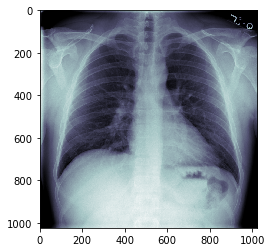

In [32]:
clf_dataset.show(apply_transforms=1)

### write engine.py
- it will have train function
- eval function

In [33]:
# engine.py
import torch
import torch.nn as nn
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, device, criterion=nn.BCEWithLogitsLoss(), scheduler=None):
    # set the model in train mode
    model.train()
        
    for images, targets in tqdm(dataloader, total = len(dataloader), desc="Train"): # returns batch of data every iteration

        images = images.to(device)
        targets = targets.to(device)
      
        # zero out the gradients so that they do not accumulate (default behaviour) in successive passes
        optimizer.zero_grad()
      
        # forward pass
        op = model(images)
        # compute loss
        loss = criterion(op, targets.view(-1,1))         
      
        # run backward pass
        loss.backward()
        # update optimizer
        optimizer.step() 
        
    # step the schedure if enabled
    if scheduler is not None:
        scheduler.step()     
            
def evaluate(model, dataloader, device):
    # set the model in eval mode
    model.eval()
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad(): # no gradient in this graph since it is for eval
        for images, targets in tqdm(dataloader, total = len(dataloader), desc="Eval"):
            images = images.to(device)
                       
            # forward pass
            op = model(images)
            
            #  convert targets and op to list
            targets = targets.cpu().numpy().tolist()
            op = op.cpu().numpy().tolist()
            
            # append
            final_targets.extend(targets)
            final_outputs.extend(op)
            
    return final_targets, final_outputs
      

### write model.py

In [34]:
# model.py
import pretrainedmodels
import torch.nn as nn

def get_model(pretrained, model_name):
    if pretrained:
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')        
    else:
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
        
    # replace the classification layers
    model.last_linear = nn.Sequential(nn.Linear(512, 128, bias=False),
                                      nn.BatchNorm1d(128),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(128, 1)
                                      )
    return model

In [35]:
model = get_model(pretrained=True, model_name="resnet18")

In [36]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### write train.py (main function)

In [37]:
import os
import pandas as pd
import albumentations as A
import torch
from torch.utils.data import DataLoader

from sklearn import metrics

# read the dataframe
train_df_clf_folds = pd.read_csv('../input/train_clf_folds.csv')
num_folds = len(train_df_clf_folds["kfolds"].unique())

# set the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model
model = get_model(pretrained=True, model_name="resnet18")
model.to(device)

# set transforms and albumentations
transforms = Compose([ToTensor()])
# these mean and std comes from imagenet dataset since we are pretrained model on imagenet dataset
mean = model.mean # give means for all channels for pretrained model
std = model.std # give means for all channels for pretrained model
input_range = model.input_range # gives [minval, maxval] for pixel for pretrained model

aug = A.Compose([
    A.Resize(model.input_size[1], model.input_size[2]),
    A.Normalize(mean, std, max_pixel_value=input_range[1], always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])


# set the learning rate and epochs
lr = 1e-3
epochs = 20
bs = 16

# setting optimizer
params = [p for p in  model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)

# and a learning rate scheduler which decreases the learning rate by
# 0.5x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

for foldno in range(num_folds):
    
    train_df = train_df_clf_folds[train_df_clf_folds["kfolds"] != foldno].reset_index(drop=True)
    val_df = train_df_clf_folds[train_df_clf_folds["kfolds"] == foldno].reset_index(drop=True)
    
    train_image_paths = train_df["path"].values.tolist() # convert to list since it is string 
    val_image_paths = val_df["path"].values.tolist() # convert to list since it is string 
    
    train_targets = train_df["class"].values # no need to convert to list since it a numpy array
    val_targets = val_df["class"].values # no need to convert to list since it a numpy array
    
    clf_train_dataset = ClassificationDataset(train_image_paths, train_targets, dcm=1, \
                                              augmentations=aug, transforms=transforms)
    
    clf_val_dataset = ClassificationDataset(val_image_paths, val_targets, dcm=1, \
                                              augmentations=aug, transforms=transforms)
    
    for epoch in range(epochs):
        train_dataloader = DataLoader(clf_train_dataset, batch_size=bs, shuffle=False)
        val_dataloader = DataLoader(clf_val_dataset, batch_size=bs, shuffle=False)

        train_one_epoch(model, train_dataloader, optimizer, device, criterion=nn.BCEWithLogitsLoss())
        
        # step the scheduler
        lr_scheduler.step()

        final_targets, final_output = evaluate(model, val_dataloader, device)

        auc = metrics.roc_auc_score(final_targets, final_output)

        print(f"foldno:{foldno}, Epoch:{epoch}, AUC:{auc:.4f}")




Train:   0%|                                                                                   | 0/445 [00:00<?, ?it/s]


Train:   0%|▏                                                                          | 1/445 [00:03<22:59,  3.11s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<23:11,  3.14s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<23:30,  3.19s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<23:15,  3.17s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<23:10,  3.16s/it]


Train:   1%|█                                                                          | 6/445 [00:19<23:08,  3.16s/it]


Train:   2%|█▏                                                                         | 7/445 [00:22<22:40,  3.11s/it]


Train:   2%|█▎       

Train:  14%|██████████▎                                                               | 62/445 [03:11<20:22,  3.19s/it]


Train:  14%|██████████▍                                                               | 63/445 [03:15<20:04,  3.15s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:18<20:01,  3.15s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:21<19:57,  3.15s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:24<20:04,  3.18s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:27<19:51,  3.15s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:30<19:27,  3.10s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:33<19:10,  3.06s/it]


Train:  16%|███████████▋

Train:  28%|████████████████████▎                                                    | 124/445 [06:51<21:00,  3.93s/it]


Train:  28%|████████████████████▌                                                    | 125/445 [06:54<19:32,  3.67s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [06:59<20:20,  3.83s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:02<19:59,  3.77s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:06<19:13,  3.64s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:10<20:21,  3.86s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:14<20:17,  3.86s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:17<19:10,  3.66s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▌                                          | 186/445 [10:16<15:13,  3.53s/it]


Train:  42%|██████████████████████████████▋                                          | 187/445 [10:19<15:22,  3.57s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [10:23<15:11,  3.55s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [10:26<14:51,  3.48s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [10:30<14:45,  3.47s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [10:33<14:34,  3.44s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [10:36<14:21,  3.41s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [10:40<14:16,  3.40s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▋                                | 248/445 [13:52<11:40,  3.55s/it]


Train:  56%|████████████████████████████████████████▊                                | 249/445 [13:56<11:19,  3.47s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [14:00<11:57,  3.68s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [14:04<12:18,  3.81s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [14:08<12:14,  3.81s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [14:11<11:46,  3.68s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [14:15<12:15,  3.85s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [14:19<11:39,  3.68s/it]


Train:  58%|████████████

Train:  70%|██████████████████████████████████████████████████▊                      | 310/445 [17:23<07:29,  3.33s/it]


Train:  70%|███████████████████████████████████████████████████                      | 311/445 [17:27<07:37,  3.41s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [17:30<07:21,  3.32s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [17:33<07:10,  3.26s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [17:36<07:00,  3.21s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [17:39<06:51,  3.16s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [17:42<06:54,  3.21s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [17:46<06:44,  3.16s/it]


Train:  71%|████████████

Train:  84%|█████████████████████████████████████████████████████████████            | 372/445 [20:38<04:02,  3.32s/it]


Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [20:42<03:55,  3.28s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [20:45<03:51,  3.26s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [20:48<03:45,  3.23s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [20:51<03:40,  3.19s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [20:54<03:37,  3.20s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [20:57<03:30,  3.14s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [21:00<03:25,  3.11s/it]


Train:  85%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▏ | 434/445 [23:52<00:35,  3.25s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [23:55<00:32,  3.24s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [23:58<00:29,  3.27s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [24:02<00:26,  3.27s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [24:05<00:22,  3.26s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [24:08<00:19,  3.28s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [24:12<00:16,  3.26s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [24:15<00:13,  3.26s/it]


Train:  99%|████████████

Eval:  22%|████████████████▊                                                          | 50/223 [02:27<08:16,  2.87s/it]


Eval:  23%|█████████████████▏                                                         | 51/223 [02:30<08:16,  2.89s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:33<08:16,  2.91s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:36<08:11,  2.89s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:39<08:05,  2.88s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:42<08:04,  2.88s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:44<07:57,  2.86s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:47<07:59,  2.89s/it]


Eval:  26%|█████████████

Eval:  50%|█████████████████████████████████████▏                                    | 112/223 [05:30<05:27,  2.95s/it]


Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:33<05:20,  2.91s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:36<05:22,  2.96s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:39<05:26,  3.03s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:42<05:16,  2.96s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:44<05:10,  2.93s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:47<05:08,  2.94s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:50<05:05,  2.94s/it]


Eval:  54%|█████████████

Eval:  78%|█████████████████████████████████████████████████████████▋                | 174/223 [08:36<02:38,  3.24s/it]


Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [08:40<02:43,  3.41s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [08:43<02:41,  3.44s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [08:46<02:36,  3.39s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [08:49<02:29,  3.33s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [08:53<02:29,  3.40s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [08:56<02:22,  3.32s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [08:59<02:17,  3.28s/it]


Eval:  82%|█████████████

foldno:0, Epoch:0, AUC:0.5150





Train:   0%|▏                                                                          | 1/445 [00:02<22:06,  2.99s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<22:22,  3.03s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<22:23,  3.04s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<22:15,  3.03s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<22:00,  3.00s/it]


Train:   1%|█                                                                          | 6/445 [00:18<21:47,  2.98s/it]


Train:   2%|█▏                                                                         | 7/445 [00:21<22:02,  3.02s/it]


Train:   2%|█▎                                                                         | 8/445 [00:24<21:48,  2.99s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:07<18:03,  2.84s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:09<18:00,  2.84s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:12<18:01,  2.85s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:15<17:55,  2.84s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:18<17:45,  2.82s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:21<17:36,  2.80s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:24<17:49,  2.84s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:26<17:51,  2.86s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [06:09<15:31,  2.91s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [06:12<15:20,  2.89s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [06:15<15:27,  2.92s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [06:18<15:21,  2.91s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:20<15:04,  2.86s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:23<14:50,  2.83s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:26<14:58,  2.86s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:29<15:09,  2.91s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [09:19<13:31,  3.14s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [09:22<13:10,  3.08s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [09:25<12:49,  3.01s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [09:27<12:30,  2.94s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [09:30<12:22,  2.92s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [09:33<12:21,  2.93s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [09:36<12:10,  2.90s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:39<12:10,  2.91s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [12:20<09:30,  2.91s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [12:23<09:30,  2.93s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [12:26<09:25,  2.91s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [12:28<09:11,  2.86s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [12:31<09:07,  2.85s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [12:34<09:12,  2.89s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [12:37<09:06,  2.88s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [12:40<08:59,  2.85s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [15:20<06:21,  2.85s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [15:22<06:12,  2.80s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [15:25<06:12,  2.82s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [15:28<06:10,  2.83s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [15:31<06:10,  2.85s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [15:34<06:06,  2.84s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [15:37<06:05,  2.85s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [15:39<06:03,  2.87s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [18:21<03:45,  3.13s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [18:24<03:43,  3.15s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [18:27<03:39,  3.13s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [18:30<03:36,  3.14s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [18:33<03:33,  3.13s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [18:36<03:29,  3.13s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [18:40<03:25,  3.12s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [18:43<03:20,  3.09s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [21:24<00:29,  2.91s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [21:27<00:25,  2.86s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [21:30<00:23,  2.88s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [21:33<00:19,  2.83s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [21:36<00:17,  2.84s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [21:38<00:14,  2.86s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [21:41<00:11,  2.87s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [21:45<00:08,  3.00s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:23<08:20,  2.91s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:26<08:24,  2.95s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:29<08:31,  3.01s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:32<08:29,  3.01s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:35<08:21,  2.98s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:38<08:08,  2.93s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:40<08:03,  2.91s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:43<08:00,  2.91s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:12<04:56,  2.69s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:14<04:51,  2.67s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:17<04:46,  2.65s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:20<04:47,  2.69s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:22<04:43,  2.67s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:25<04:41,  2.68s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:28<04:37,  2.67s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:30<04:36,  2.68s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [08:11<02:21,  2.95s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [08:14<02:20,  2.98s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [08:17<02:15,  2.95s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [08:19<02:08,  2.86s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [08:22<02:02,  2.78s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [08:25<01:58,  2.76s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [08:27<01:55,  2.75s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:30<01:51,  2.73s/it]


Eval:  82%|█████████████

foldno:0, Epoch:1, AUC:0.6956





Train:   0%|▏                                                                          | 1/445 [00:03<23:19,  3.15s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<22:52,  3.10s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<22:59,  3.12s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<22:52,  3.11s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<22:36,  3.08s/it]


Train:   1%|█                                                                          | 6/445 [00:18<22:16,  3.04s/it]


Train:   2%|█▏                                                                         | 7/445 [00:21<22:18,  3.06s/it]


Train:   2%|█▎                                                                         | 8/445 [00:24<22:14,  3.05s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [04:02<21:42,  3.41s/it]


Train:  14%|██████████▋                                                               | 64/445 [04:05<21:31,  3.39s/it]


Train:  15%|██████████▊                                                               | 65/445 [04:08<21:17,  3.36s/it]


Train:  15%|██████████▉                                                               | 66/445 [04:12<21:36,  3.42s/it]


Train:  15%|███████████▏                                                              | 67/445 [04:15<21:17,  3.38s/it]


Train:  15%|███████████▎                                                              | 68/445 [04:19<21:36,  3.44s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:22<21:32,  3.44s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:25<21:17,  3.41s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:45<18:07,  3.40s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:48<17:37,  3.31s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:51<17:16,  3.26s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:54<16:51,  3.19s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:58<16:41,  3.17s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [08:01<16:25,  3.13s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [08:04<16:08,  3.09s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [08:07<15:51,  3.04s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [11:00<13:11,  3.07s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [11:03<13:00,  3.04s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [11:06<12:57,  3.04s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [11:09<12:54,  3.04s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [11:12<12:58,  3.06s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [11:15<12:47,  3.03s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [11:18<13:02,  3.11s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [11:21<12:52,  3.08s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [14:30<10:52,  3.33s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [14:33<10:32,  3.24s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [14:36<10:20,  3.20s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [14:39<10:48,  3.36s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [14:43<10:40,  3.34s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [14:46<10:36,  3.33s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [14:49<10:33,  3.34s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [14:53<10:30,  3.34s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [17:59<07:46,  3.48s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [18:03<07:51,  3.54s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [18:07<08:16,  3.76s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [18:11<08:15,  3.79s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [18:15<08:04,  3.72s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [18:18<07:48,  3.63s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [18:22<07:51,  3.68s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [18:26<07:46,  3.67s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [21:35<04:10,  3.47s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [21:39<04:29,  3.80s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [21:44<04:44,  4.07s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [21:47<04:29,  3.90s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [21:51<04:18,  3.80s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [21:55<04:09,  3.72s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [21:58<04:07,  3.75s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [22:02<04:04,  3.77s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [25:12<00:31,  3.14s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [25:15<00:28,  3.12s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [25:18<00:25,  3.23s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [25:21<00:22,  3.20s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [25:25<00:18,  3.16s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [25:28<00:15,  3.17s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [25:31<00:12,  3.18s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [25:34<00:09,  3.21s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:54<08:39,  3.02s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:56<08:25,  2.96s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:59<08:16,  2.92s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [03:02<08:03,  2.86s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [03:05<08:08,  2.91s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [03:08<08:02,  2.89s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [03:11<08:06,  2.93s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [03:14<08:18,  3.02s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [06:12<06:08,  3.35s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [06:17<06:37,  3.65s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [06:21<06:42,  3.73s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [06:24<06:17,  3.52s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:27<05:59,  3.40s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [06:30<05:49,  3.33s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [06:33<05:40,  3.27s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [06:37<05:41,  3.32s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [09:40<02:49,  3.53s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [09:43<02:39,  3.40s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [09:47<02:44,  3.58s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [09:50<02:34,  3.43s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [09:54<02:27,  3.35s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [09:58<02:41,  3.75s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [10:02<02:39,  3.79s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [10:06<02:29,  3.65s/it]


Eval:  82%|█████████████

foldno:0, Epoch:2, AUC:0.4750





Train:   0%|▏                                                                          | 1/445 [00:02<21:51,  2.95s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<22:04,  2.99s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<23:18,  3.16s/it]


Train:   1%|▋                                                                          | 4/445 [00:13<24:02,  3.27s/it]


Train:   1%|▊                                                                          | 5/445 [00:16<23:28,  3.20s/it]


Train:   1%|█                                                                          | 6/445 [00:19<24:13,  3.31s/it]


Train:   2%|█▏                                                                         | 7/445 [00:23<25:24,  3.48s/it]


Train:   2%|█▎                                                                         | 8/445 [00:27<25:14,  3.46s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:31<19:28,  3.06s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:34<19:29,  3.07s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:37<19:21,  3.06s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:40<19:12,  3.04s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:43<18:47,  2.98s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:46<18:46,  2.99s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:49<18:32,  2.96s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:52<18:18,  2.93s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [06:41<17:18,  3.24s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [06:45<17:43,  3.33s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [06:49<18:18,  3.45s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [06:53<20:00,  3.79s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:57<20:32,  3.90s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:02<20:56,  3.99s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:05<20:38,  3.94s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [07:09<20:18,  3.89s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [10:50<15:26,  3.59s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [10:53<14:53,  3.48s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [10:56<14:51,  3.48s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [11:00<14:29,  3.41s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [11:03<14:19,  3.38s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [11:06<14:03,  3.33s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [11:09<13:53,  3.31s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [11:13<14:32,  3.48s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [14:42<12:28,  3.82s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [14:46<12:14,  3.76s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [14:49<11:58,  3.70s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [14:53<11:29,  3.57s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [14:56<11:05,  3.46s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [14:59<10:52,  3.41s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [15:02<10:35,  3.35s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [15:06<10:29,  3.33s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [18:13<08:03,  3.61s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [18:16<07:54,  3.57s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [18:19<07:42,  3.50s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [18:23<07:40,  3.51s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [18:27<07:39,  3.53s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [18:30<07:23,  3.44s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [18:33<07:10,  3.36s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [18:36<07:07,  3.37s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [21:36<04:06,  3.43s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [21:40<04:06,  3.47s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [21:43<04:00,  3.44s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [21:47<03:58,  3.45s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [21:50<03:55,  3.46s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [21:54<03:49,  3.42s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [21:57<03:44,  3.40s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [22:00<03:37,  3.35s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [24:57<00:34,  3.48s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [25:00<00:31,  3.53s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [25:04<00:28,  3.59s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [25:08<00:25,  3.67s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [25:11<00:21,  3.64s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [25:15<00:18,  3.63s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [25:18<00:14,  3.58s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [25:22<00:10,  3.55s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:33<08:42,  3.04s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:36<08:38,  3.03s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:39<08:33,  3.02s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:42<08:26,  2.99s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:45<08:28,  3.03s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:48<08:22,  3.01s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:51<08:19,  3.01s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:54<08:17,  3.01s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:48<05:35,  3.05s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:51<05:30,  3.03s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:54<05:20,  2.96s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:57<05:18,  2.98s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:00<05:17,  3.00s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [06:03<05:04,  2.90s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [06:06<05:00,  2.89s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [06:08<04:56,  2.88s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [08:47<02:11,  2.74s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [08:50<02:08,  2.74s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [08:53<02:09,  2.82s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [08:56<02:12,  2.95s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [08:59<02:10,  2.97s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [09:02<02:06,  2.95s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [09:05<02:03,  2.94s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [09:08<01:58,  2.90s/it]


Eval:  82%|█████████████

foldno:0, Epoch:3, AUC:0.5741





Train:   0%|▏                                                                          | 1/445 [00:03<22:45,  3.08s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<22:53,  3.10s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<23:19,  3.17s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<23:05,  3.14s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<23:25,  3.19s/it]


Train:   1%|█                                                                          | 6/445 [00:19<23:37,  3.23s/it]


Train:   2%|█▏                                                                         | 7/445 [00:23<24:58,  3.42s/it]


Train:   2%|█▎                                                                         | 8/445 [00:27<26:00,  3.57s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:48<22:17,  3.50s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:51<22:06,  3.48s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:55<21:49,  3.45s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:59<23:00,  3.64s/it]


Train:  15%|███████████▏                                                              | 67/445 [04:03<23:35,  3.74s/it]


Train:  15%|███████████▎                                                              | 68/445 [04:07<24:22,  3.88s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:10<23:15,  3.71s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:15<25:00,  4.00s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:35<18:12,  3.41s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:38<17:40,  3.32s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:41<17:21,  3.27s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:45<17:25,  3.30s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:48<17:05,  3.25s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:51<16:49,  3.20s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:54<16:38,  3.18s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [07:59<18:50,  3.61s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [11:19<15:35,  3.63s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [11:22<15:36,  3.64s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [11:26<15:39,  3.67s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [11:30<16:25,  3.86s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [11:34<15:50,  3.74s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [11:39<17:11,  4.08s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [11:44<18:58,  4.52s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [11:50<20:44,  4.96s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [15:25<10:45,  3.29s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [15:28<10:39,  3.28s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [15:31<10:33,  3.27s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [15:34<10:16,  3.20s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [15:37<10:22,  3.24s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [15:40<10:07,  3.18s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [15:43<09:56,  3.14s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [15:47<09:52,  3.13s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [18:50<07:41,  3.44s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [18:53<07:34,  3.42s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [18:56<07:30,  3.41s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [19:00<07:39,  3.51s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [19:03<07:25,  3.43s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [19:06<07:08,  3.32s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [19:10<07:08,  3.34s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [19:13<07:14,  3.42s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [22:42<04:19,  3.61s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [22:45<04:14,  3.59s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [22:49<04:13,  3.62s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [22:54<04:34,  3.97s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [22:58<04:41,  4.14s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [23:02<04:24,  3.95s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [23:05<04:14,  3.86s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [23:09<04:02,  3.73s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [26:34<00:34,  3.43s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [26:38<00:31,  3.51s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [26:41<00:28,  3.52s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [26:45<00:24,  3.47s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [26:48<00:20,  3.46s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [26:51<00:17,  3.42s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [26:55<00:13,  3.36s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [26:58<00:10,  3.36s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [04:44<28:27,  9.93s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [04:50<24:59,  8.77s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [04:56<22:51,  8.07s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [05:00<18:59,  6.74s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [05:03<16:15,  5.81s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [05:07<14:24,  5.18s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [05:12<14:31,  5.25s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [05:17<13:54,  5.05s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [08:42<07:46,  4.25s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [08:47<08:11,  4.51s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [08:50<07:21,  4.09s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [08:55<07:20,  4.12s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [08:58<06:45,  3.83s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [09:02<07:04,  4.04s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [09:06<06:37,  3.82s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [09:11<07:12,  4.20s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [12:27<02:57,  3.70s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [12:30<02:44,  3.49s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [12:33<02:34,  3.36s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [12:37<02:37,  3.50s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [12:40<02:25,  3.31s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [12:43<02:19,  3.25s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [12:46<02:13,  3.18s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [12:49<02:09,  3.15s/it]


Eval:  82%|█████████████

foldno:0, Epoch:4, AUC:0.6324





Train:   0%|▏                                                                          | 1/445 [00:03<24:10,  3.27s/it]


Train:   0%|▎                                                                          | 2/445 [00:07<26:31,  3.59s/it]


Train:   1%|▌                                                                          | 3/445 [00:11<27:13,  3.70s/it]


Train:   1%|▋                                                                          | 4/445 [00:15<27:13,  3.70s/it]


Train:   1%|▊                                                                          | 5/445 [00:19<28:06,  3.83s/it]


Train:   1%|█                                                                          | 6/445 [00:22<27:21,  3.74s/it]


Train:   2%|█▏                                                                         | 7/445 [00:26<27:22,  3.75s/it]


Train:   2%|█▎                                                                         | 8/445 [00:30<27:08,  3.73s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:57<23:06,  3.63s/it]


Train:  14%|██████████▋                                                               | 64/445 [04:00<22:10,  3.49s/it]


Train:  15%|██████████▊                                                               | 65/445 [04:04<21:54,  3.46s/it]


Train:  15%|██████████▉                                                               | 66/445 [04:07<21:22,  3.39s/it]


Train:  15%|███████████▏                                                              | 67/445 [04:10<20:58,  3.33s/it]


Train:  15%|███████████▎                                                              | 68/445 [04:14<20:54,  3.33s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:17<20:58,  3.35s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:20<21:08,  3.38s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:36<21:02,  3.94s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:39<20:49,  3.92s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:43<20:26,  3.86s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:46<19:41,  3.73s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:50<18:54,  3.59s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:53<19:00,  3.62s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:58<19:50,  3.79s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [08:02<20:05,  3.85s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [11:15<13:03,  3.04s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [11:17<12:46,  2.98s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [11:21<12:51,  3.01s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [11:24<12:51,  3.03s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [11:27<12:48,  3.02s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [11:29<12:35,  2.99s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [11:32<12:23,  2.95s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [11:35<12:24,  2.97s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [14:23<09:28,  2.90s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [14:26<09:28,  2.92s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [14:29<09:22,  2.90s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [14:32<09:18,  2.89s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [14:35<09:18,  2.91s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [14:37<09:15,  2.91s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [14:40<09:16,  2.93s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [14:43<09:12,  2.92s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [17:38<07:06,  3.19s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [17:41<06:54,  3.12s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [17:44<06:48,  3.10s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [17:47<06:50,  3.13s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [17:51<06:48,  3.14s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [17:54<06:42,  3.12s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [17:57<06:37,  3.11s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [18:00<06:32,  3.09s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [21:07<04:07,  3.44s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [21:10<03:58,  3.36s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [21:13<03:54,  3.35s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [21:17<03:53,  3.38s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [21:21<04:00,  3.54s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [21:24<03:54,  3.50s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [21:27<03:47,  3.45s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [21:31<03:43,  3.44s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [24:29<00:32,  3.26s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [24:32<00:28,  3.18s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [24:35<00:24,  3.10s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [24:38<00:21,  3.11s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [24:41<00:19,  3.18s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [24:44<00:15,  3.15s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [24:47<00:12,  3.08s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [24:50<00:09,  3.05s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:34<09:00,  3.14s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:37<08:51,  3.11s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:40<08:34,  3.03s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:43<08:19,  2.95s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:46<08:22,  2.99s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:49<08:37,  3.10s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:52<08:37,  3.12s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:56<08:48,  3.21s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:50<05:36,  3.06s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:53<05:39,  3.11s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:56<05:29,  3.05s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:58<05:14,  2.93s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:01<05:06,  2.89s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [06:04<04:59,  2.85s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [06:07<04:56,  2.85s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [06:10<04:50,  2.82s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [08:44<02:14,  2.79s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [08:47<02:10,  2.78s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [08:49<02:07,  2.77s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [08:52<02:05,  2.78s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [08:55<02:02,  2.78s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [08:58<01:58,  2.75s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [09:00<01:55,  2.75s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [09:03<01:53,  2.76s/it]


Eval:  82%|█████████████

foldno:0, Epoch:5, AUC:0.5789





Train:   0%|▏                                                                          | 1/445 [00:02<21:56,  2.97s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<22:11,  3.01s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<22:07,  3.00s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<22:11,  3.02s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<22:08,  3.02s/it]


Train:   1%|█                                                                          | 6/445 [00:18<22:11,  3.03s/it]


Train:   2%|█▏                                                                         | 7/445 [00:21<22:13,  3.05s/it]


Train:   2%|█▎                                                                         | 8/445 [00:24<22:10,  3.05s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:55<22:15,  3.50s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:58<21:36,  3.40s/it]


Train:  15%|██████████▊                                                               | 65/445 [04:03<23:03,  3.64s/it]


Train:  15%|██████████▉                                                               | 66/445 [04:07<24:30,  3.88s/it]


Train:  15%|███████████▏                                                              | 67/445 [04:10<22:49,  3.62s/it]


Train:  15%|███████████▎                                                              | 68/445 [04:15<24:33,  3.91s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:19<25:01,  3.99s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:22<23:45,  3.80s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:35<18:30,  3.47s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:38<18:32,  3.49s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:42<18:39,  3.52s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:46<18:57,  3.59s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:51<22:18,  4.23s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:55<20:57,  3.99s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:59<21:18,  4.07s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [08:03<20:31,  3.93s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [11:40<17:56,  4.17s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [11:44<17:21,  4.05s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [11:49<18:23,  4.31s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [11:52<17:27,  4.11s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [11:57<17:22,  4.11s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [12:00<16:29,  3.91s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [12:05<17:10,  4.09s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [12:08<16:44,  4.00s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [15:22<10:07,  3.10s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [15:25<10:08,  3.12s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [15:28<10:06,  3.13s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [15:31<10:06,  3.14s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [15:34<10:03,  3.14s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [15:37<09:56,  3.12s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [15:40<09:47,  3.09s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [15:43<09:45,  3.10s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [18:46<07:07,  3.19s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [18:49<07:02,  3.17s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [18:53<07:02,  3.20s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [18:56<07:19,  3.36s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [19:00<07:15,  3.35s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [19:03<07:13,  3.36s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [19:06<07:09,  3.35s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [19:10<07:07,  3.37s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [22:21<04:02,  3.36s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [22:25<03:55,  3.32s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [22:28<03:51,  3.31s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [22:31<03:47,  3.30s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [22:34<03:45,  3.32s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [22:38<03:41,  3.31s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [22:41<03:40,  3.34s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [22:44<03:35,  3.31s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [25:58<00:40,  4.08s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [26:01<00:34,  3.88s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [26:05<00:31,  3.97s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [26:09<00:26,  3.76s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [26:12<00:22,  3.67s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [26:16<00:18,  3.61s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [26:19<00:14,  3.62s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [26:23<00:10,  3.58s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:44<10:50,  3.78s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:48<10:48,  3.79s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:53<11:32,  4.07s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:57<11:09,  3.96s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [03:01<11:30,  4.11s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [03:05<10:54,  3.92s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [03:09<11:03,  4.00s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [03:13<10:52,  3.96s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [06:03<05:49,  3.17s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [06:06<05:49,  3.20s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [06:10<06:02,  3.35s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [06:13<05:58,  3.35s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:17<06:05,  3.45s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [06:21<06:12,  3.55s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [06:24<06:05,  3.52s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [06:28<06:05,  3.55s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [09:56<03:00,  3.75s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [09:59<02:51,  3.64s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [10:03<02:43,  3.55s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [10:06<02:36,  3.47s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [10:09<02:30,  3.43s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [10:13<02:26,  3.42s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [10:16<02:23,  3.41s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [10:19<02:18,  3.38s/it]


Eval:  82%|█████████████

foldno:0, Epoch:6, AUC:0.6010





Train:   0%|▏                                                                          | 1/445 [00:03<24:18,  3.28s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<24:51,  3.37s/it]


Train:   1%|▌                                                                          | 3/445 [00:10<24:41,  3.35s/it]


Train:   1%|▋                                                                          | 4/445 [00:14<25:57,  3.53s/it]


Train:   1%|▊                                                                          | 5/445 [00:18<27:02,  3.69s/it]


Train:   1%|█                                                                          | 6/445 [00:21<27:13,  3.72s/it]


Train:   2%|█▏                                                                         | 7/445 [00:25<27:48,  3.81s/it]


Train:   2%|█▎                                                                         | 8/445 [00:29<28:10,  3.87s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:42<21:18,  3.35s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:45<21:23,  3.37s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:49<21:24,  3.38s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:52<21:16,  3.37s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:56<21:10,  3.36s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:59<21:13,  3.38s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:02<21:08,  3.37s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:06<20:48,  3.33s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:03<15:26,  2.90s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:06<15:31,  2.92s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:09<15:34,  2.94s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:12<15:28,  2.93s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:15<15:18,  2.91s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:18<16:40,  3.18s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:22<16:51,  3.22s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [07:26<18:24,  3.53s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [10:09<12:26,  2.89s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [10:12<12:20,  2.88s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [10:15<12:15,  2.87s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [10:17<12:06,  2.85s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [10:20<12:02,  2.84s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [10:23<12:08,  2.88s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [10:26<12:07,  2.89s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [10:29<12:00,  2.87s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [13:30<11:15,  3.45s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [13:33<10:57,  3.37s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [13:37<10:50,  3.35s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [13:42<12:39,  3.94s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [13:45<11:57,  3.74s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [13:49<11:47,  3.71s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [13:52<11:29,  3.63s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [13:56<11:17,  3.59s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [16:54<07:16,  3.26s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [16:57<07:13,  3.26s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [17:01<07:11,  3.27s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [17:04<07:07,  3.26s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [17:07<07:02,  3.25s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [17:10<06:50,  3.18s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [17:13<06:42,  3.14s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [17:17<06:43,  3.18s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [20:12<03:56,  3.28s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [20:15<03:42,  3.14s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [20:18<03:41,  3.17s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [20:22<03:38,  3.17s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [20:24<03:30,  3.09s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [20:28<03:30,  3.14s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [20:32<03:42,  3.37s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [20:36<04:02,  3.74s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [23:43<00:33,  3.33s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [23:46<00:29,  3.32s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [23:50<00:27,  3.44s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [23:53<00:23,  3.43s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [23:56<00:20,  3.35s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [24:00<00:17,  3.43s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [24:03<00:13,  3.39s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [24:07<00:10,  3.42s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:42<10:20,  3.61s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:46<09:51,  3.46s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:49<09:28,  3.34s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:52<09:10,  3.26s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:55<08:54,  3.18s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:59<10:13,  3.68s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [03:02<09:33,  3.46s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [03:05<09:03,  3.29s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [06:17<05:34,  3.05s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [06:20<05:36,  3.08s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [06:24<05:41,  3.16s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [06:27<05:42,  3.20s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:30<05:36,  3.18s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [06:33<05:27,  3.12s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [06:37<05:37,  3.24s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [06:40<05:32,  3.22s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [09:35<02:36,  3.26s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [09:38<02:29,  3.18s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [09:41<02:23,  3.12s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [09:44<02:20,  3.12s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [09:47<02:18,  3.15s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [09:50<02:14,  3.14s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [09:53<02:09,  3.07s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [09:57<02:06,  3.08s/it]


Eval:  82%|█████████████

foldno:0, Epoch:7, AUC:0.6980





Train:   0%|▏                                                                          | 1/445 [00:03<26:35,  3.59s/it]


Train:   0%|▎                                                                          | 2/445 [00:07<26:21,  3.57s/it]


Train:   1%|▌                                                                          | 3/445 [00:10<26:21,  3.58s/it]


Train:   1%|▋                                                                          | 4/445 [00:14<26:21,  3.59s/it]


Train:   1%|▊                                                                          | 5/445 [00:17<25:55,  3.54s/it]


Train:   1%|█                                                                          | 6/445 [00:21<25:54,  3.54s/it]


Train:   2%|█▏                                                                         | 7/445 [00:24<25:48,  3.54s/it]


Train:   2%|█▎                                                                         | 8/445 [00:28<25:14,  3.47s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:41<23:05,  3.63s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:44<22:45,  3.58s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:48<22:46,  3.60s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:51<22:13,  3.52s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:55<21:46,  3.46s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:58<21:16,  3.39s/it]


Train:  16%|███████████▍                                                              | 69/445 [04:01<20:49,  3.32s/it]


Train:  16%|███████████▋                                                              | 70/445 [04:04<21:04,  3.37s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:36<24:20,  4.57s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:40<24:23,  4.59s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:44<23:17,  4.39s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:49<24:00,  4.55s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:54<24:05,  4.58s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:58<22:48,  4.34s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [08:01<21:23,  4.09s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [08:05<20:02,  3.84s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [12:10<20:35,  4.79s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [12:14<19:59,  4.67s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [12:18<18:27,  4.33s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [12:22<18:40,  4.39s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [12:27<19:06,  4.51s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [12:32<19:04,  4.52s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [12:36<18:49,  4.48s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [12:42<20:21,  4.87s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [16:54<13:42,  4.19s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [16:59<14:05,  4.34s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [17:04<14:19,  4.43s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [17:08<14:33,  4.53s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [17:12<13:59,  4.37s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [17:17<14:04,  4.42s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [17:21<13:35,  4.29s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [17:25<12:56,  4.11s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [20:54<08:43,  3.91s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [20:59<08:59,  4.06s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [21:02<08:18,  3.77s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [21:05<07:52,  3.61s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [21:10<08:24,  3.88s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [21:14<08:54,  4.14s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [21:20<09:36,  4.50s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [21:24<09:25,  4.45s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [24:59<04:29,  3.75s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [25:03<04:23,  3.70s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [25:07<04:21,  3.74s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [25:11<04:17,  3.73s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [25:14<04:05,  3.62s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [25:17<03:59,  3.58s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [25:21<04:00,  3.64s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [25:25<03:59,  3.68s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [28:55<00:39,  3.99s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [28:58<00:34,  3.78s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [29:02<00:29,  3.74s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [29:05<00:25,  3.66s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [29:09<00:22,  3.73s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [29:13<00:19,  3.85s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [29:17<00:15,  3.85s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [29:21<00:11,  3.89s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [03:02<09:29,  3.31s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [03:05<09:13,  3.24s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [03:09<09:37,  3.40s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [03:12<09:16,  3.29s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [03:15<09:06,  3.25s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [03:18<08:57,  3.22s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [03:22<09:15,  3.34s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [03:25<09:19,  3.39s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [06:46<05:51,  3.19s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [06:49<05:54,  3.25s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [06:52<05:47,  3.22s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [06:55<05:38,  3.16s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [06:59<05:41,  3.22s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [07:05<07:17,  4.16s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [07:08<06:48,  3.93s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [07:12<06:20,  3.69s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [10:20<02:29,  3.10s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [10:23<02:22,  3.03s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [10:26<02:21,  3.09s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [10:30<02:22,  3.16s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [10:33<02:17,  3.13s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [10:36<02:17,  3.19s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [10:40<02:16,  3.25s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [10:42<02:09,  3.15s/it]


Eval:  82%|█████████████

foldno:0, Epoch:8, AUC:0.6353





Train:   0%|▏                                                                          | 1/445 [00:03<26:23,  3.57s/it]


Train:   0%|▎                                                                          | 2/445 [00:07<26:33,  3.60s/it]


Train:   1%|▌                                                                          | 3/445 [00:10<26:11,  3.56s/it]


Train:   1%|▋                                                                          | 4/445 [00:14<25:43,  3.50s/it]


Train:   1%|▊                                                                          | 5/445 [00:17<24:58,  3.41s/it]


Train:   1%|█                                                                          | 6/445 [00:20<25:33,  3.49s/it]


Train:   2%|█▏                                                                         | 7/445 [00:24<26:11,  3.59s/it]


Train:   2%|█▎                                                                         | 8/445 [00:28<25:59,  3.57s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:24<21:37,  3.40s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:27<21:27,  3.38s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:30<20:59,  3.31s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:33<20:27,  3.24s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:37<20:43,  3.29s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:40<20:14,  3.22s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:43<20:11,  3.22s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:46<19:52,  3.18s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [07:12<15:30,  2.91s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [07:15<15:25,  2.90s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [07:18<15:24,  2.91s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [07:21<15:26,  2.92s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [07:23<15:15,  2.90s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [07:26<15:17,  2.91s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [07:29<15:23,  2.94s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [07:32<15:39,  3.00s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [10:26<14:24,  3.35s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [10:29<14:09,  3.31s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [10:32<13:57,  3.27s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [10:36<13:45,  3.24s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [10:39<13:43,  3.24s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [10:42<13:39,  3.24s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [10:45<13:35,  3.24s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [10:48<13:31,  3.23s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [13:37<10:16,  3.15s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [13:41<10:31,  3.24s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [13:44<10:47,  3.34s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [13:48<10:40,  3.32s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [13:51<10:24,  3.25s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [13:54<10:12,  3.21s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [13:57<10:26,  3.30s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [14:01<10:27,  3.32s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [16:53<06:22,  2.85s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [16:55<06:14,  2.82s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [16:58<06:16,  2.85s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [17:01<06:08,  2.81s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [17:04<06:07,  2.83s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [17:07<06:08,  2.86s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [17:10<06:02,  2.83s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [17:12<05:58,  2.82s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [19:57<03:32,  2.95s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [20:00<03:30,  2.96s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [20:03<03:25,  2.94s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [20:05<03:21,  2.92s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [20:08<03:17,  2.91s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [20:11<03:14,  2.91s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [20:14<03:10,  2.88s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [20:17<03:06,  2.87s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [22:59<00:28,  2.89s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [23:01<00:25,  2.88s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [23:04<00:23,  2.89s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [23:07<00:19,  2.84s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [23:10<00:17,  2.88s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [23:13<00:14,  2.87s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [23:16<00:11,  2.87s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [23:19<00:08,  2.86s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:32<07:46,  2.71s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:34<07:43,  2.71s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:37<07:35,  2.68s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:40<07:33,  2.68s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:42<07:32,  2.69s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:45<07:23,  2.66s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:48<07:20,  2.65s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:50<07:21,  2.68s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:26<05:12,  2.84s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:29<05:03,  2.79s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:31<04:55,  2.74s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:34<04:52,  2.74s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:37<04:49,  2.73s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:40<04:57,  2.84s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:43<04:55,  2.84s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:45<04:50,  2.82s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [08:18<02:05,  2.62s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [08:20<02:03,  2.63s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [08:23<02:00,  2.63s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [08:26<01:57,  2.60s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [08:28<01:53,  2.58s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [08:31<01:52,  2.61s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [08:33<01:49,  2.60s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:36<01:47,  2.62s/it]


Eval:  82%|█████████████

foldno:0, Epoch:9, AUC:0.7825





Train:   0%|▏                                                                          | 1/445 [00:02<20:08,  2.72s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<20:01,  2.71s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:10,  2.74s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<20:18,  2.76s/it]


Train:   1%|▊                                                                          | 5/445 [00:13<20:21,  2.78s/it]


Train:   1%|█                                                                          | 6/445 [00:16<20:18,  2.78s/it]


Train:   2%|█▏                                                                         | 7/445 [00:19<20:12,  2.77s/it]


Train:   2%|█▎                                                                         | 8/445 [00:22<20:29,  2.81s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [03:08<17:38,  2.77s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:11<17:46,  2.80s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:14<17:34,  2.77s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:16<17:25,  2.76s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:19<17:23,  2.76s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:22<17:33,  2.79s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:25<17:20,  2.77s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:27<17:14,  2.76s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [06:18<16:02,  3.01s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [06:22<17:16,  3.25s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [06:25<17:22,  3.28s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [06:28<16:30,  3.12s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:31<15:54,  3.02s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:33<15:27,  2.94s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:36<15:03,  2.88s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:39<14:54,  2.86s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [09:30<13:51,  3.22s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [09:34<13:49,  3.23s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [09:37<13:40,  3.21s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [09:40<13:09,  3.09s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [09:42<12:42,  3.00s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [09:45<12:25,  2.94s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [09:48<12:08,  2.89s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:51<11:53,  2.84s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [12:31<08:56,  2.74s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [12:34<08:47,  2.70s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [12:37<08:51,  2.74s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [12:39<08:42,  2.71s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [12:42<08:45,  2.74s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [12:45<08:47,  2.76s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [12:48<08:40,  2.74s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [12:51<08:43,  2.77s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [15:25<06:15,  2.80s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [15:28<06:14,  2.81s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [15:31<06:08,  2.79s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [15:34<06:09,  2.82s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [15:37<06:04,  2.80s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [15:39<06:02,  2.81s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [15:42<05:55,  2.78s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [15:45<05:57,  2.81s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [18:20<03:29,  2.91s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [18:22<03:18,  2.79s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [18:25<03:14,  2.78s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [18:28<03:10,  2.75s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [18:30<03:07,  2.76s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [18:33<03:05,  2.76s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [18:36<03:03,  2.78s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [18:39<02:59,  2.76s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [21:14<00:30,  3.01s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [21:17<00:27,  3.01s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [21:20<00:24,  3.00s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [21:23<00:20,  2.97s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [21:26<00:17,  2.97s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [21:29<00:14,  2.96s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [21:32<00:11,  2.97s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [21:35<00:08,  2.99s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:11<07:23,  2.58s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:14<07:48,  2.74s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:17<07:40,  2.71s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:20<07:31,  2.67s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:22<07:19,  2.62s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:25<07:14,  2.60s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:28<07:46,  2.81s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:31<07:30,  2.73s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [04:52<04:40,  2.55s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [04:54<04:37,  2.55s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [04:57<04:35,  2.55s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [04:59<04:31,  2.54s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:02<04:31,  2.56s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:05<04:30,  2.58s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:07<04:28,  2.58s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:10<04:24,  2.57s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:33<02:04,  2.59s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:35<02:01,  2.58s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:39<02:06,  2.74s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:41<02:01,  2.69s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:44<01:55,  2.63s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:46<01:52,  2.63s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [07:49<01:48,  2.59s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [07:51<01:45,  2.57s/it]


Eval:  82%|█████████████

foldno:0, Epoch:10, AUC:0.7771





Train:   0%|▏                                                                          | 1/445 [00:03<23:04,  3.12s/it]


Train:   0%|▎                                                                          | 2/445 [00:06<23:00,  3.12s/it]


Train:   1%|▌                                                                          | 3/445 [00:09<22:52,  3.11s/it]


Train:   1%|▋                                                                          | 4/445 [00:12<22:40,  3.09s/it]


Train:   1%|▊                                                                          | 5/445 [00:15<22:16,  3.04s/it]


Train:   1%|█                                                                          | 6/445 [00:18<22:00,  3.01s/it]


Train:   2%|█▏                                                                         | 7/445 [00:21<21:30,  2.95s/it]


Train:   2%|█▎                                                                         | 8/445 [00:23<20:55,  2.87s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:56<17:33,  2.76s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:58<17:24,  2.74s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:01<17:23,  2.75s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:04<17:25,  2.76s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:07<17:21,  2.76s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:09<17:24,  2.77s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:12<17:15,  2.75s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:15<17:09,  2.75s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:47<14:52,  2.79s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:49<14:41,  2.76s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:52<14:34,  2.75s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:55<14:21,  2.72s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [05:58<14:18,  2.72s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:00<14:24,  2.75s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:03<14:16,  2.73s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:06<14:11,  2.72s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:37<11:39,  2.71s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:39<11:37,  2.72s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:42<11:43,  2.75s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:45<11:35,  2.73s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:47<11:30,  2.72s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [08:50<11:26,  2.71s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [08:53<11:41,  2.78s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [08:56<11:53,  2.84s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:37<09:00,  2.76s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:40<08:57,  2.76s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:43<08:58,  2.78s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:46<08:52,  2.76s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:48<08:45,  2.74s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:51<08:49,  2.77s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:54<08:46,  2.77s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [11:57<08:42,  2.77s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:35<06:12,  2.78s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:38<06:07,  2.76s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:40<06:05,  2.77s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:43<06:04,  2.78s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:46<05:57,  2.75s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [14:49<05:53,  2.74s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [14:51<05:48,  2.72s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [14:54<05:43,  2.70s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:26<03:20,  2.78s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:29<03:17,  2.78s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:32<03:11,  2.73s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:34<03:07,  2.71s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:37<03:05,  2.73s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:40<03:03,  2.74s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:43<03:01,  2.76s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:45<02:58,  2.74s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:22<00:28,  2.86s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:25<00:25,  2.84s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:27<00:22,  2.82s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:30<00:19,  2.85s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:33<00:16,  2.81s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:36<00:14,  2.86s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:39<00:11,  2.88s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:42<00:08,  2.80s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:13<07:40,  2.68s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:17<07:55,  2.78s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:19<07:58,  2.81s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:22<07:43,  2.74s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:25<07:39,  2.73s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:27<07:29,  2.69s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:30<07:18,  2.64s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:32<07:17,  2.65s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:02<05:14,  2.86s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:05<05:11,  2.85s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:08<05:13,  2.90s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:11<05:09,  2.90s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:14<05:02,  2.85s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:17<05:07,  2.93s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:20<04:58,  2.87s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:22<04:52,  2.84s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:43<02:02,  2.56s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:45<01:58,  2.53s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:48<01:56,  2.52s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:51<01:54,  2.54s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:53<01:51,  2.53s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:56<01:49,  2.55s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [07:58<01:46,  2.54s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:01<01:42,  2.51s/it]


Eval:  82%|█████████████

foldno:0, Epoch:11, AUC:0.7861





Train:   0%|▏                                                                          | 1/445 [00:02<21:16,  2.88s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<21:18,  2.89s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:54,  2.84s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<20:36,  2.80s/it]


Train:   1%|▊                                                                          | 5/445 [00:14<22:20,  3.05s/it]


Train:   1%|█                                                                          | 6/445 [00:17<21:35,  2.95s/it]


Train:   2%|█▏                                                                         | 7/445 [00:20<20:57,  2.87s/it]


Train:   2%|█▎                                                                         | 8/445 [00:22<20:32,  2.82s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:54<17:31,  2.75s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:57<17:33,  2.76s/it]


Train:  15%|██████████▊                                                               | 65/445 [02:59<17:31,  2.77s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:02<17:27,  2.76s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:05<17:20,  2.75s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:08<17:13,  2.74s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:10<17:19,  2.77s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:13<17:15,  2.76s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:46<14:39,  2.75s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:49<14:43,  2.77s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:52<14:40,  2.77s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:54<14:43,  2.79s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [05:57<14:34,  2.77s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:00<14:24,  2.75s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:02<14:13,  2.72s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:05<14:09,  2.71s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:40<12:56,  3.01s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:43<12:51,  3.00s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:46<12:46,  2.99s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:49<12:39,  2.98s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:52<12:47,  3.02s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [08:55<12:42,  3.01s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [08:58<12:36,  3.00s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:01<12:30,  2.99s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:39<09:17,  2.84s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:42<09:10,  2.83s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:45<09:06,  2.82s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:47<09:05,  2.83s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:50<08:58,  2.80s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:53<08:51,  2.78s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:56<08:44,  2.76s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [11:58<08:39,  2.75s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:36<06:22,  2.85s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:40<06:55,  3.13s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:43<06:35,  3.00s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:46<06:24,  2.93s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:48<06:15,  2.89s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [14:51<06:05,  2.84s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [14:54<06:00,  2.82s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [14:57<05:57,  2.81s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:31<03:28,  2.89s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:34<03:23,  2.86s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:37<03:20,  2.86s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:39<03:15,  2.84s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:42<03:11,  2.82s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:45<03:08,  2.81s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:48<03:04,  2.80s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:50<03:01,  2.79s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:29<00:27,  2.78s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:31<00:24,  2.76s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:34<00:21,  2.75s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:37<00:19,  2.80s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:40<00:16,  2.79s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:43<00:13,  2.78s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:45<00:11,  2.78s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:48<00:08,  2.79s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:12<07:24,  2.58s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:15<07:22,  2.59s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:17<07:27,  2.63s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:20<07:19,  2.60s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:22<07:16,  2.60s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:25<07:19,  2.63s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:28<07:19,  2.64s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:30<07:11,  2.62s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [04:55<04:46,  2.61s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [04:57<04:42,  2.59s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:00<04:41,  2.61s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:02<04:38,  2.61s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:05<04:32,  2.57s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:08<04:34,  2.61s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:10<04:29,  2.59s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:13<04:26,  2.59s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:40<02:33,  3.20s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:43<02:24,  3.08s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:46<02:18,  3.01s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:49<02:11,  2.93s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:52<02:08,  2.92s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:55<02:06,  2.95s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [07:58<02:03,  2.94s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:00<01:59,  2.91s/it]


Eval:  82%|█████████████

foldno:0, Epoch:12, AUC:0.8051





Train:   0%|▏                                                                          | 1/445 [00:02<21:12,  2.87s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<21:02,  2.85s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<21:27,  2.91s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<21:35,  2.94s/it]


Train:   1%|▊                                                                          | 5/445 [00:14<21:55,  2.99s/it]


Train:   1%|█                                                                          | 6/445 [00:17<22:02,  3.01s/it]


Train:   2%|█▏                                                                         | 7/445 [00:20<21:55,  3.00s/it]


Train:   2%|█▎                                                                         | 8/445 [00:23<21:53,  3.00s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:58<17:41,  2.78s/it]


Train:  14%|██████████▋                                                               | 64/445 [03:00<17:43,  2.79s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:03<17:46,  2.81s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:06<17:37,  2.79s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:09<17:58,  2.85s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:12<18:10,  2.89s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:15<17:49,  2.85s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:18<17:55,  2.87s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:52<14:40,  2.75s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:55<14:44,  2.77s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:58<14:36,  2.76s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [06:01<14:34,  2.76s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:03<14:26,  2.74s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:06<14:23,  2.74s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:10<15:31,  2.97s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:17<22:51,  4.38s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:58<11:44,  2.73s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [09:01<11:47,  2.75s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [09:04<12:15,  2.87s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [09:07<12:18,  2.90s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [09:10<12:05,  2.86s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [09:13<11:51,  2.81s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [09:15<11:49,  2.82s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:18<11:38,  2.78s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:55<09:11,  2.81s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:58<09:07,  2.81s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [12:00<09:03,  2.80s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [12:03<08:52,  2.76s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [12:06<08:45,  2.74s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [12:09<08:42,  2.73s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [12:11<08:39,  2.73s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [12:14<08:44,  2.77s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:47<06:10,  2.76s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:50<06:05,  2.75s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:52<05:56,  2.70s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:55<05:53,  2.69s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:58<05:47,  2.68s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [15:00<05:50,  2.72s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [15:03<05:49,  2.73s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [15:06<05:51,  2.77s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:38<03:29,  2.91s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:41<03:29,  2.95s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:44<03:26,  2.94s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:47<03:21,  2.92s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:50<03:20,  2.94s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:53<03:16,  2.93s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:56<03:13,  2.94s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:59<03:10,  2.94s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:35<00:27,  2.74s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:37<00:24,  2.73s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:40<00:22,  2.76s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:43<00:19,  2.75s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:46<00:16,  2.75s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:48<00:13,  2.75s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:51<00:10,  2.75s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:54<00:08,  2.75s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:11<07:18,  2.55s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:13<07:15,  2.55s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:16<07:11,  2.54s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:18<07:08,  2.54s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:21<07:09,  2.56s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:23<07:11,  2.58s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:26<07:08,  2.58s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:29<07:18,  2.66s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:01<05:11,  2.83s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:03<05:00,  2.76s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:06<04:51,  2.70s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:08<04:42,  2.64s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:11<04:38,  2.63s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:13<04:32,  2.60s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:16<04:26,  2.57s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:19<04:24,  2.57s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:46<02:08,  2.68s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:49<02:04,  2.66s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:52<02:01,  2.64s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:54<01:57,  2.61s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:57<01:54,  2.61s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:59<01:52,  2.61s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [08:02<01:48,  2.58s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:04<01:46,  2.59s/it]


Eval:  82%|█████████████

foldno:0, Epoch:13, AUC:0.8116





Train:   0%|▏                                                                          | 1/445 [00:02<20:17,  2.74s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<20:15,  2.74s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:20,  2.76s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<20:19,  2.76s/it]


Train:   1%|▊                                                                          | 5/445 [00:13<20:09,  2.75s/it]


Train:   1%|█                                                                          | 6/445 [00:16<20:05,  2.75s/it]


Train:   2%|█▏                                                                         | 7/445 [00:19<20:00,  2.74s/it]


Train:   2%|█▎                                                                         | 8/445 [00:21<19:57,  2.74s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:53<17:35,  2.76s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:56<17:44,  2.79s/it]


Train:  15%|██████████▊                                                               | 65/445 [02:58<17:40,  2.79s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:01<17:21,  2.75s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:04<17:14,  2.74s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:06<17:20,  2.76s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:09<17:20,  2.77s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:12<17:07,  2.74s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:49<15:05,  2.83s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:52<14:56,  2.81s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:55<14:46,  2.79s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:58<14:47,  2.80s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:00<14:44,  2.80s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:03<14:41,  2.80s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:06<14:30,  2.77s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:09<14:28,  2.77s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:46<11:54,  2.77s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:49<11:56,  2.79s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:52<11:59,  2.81s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:55<11:49,  2.78s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:57<11:35,  2.74s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [09:00<11:32,  2.74s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [09:03<11:33,  2.75s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:06<11:33,  2.76s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:43<09:21,  2.86s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:46<09:12,  2.83s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:49<09:01,  2.79s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:51<08:50,  2.75s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:54<08:49,  2.76s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:57<08:45,  2.75s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:59<08:40,  2.74s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [12:02<08:44,  2.78s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:34<06:07,  2.75s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:37<06:06,  2.75s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:39<06:04,  2.76s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:42<06:01,  2.76s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:45<05:55,  2.73s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [14:48<05:58,  2.78s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [14:51<06:03,  2.84s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [14:53<05:55,  2.80s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:29<03:33,  2.96s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:32<03:30,  2.97s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:35<03:28,  2.98s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:38<03:25,  2.98s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:41<03:22,  2.97s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:44<03:18,  2.97s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:47<03:15,  2.96s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:50<03:12,  2.96s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:24<00:28,  2.83s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:27<00:25,  2.85s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:30<00:23,  2.89s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:33<00:20,  2.91s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:35<00:17,  2.87s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:38<00:14,  2.90s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:41<00:11,  2.89s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:44<00:08,  2.85s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:12<07:36,  2.65s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:15<07:27,  2.61s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:18<07:23,  2.61s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:20<07:20,  2.60s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:23<07:08,  2.55s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:25<07:21,  2.64s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:28<07:21,  2.66s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:31<07:21,  2.67s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [04:53<04:45,  2.59s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [04:55<04:43,  2.60s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [04:58<04:40,  2.59s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:00<04:36,  2.59s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:03<04:30,  2.55s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:05<04:25,  2.53s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:08<04:26,  2.56s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:11<04:21,  2.54s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:38<02:02,  2.55s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:41<01:58,  2.53s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:43<01:56,  2.53s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:46<01:53,  2.53s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:48<01:51,  2.54s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:51<01:49,  2.56s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [07:53<01:47,  2.56s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [07:56<01:45,  2.56s/it]


Eval:  82%|█████████████

foldno:0, Epoch:14, AUC:0.7912





Train:   0%|▏                                                                          | 1/445 [00:02<20:37,  2.79s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<20:23,  2.76s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:11,  2.74s/it]


Train:   1%|▋                                                                          | 4/445 [00:10<20:06,  2.74s/it]


Train:   1%|▊                                                                          | 5/445 [00:13<20:11,  2.75s/it]


Train:   1%|█                                                                          | 6/445 [00:16<20:13,  2.76s/it]


Train:   2%|█▏                                                                         | 7/445 [00:19<20:03,  2.75s/it]


Train:   2%|█▎                                                                         | 8/445 [00:21<20:01,  2.75s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:53<17:21,  2.73s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:56<17:24,  2.74s/it]


Train:  15%|██████████▊                                                               | 65/445 [02:58<17:23,  2.75s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:01<17:24,  2.76s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:04<17:34,  2.79s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:07<17:20,  2.76s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:09<17:01,  2.72s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:12<17:02,  2.73s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:44<14:45,  2.77s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:47<14:40,  2.76s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:50<14:32,  2.74s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:52<14:30,  2.75s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [05:55<14:31,  2.76s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [05:58<14:45,  2.81s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:01<14:55,  2.85s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:04<15:04,  2.89s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:42<13:13,  3.07s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:45<13:11,  3.08s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:48<13:09,  3.08s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:51<12:42,  2.99s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:54<12:14,  2.89s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [08:56<12:02,  2.86s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [08:59<11:56,  2.84s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:02<11:54,  2.85s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:37<09:47,  3.00s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:40<09:45,  3.00s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:42<09:37,  2.98s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:45<09:33,  2.97s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:48<09:28,  2.96s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:51<09:24,  2.96s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:54<09:10,  2.90s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [11:57<08:55,  2.83s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:28<06:08,  2.75s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:30<06:04,  2.74s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:33<06:02,  2.74s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:36<06:02,  2.77s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:39<05:57,  2.75s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [14:41<05:53,  2.74s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [14:44<05:50,  2.74s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [14:47<05:46,  2.73s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:23<03:20,  2.79s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:26<03:20,  2.82s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:28<03:13,  2.76s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:31<03:11,  2.78s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:34<03:09,  2.78s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:37<03:06,  2.78s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:39<03:05,  2.82s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:42<02:59,  2.76s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:15<00:28,  2.85s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:18<00:25,  2.85s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:21<00:22,  2.86s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:24<00:20,  2.89s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:27<00:16,  2.82s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:29<00:13,  2.78s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:32<00:11,  2.80s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:35<00:08,  2.76s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:17<08:08,  2.84s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:19<08:04,  2.83s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:22<08:02,  2.84s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:25<07:58,  2.83s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:28<07:56,  2.83s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:31<07:50,  2.82s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:33<07:45,  2.80s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:36<07:32,  2.74s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [05:01<05:15,  2.87s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:03<05:10,  2.85s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:06<05:00,  2.79s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:09<04:56,  2.77s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:11<04:49,  2.73s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:14<04:46,  2.73s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:17<04:45,  2.75s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:20<04:41,  2.73s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:46<02:03,  2.58s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:49<02:05,  2.66s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:52<02:05,  2.74s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:54<02:02,  2.72s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:57<02:00,  2.74s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [08:00<01:56,  2.71s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [08:03<01:53,  2.69s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [08:05<01:48,  2.65s/it]


Eval:  82%|█████████████

foldno:0, Epoch:15, AUC:0.8147





Train:   0%|▏                                                                          | 1/445 [00:02<21:03,  2.85s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<20:50,  2.82s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:32,  2.79s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<20:39,  2.81s/it]


Train:   1%|▊                                                                          | 5/445 [00:13<20:27,  2.79s/it]


Train:   1%|█                                                                          | 6/445 [00:16<20:26,  2.79s/it]


Train:   2%|█▏                                                                         | 7/445 [00:19<20:16,  2.78s/it]


Train:   2%|█▎                                                                         | 8/445 [00:22<20:07,  2.76s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:54<17:47,  2.80s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:57<18:05,  2.85s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:00<17:56,  2.83s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:03<17:36,  2.79s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:06<17:26,  2.77s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:08<17:30,  2.79s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:11<17:23,  2.77s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:14<17:23,  2.78s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:48<15:48,  2.97s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:51<15:49,  2.98s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:54<15:51,  2.99s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:57<15:43,  2.98s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:00<15:43,  2.99s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:02<15:31,  2.96s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:05<15:27,  2.95s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:08<15:26,  2.96s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:43<12:02,  2.80s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:46<11:59,  2.80s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:49<11:50,  2.78s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:52<11:47,  2.77s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:54<11:53,  2.81s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [08:57<11:50,  2.81s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [09:00<11:33,  2.75s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:03<11:30,  2.75s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:36<09:42,  2.97s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:39<09:41,  2.98s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:42<09:35,  2.97s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:45<09:24,  2.92s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:48<09:24,  2.94s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:51<09:22,  2.95s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:54<09:21,  2.95s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [11:56<09:17,  2.95s/it]


Train:  58%|████████████

Train:  70%|███████████████████████████████████████████████████                      | 311/445 [14:30<06:08,  2.75s/it]


Train:  70%|███████████████████████████████████████████████████▏                     | 312/445 [14:33<06:08,  2.77s/it]


Train:  70%|███████████████████████████████████████████████████▎                     | 313/445 [14:36<06:07,  2.79s/it]


Train:  71%|███████████████████████████████████████████████████▌                     | 314/445 [14:39<05:58,  2.74s/it]


Train:  71%|███████████████████████████████████████████████████▋                     | 315/445 [14:41<05:56,  2.75s/it]


Train:  71%|███████████████████████████████████████████████████▊                     | 316/445 [14:44<05:56,  2.77s/it]


Train:  71%|████████████████████████████████████████████████████                     | 317/445 [14:47<05:51,  2.74s/it]


Train:  71%|████████████████████████████████████████████████████▏                    | 318/445 [14:50<05:51,  2.76s/it]


Train:  72%|████████████

Train:  84%|█████████████████████████████████████████████████████████████▏           | 373/445 [17:27<03:23,  2.82s/it]


Train:  84%|█████████████████████████████████████████████████████████████▎           | 374/445 [17:30<03:21,  2.84s/it]


Train:  84%|█████████████████████████████████████████████████████████████▌           | 375/445 [17:33<03:17,  2.82s/it]


Train:  84%|█████████████████████████████████████████████████████████████▋           | 376/445 [17:36<03:12,  2.78s/it]


Train:  85%|█████████████████████████████████████████████████████████████▊           | 377/445 [17:39<03:08,  2.78s/it]


Train:  85%|██████████████████████████████████████████████████████████████           | 378/445 [17:41<03:06,  2.79s/it]


Train:  85%|██████████████████████████████████████████████████████████████▏          | 379/445 [17:44<03:04,  2.80s/it]


Train:  85%|██████████████████████████████████████████████████████████████▎          | 380/445 [17:47<03:00,  2.78s/it]


Train:  86%|████████████

Train:  98%|███████████████████████████████████████████████████████████████████████▎ | 435/445 [20:19<00:27,  2.76s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▌ | 436/445 [20:22<00:24,  2.75s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 437/445 [20:25<00:21,  2.74s/it]


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 438/445 [20:27<00:19,  2.72s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████ | 439/445 [20:30<00:16,  2.71s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▏| 440/445 [20:33<00:13,  2.74s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▎| 441/445 [20:35<00:10,  2.73s/it]


Train:  99%|████████████████████████████████████████████████████████████████████████▌| 442/445 [20:38<00:08,  2.78s/it]


Train: 100%|████████████

Eval:  23%|█████████████████▏                                                         | 51/223 [02:11<07:25,  2.59s/it]


Eval:  23%|█████████████████▍                                                         | 52/223 [02:14<07:21,  2.58s/it]


Eval:  24%|█████████████████▊                                                         | 53/223 [02:17<07:37,  2.69s/it]


Eval:  24%|██████████████████▏                                                        | 54/223 [02:20<08:22,  2.97s/it]


Eval:  25%|██████████████████▍                                                        | 55/223 [02:24<08:53,  3.18s/it]


Eval:  25%|██████████████████▊                                                        | 56/223 [02:27<09:03,  3.25s/it]


Eval:  26%|███████████████████▏                                                       | 57/223 [02:30<08:41,  3.14s/it]


Eval:  26%|███████████████████▌                                                       | 58/223 [02:33<08:22,  3.05s/it]


Eval:  26%|█████████████

Eval:  51%|█████████████████████████████████████▍                                    | 113/223 [04:57<04:57,  2.70s/it]


Eval:  51%|█████████████████████████████████████▊                                    | 114/223 [05:00<04:51,  2.67s/it]


Eval:  52%|██████████████████████████████████████▏                                   | 115/223 [05:02<04:47,  2.67s/it]


Eval:  52%|██████████████████████████████████████▍                                   | 116/223 [05:05<04:47,  2.69s/it]


Eval:  52%|██████████████████████████████████████▊                                   | 117/223 [05:08<04:44,  2.69s/it]


Eval:  53%|███████████████████████████████████████▏                                  | 118/223 [05:10<04:45,  2.72s/it]


Eval:  53%|███████████████████████████████████████▍                                  | 119/223 [05:13<04:44,  2.73s/it]


Eval:  54%|███████████████████████████████████████▊                                  | 120/223 [05:16<04:45,  2.77s/it]


Eval:  54%|█████████████

Eval:  78%|██████████████████████████████████████████████████████████                | 175/223 [07:39<02:04,  2.59s/it]


Eval:  79%|██████████████████████████████████████████████████████████▍               | 176/223 [07:42<02:02,  2.61s/it]


Eval:  79%|██████████████████████████████████████████████████████████▋               | 177/223 [07:44<01:59,  2.61s/it]


Eval:  80%|███████████████████████████████████████████████████████████               | 178/223 [07:47<01:56,  2.59s/it]


Eval:  80%|███████████████████████████████████████████████████████████▍              | 179/223 [07:49<01:54,  2.60s/it]


Eval:  81%|███████████████████████████████████████████████████████████▋              | 180/223 [07:52<01:50,  2.57s/it]


Eval:  81%|████████████████████████████████████████████████████████████              | 181/223 [07:54<01:48,  2.59s/it]


Eval:  82%|████████████████████████████████████████████████████████████▍             | 182/223 [07:57<01:44,  2.55s/it]


Eval:  82%|█████████████

foldno:0, Epoch:16, AUC:0.7915





Train:   0%|▏                                                                          | 1/445 [00:02<20:01,  2.71s/it]


Train:   0%|▎                                                                          | 2/445 [00:05<20:11,  2.73s/it]


Train:   1%|▌                                                                          | 3/445 [00:08<20:11,  2.74s/it]


Train:   1%|▋                                                                          | 4/445 [00:11<20:15,  2.76s/it]


Train:   1%|▊                                                                          | 5/445 [00:13<19:52,  2.71s/it]


Train:   1%|█                                                                          | 6/445 [00:16<20:14,  2.77s/it]


Train:   2%|█▏                                                                         | 7/445 [00:19<20:09,  2.76s/it]


Train:   2%|█▎                                                                         | 8/445 [00:22<20:05,  2.76s/it]


Train:   2%|█▌       

Train:  14%|██████████▍                                                               | 63/445 [02:54<17:37,  2.77s/it]


Train:  14%|██████████▋                                                               | 64/445 [02:57<17:38,  2.78s/it]


Train:  15%|██████████▊                                                               | 65/445 [03:00<17:28,  2.76s/it]


Train:  15%|██████████▉                                                               | 66/445 [03:02<17:31,  2.77s/it]


Train:  15%|███████████▏                                                              | 67/445 [03:05<17:28,  2.77s/it]


Train:  15%|███████████▎                                                              | 68/445 [03:08<17:15,  2.75s/it]


Train:  16%|███████████▍                                                              | 69/445 [03:11<17:10,  2.74s/it]


Train:  16%|███████████▋                                                              | 70/445 [03:13<17:12,  2.75s/it]


Train:  16%|███████████▊

Train:  28%|████████████████████▌                                                    | 125/445 [05:49<16:00,  3.00s/it]


Train:  28%|████████████████████▋                                                    | 126/445 [05:52<15:55,  3.00s/it]


Train:  29%|████████████████████▊                                                    | 127/445 [05:55<15:52,  2.99s/it]


Train:  29%|████████████████████▉                                                    | 128/445 [05:58<15:51,  3.00s/it]


Train:  29%|█████████████████████▏                                                   | 129/445 [06:01<15:49,  3.00s/it]


Train:  29%|█████████████████████▎                                                   | 130/445 [06:04<15:35,  2.97s/it]


Train:  29%|█████████████████████▍                                                   | 131/445 [06:07<15:24,  2.94s/it]


Train:  30%|█████████████████████▋                                                   | 132/445 [06:10<15:20,  2.94s/it]


Train:  30%|████████████

Train:  42%|██████████████████████████████▋                                          | 187/445 [08:42<11:53,  2.77s/it]


Train:  42%|██████████████████████████████▊                                          | 188/445 [08:45<11:49,  2.76s/it]


Train:  42%|███████████████████████████████                                          | 189/445 [08:48<11:50,  2.77s/it]


Train:  43%|███████████████████████████████▏                                         | 190/445 [08:50<11:41,  2.75s/it]


Train:  43%|███████████████████████████████▎                                         | 191/445 [08:53<11:38,  2.75s/it]


Train:  43%|███████████████████████████████▍                                         | 192/445 [08:56<11:29,  2.73s/it]


Train:  43%|███████████████████████████████▋                                         | 193/445 [08:58<11:24,  2.72s/it]


Train:  44%|███████████████████████████████▊                                         | 194/445 [09:01<11:26,  2.74s/it]


Train:  44%|████████████

Train:  56%|████████████████████████████████████████▊                                | 249/445 [11:31<09:04,  2.78s/it]


Train:  56%|█████████████████████████████████████████                                | 250/445 [11:34<09:04,  2.79s/it]


Train:  56%|█████████████████████████████████████████▏                               | 251/445 [11:37<09:06,  2.82s/it]


Train:  57%|█████████████████████████████████████████▎                               | 252/445 [11:40<09:00,  2.80s/it]


Train:  57%|█████████████████████████████████████████▌                               | 253/445 [11:43<08:50,  2.76s/it]


Train:  57%|█████████████████████████████████████████▋                               | 254/445 [11:45<08:48,  2.77s/it]


Train:  57%|█████████████████████████████████████████▊                               | 255/445 [11:49<09:10,  2.90s/it]


Train:  58%|█████████████████████████████████████████▉                               | 256/445 [11:52<10:05,  3.20s/it]


Train:  58%|████████████

KeyboardInterrupt: 

In [486]:
model.input_size

[3, 224, 224]

In [38]:
torch.save(model.state_dict(),'./Chkpoint.pth')

- As you can see we nearly get AUC score of ~ 0.8 using CNN as compared to 0.7 using un-tuned RF forest
- You can get a better score by training it more and fine tuning last few layers and freezing initial layers of the ResNet

### Lets see where the network is looking using Gradcam Activation

lets pick foldno==1 to see the some of the validation results

- Before we can use Grad cam, we need to get the gradients at some intermediate layer
- This requires us to insert a callback (hook) in pytorch at corresponding point
- Since we are using ResNet18, we will insert backward hook after layer4 before AveragePool layer

In [81]:
class  model_hook(nn.Module):
    def __init__(self, state_dict, get_model):
        super().__init__()
        self.resnet18model = get_model(pretrained=True, model_name="resnet18")
        # load the state dict with our own pre-trained weights
        self.resnet18model.load_state_dict(torch.load(state_dict))
        # get the intermediate layers
        self.conv1 = self.resnet18model.conv1
        self.bn1 = self.resnet18model.bn1
        self.maxpool = self.resnet18model.maxpool        
        self.layer1 = self.resnet18model.layer1
        self.layer2 = self.resnet18model.layer2
        self.layer3 = self.resnet18model.layer3
        self.layer4 = self.resnet18model.layer4
        self.avgpool = self.resnet18model.avgpool
        self.last_linear = self.resnet18model.last_linear
        
        self.grad = None
        self.activation = None
    
    def activations_hook(self, grad):
        self.grad = grad
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        self.activation = x # save this internal activation
        # register backward hook for caching backward grad here
        h = x.register_hook(self.activations_hook) 
        # apply the remaining classification head
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x
    
    def get_activations_grad(self):
        return self.grad
    
    def get_activations(self):
        return self.activation      
        

In [82]:
state_dict = "Chkpoint.pth"
model_for_gradcam = model_hook(state_dict, get_model)
model_for_gradcam.to(device)

model_hook(
  (resnet18model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [159]:
foldno = 1
val_df = train_df_clf_folds[train_df_clf_folds["kfolds"] == foldno].reset_index(drop=True)
val_image_paths = val_df["path"].values.tolist() # convert to list since it is string 
val_targets = val_df["class"].values # no need to convert to list since it a numpy array

clf_val_dataset = ClassificationDataset(val_image_paths, val_targets, dcm=1, \
                                          augmentations=aug, transforms=transforms)

val_dataloader = DataLoader(clf_val_dataset, batch_size=1)
model_for_gradcam.eval()
image, target = next(iter(val_dataloader))
image = image.to(device)                       
# forward pass
op = model_for_gradcam(image)
# backward pass
op.backward()
with torch.no_grad():
    
    # get the hooked gradient
    gradient = model_for_gradcam.get_activations_grad()
    # take average of gradient for every channel
    gradient = torch.mean(gradient, dim=[0,2,3])
    # get the activation
    activation = model_for_gradcam.get_activations()
    # weighting of activation with gradient
    activation = activation*gradient[None,:,None,None]
    # activation
    heatmap = torch.mean(activation, dim=[1]).squeeze()
    # pass heatmap through relu
    heatmap = nn.ReLU()(heatmap)
    # normalize heatmap
    heatmap = heatmap/torch.max(heatmap)
    heatmap = heatmap.cpu().numpy()
    image = image.cpu().numpy()
    image = image[0,:,:,:]

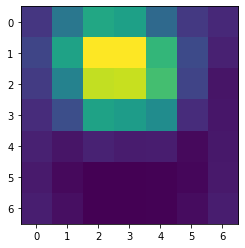

In [160]:
plt.imshow(heatmap)

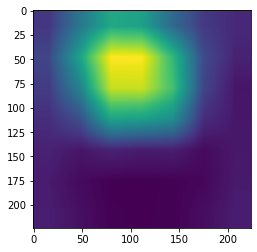

In [161]:
import cv2
heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[2]))
heatmap_resized = np.uint8(255 * heatmap_resized)
plt.imshow(heatmap_resized)

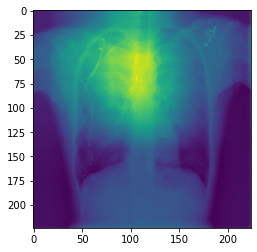

In [165]:
im = image.transpose((1,2,0))
alpha = 0.9
image_with_gradcam = im[:,:,0]*(1-alpha) + heatmap_resized*alpha
plt.imshow(image_with_gradcam)

In [260]:
foldno = 1
val_df = train_df_clf_folds[train_df_clf_folds["kfolds"] == foldno].reset_index(drop=True)
val_image_paths = val_df["path"].values.tolist() # convert to list since it is string 
val_targets = val_df["class"].values # no need to convert to list since it a numpy array

clf_val_dataset = ClassificationDataset(val_image_paths, val_targets, dcm=1, \
                                          augmentations=aug, transforms=transforms)

val_dataloader = DataLoader(clf_val_dataset, batch_size=10, shuffle=True)
model_for_gradcam.eval()
images, targets = next(iter(val_dataloader))
images = images.to(device)                       
# forward pass
op = model_for_gradcam(images)

images_list = []
heatmaps_list = []
for i in range(images.shape[0]):
    
    # backward pass
    op[i].backward(retain_graph=True)
    with torch.no_grad():

        # get the hooked gradient
        gradient = model_for_gradcam.get_activations_grad()
        # take average of gradient for every channel
        gradient = torch.mean(gradient, dim=[0,2,3])
        # get the activation
        activation = model_for_gradcam.get_activations()
        # weighting of activation with gradient
        activation = activation[i,:,:,:]*gradient[:,None,None]
        # activation
        heatmap = torch.mean(activation, dim=[0]).squeeze()
        # pass heatmap through relu
        heatmap = nn.ReLU()(heatmap)
        # normalize heatmap
        heatmap = heatmap/torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()
        images_list.append(images[i].cpu().numpy())
        heatmaps_list.append(heatmap)
        
targets = targets.cpu().numpy()

In [271]:
def display_gradcam(images, heatmaps, preds, targets, max_samples_toshow=8):
    num_samp, ch, h, w = images.shape
    if num_samp > max_samples_toshow:
        num_samp = max_samples_toshow
        images = images[0:num_samp]
        heatmaps = heatmaps[0:num_samp]
        preds = preds[0:num_samp]
    
    heatmaps_resized = [cv2.resize(heatmaps[ind,:,:], (w, h)) for ind in range(heatmaps.shape[0])]
    heatmaps_resized = np.array(heatmaps_resized)
    heatmaps_resized = np.uint8(255 * heatmaps_resized)
    images = images.transpose((0,2,3,1)) # batch, H, W, C
    images= np.array(images)
    alpha = 0.9
    image_with_gradcam = images[:,:,:,0]*(1-alpha) + heatmap_resized*alpha
    fig, ax = plt.subplots(1, num_samp, sharey=True, figsize=(20,20))
    
    for i in range(num_samp):
        ax[i].imshow(image_with_gradcam[i,:,:])
        ax[i].set_title(f"GT:{targets[i]:.2f}, Pred:{preds[i]:.2f}")

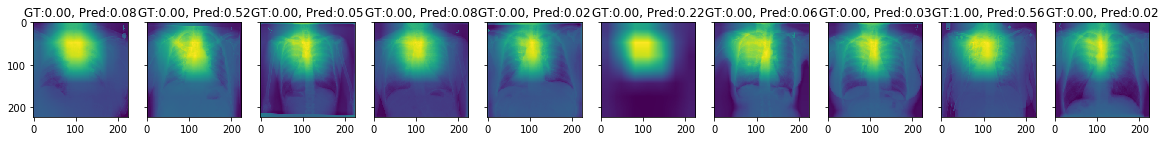

In [272]:
images, heatmaps = np.array(images_list), np.array(heatmaps_list)
op_ = nn.Sigmoid()(op)
preds = op_.squeeze().detach().cpu().numpy()
display_gradcam(images, heatmaps, preds, targets, max_samples_toshow=10)

In [263]:
preds

array([0.07560072, 0.51619625, 0.05008411, 0.07554469, 0.01596059,
       0.22182366, 0.06429856, 0.03256029, 0.5643979 , 0.02389022],
      dtype=float32)

In [264]:
targets

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [265]:
op

tensor([[-2.5037],
        [ 0.0648],
        [-2.9427],
        [-2.5045],
        [-4.1215],
        [-1.2551],
        [-2.6778],
        [-3.3916],
        [ 0.2590],
        [-3.7101]], device='cuda:0', grad_fn=<AddmmBackward>)